In [ ]:
import pandas as pd

# Replace 'your_file.xlsx' with the path to your Excel file
excel_file = 'etf_ei_merged_data.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Print the column names (indexes)
df.columns


In [ ]:
pip install pyportfolioopt

In [ ]:
conda install -c conda-forge pypfopt

### Black Litterman Model

In [4]:
# Required Libraries
import pandas as pd
from pypfopt import black_litterman
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Load the Data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot to have daily returns for each ETF in columns
df_pivot = df.pivot(index='Date', columns='Ticker', values='daily_return')

# Calculate the mean returns and covariance matrix
mean_returns = df_pivot.mean()
cov_matrix = df_pivot.cov()

# Use Volume as a pseudo market cap
pseudo_market_caps = df.groupby('Ticker')['Volume'].sum()

# Calculate the market-implied risk premium
market_implied_risk_premium = mean_returns.dot(pseudo_market_caps) / pseudo_market_caps.sum()

# Calculate delta (risk aversion)
delta = market_implied_risk_premium / (cov_matrix.dot(pseudo_market_caps).dot(mean_returns))

# Get the market-implied prior returns using our pseudo-market caps
market_prior = black_litterman.market_implied_prior_returns(pseudo_market_caps, delta, cov_matrix)

# Define your views. For illustrative purposes, assuming the first two ETFs will have specific returns.
Q = pd.Series([0.05, 0.02], index=df_pivot.columns[:2])

# Create the view matrix P
P = pd.DataFrame(0, index=Q.index, columns=mean_returns.index)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Using the Black-Litterman model to adjust the returns
bl = black_litterman.BlackLittermanModel(cov_matrix, pi=market_prior, absolute_views=Q, P=P)

# Calculate the Black-Litterman adjusted returns
adjusted_returns = bl.bl_returns()

# Portfolio Optimization using the Efficient Frontier
ef = EfficientFrontier(adjusted_returns, cov_matrix)
weights = ef.max_sharpe()

# Aggregating the ETF weights by their sectors for sector-based weights
df_weights = pd.DataFrame(list(weights.items()), columns=['Ticker', 'Weight'])
merged_weights = df_weights.merge(df[['Ticker', 'Sector']].drop_duplicates(), on='Ticker')
sector_weights = merged_weights.groupby('Sector')['Weight'].sum()

print(sector_weights)


Sector
Agriculture         1.805657e-03
Commodities         1.000000e-16
Crude Oil           9.981943e-01
Finance             0.000000e+00
Healthcare          0.000000e+00
Market Benchmark    0.000000e+00
Technology          0.000000e+00
Name: Weight, dtype: float64


In [ ]:
Assuming that higher BCI means better performance and vice versa

In [12]:
import pandas as pd
from pypfopt import black_litterman
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Load the Data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot to get daily returns for each ETF in columns
df_pivot = df.pivot(index='Date', columns='Ticker', values='daily_return')

# Calculate the mean returns and covariance matrix
mean_returns = df_pivot.mean()
cov_matrix = df_pivot.cov()

# Views based on BCI
bci_threshold = df['bci'].mean()
high_bci_etfs = df[df['bci'] > bci_threshold]['Ticker'].unique()
low_bci_etfs = df[df['bci'] <= bci_threshold]['Ticker'].unique()

# First, let's see which tickers are causing the issue
view_tickers = set(high_bci_etfs) | set(low_bci_etfs)
cov_tickers = set(cov_matrix.index)
mean_returns_tickers = set(mean_returns.index)

# Find the tickers present in views but not in the covariance matrix or mean returns
missing_tickers = view_tickers - cov_tickers - mean_returns_tickers

print("Tickers in views but not in the universe:", missing_tickers)

# Now, let's filter out these tickers from the views
filtered_high_bci_etfs = [etf for etf in high_bci_etfs if etf not in missing_tickers]
filtered_low_bci_etfs = [etf for etf in low_bci_etfs if etf not in missing_tickers]

# Recreate Q with these filtered views
Q = pd.concat([pd.Series({etf: 0.05 for etf in filtered_high_bci_etfs}), 
               pd.Series({etf: -0.05 for etf in filtered_low_bci_etfs})])

# Check that each ticker in Q exists in both the covariance matrix and the mean returns
valid_tickers = cov_tickers & mean_returns_tickers
filtered_Q = Q[Q.index.isin(valid_tickers)]

# Recreate the P matrix
P = pd.DataFrame(0, index=filtered_Q.index, columns=mean_returns.index)
for ticker in filtered_Q.index:
    P.loc[ticker, ticker] = 1

# Attempt Black-Litterman model again
bl = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=filtered_Q, P=P)

# Check the Black-Litterman adjusted returns
adjusted_returns = bl.bl_returns()
print(adjusted_returns)


Tickers in views but not in the universe: set()


ValueError: Providing a view on an asset not in the universe

In [16]:
# validation.py

import pandas as pd

def validate_data(filepath):
    df = pd.read_excel(filepath)

    # Check for missing values
    print("Missing values in each column:")
    print(df.isnull().sum())
    print("\n")

    # Validate unique tickers and sectors
    tickers = df['Ticker'].unique()
    sectors = df['Sector'].unique()
    print(f"Total number of unique tickers: {len(tickers)}")
    print(f"Total number of unique sectors: {len(sectors)}")
    print("\n")

    # Pivot to get daily returns for each ETF in columns
    df_pivot = df.pivot(index='Date', columns='Ticker', values='daily_return')

    # Check any columns (tickers) in the pivot that have all NaN values
    all_nan_columns = df_pivot.columns[df_pivot.isnull().all()].tolist()
    if all_nan_columns:
        print(f"Tickers with all NaN values: {all_nan_columns}")
    else:
        print("No tickers with all NaN values.")
    print("\n")

    # Views based on BCI
    bci_threshold = df['bci'].mean()
    high_bci_etfs = df[df['bci'] > bci_threshold]['Ticker'].unique()
    low_bci_etfs = df[df['bci'] <= bci_threshold]['Ticker'].unique()
    
    # Check for tickers in the views but not in the data
    missing_high_bci_etfs = [etf for etf in high_bci_etfs if etf not in tickers]
    missing_low_bci_etfs = [etf for etf in low_bci_etfs if etf not in tickers]

    print(f"Tickers in high BCI views but not in dataset: {missing_high_bci_etfs}")
    print(f"Tickers in low BCI views but not in dataset: {missing_low_bci_etfs}")

if __name__ == "__main__":
    validate_data('etf_ei_merged_data.xlsx')


Missing values in each column:
Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Sector           0
Ticker           0
log_return       0
daily_return     0
volatility       0
momentum         0
Direction        0
MA_50            0
MA_100           0
MA_200           0
bci              0
cci              0
cli              0
long_term_ir     0
short_term_ir    0
dtype: int64


Total number of unique tickers: 24
Total number of unique sectors: 7


No tickers with all NaN values.


Tickers in high BCI views but not in dataset: []
Tickers in low BCI views but not in dataset: []


### Black Litterman Problem working

In [17]:
import pandas as pd
from pypfopt import black_litterman, risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Read the data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot the dataset to have daily returns for each ETF in columns
df_pivot = df.pivot(index='Date', columns='Ticker', values='daily_return')

# Calculate mean returns and covariance matrix
mean_returns = df_pivot.mean()
cov_matrix = df_pivot.cov()

# Establishing views based on BCI
bci_threshold = df['bci'].mean()
high_bci_etfs = df[df['bci'] > bci_threshold]['Ticker'].unique()
low_bci_etfs = df[df['bci'] <= bci_threshold]['Ticker'].unique()

Q = pd.concat([pd.Series({etf: 0.05 for etf in high_bci_etfs}), 
               pd.Series({etf: -0.05 for etf in low_bci_etfs})])

# Construct the P matrix
P = pd.DataFrame(0, index=Q.index, columns=mean_returns.index)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Initialize the Black-Litterman model
bl = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)

# Get the Black-Litterman adjusted returns
adjusted_returns = bl.bl_returns()

# Construct the Efficient Frontier using adjusted returns
ef = EfficientFrontier(adjusted_returns, cov_matrix)
weights = ef.max_sharpe()

# Extract ETF weights
etf_weights = pd.DataFrame(list(weights.items()), columns=['Ticker', 'Weight'])

# Calculate Sector weights
merged_weights = etf_weights.merge(df[['Ticker', 'Sector']].drop_duplicates(), on='Ticker')
sector_weights = merged_weights.groupby('Sector')['Weight'].sum()

print("ETF Weights:\n", etf_weights)
print("\nSector Weights:\n", sector_weights)


ValueError: Providing a view on an asset not in the universe

In [18]:
# Identify missing tickers in the covariance matrix or mean returns
missing_from_cov = [ticker for ticker in Q.index if ticker not in cov_matrix.columns]
missing_from_mean_returns = [ticker for ticker in Q.index if ticker not in mean_returns.index]

print("Tickers in Q but not in covariance matrix:", missing_from_cov)
print("Tickers in Q but not in mean returns:", missing_from_mean_returns)

Tickers in Q but not in covariance matrix: []
Tickers in Q but not in mean returns: []


In [19]:
print("Length of Q:", len(Q))
print("Number of rows in P:", P.shape[0])

# Check alignment between Q and P
alignment_check = all(Q.index == P.index)
print("Q and P alignment check:", alignment_check)


Length of Q: 48
Number of rows in P: 48
Q and P alignment check: True


In [20]:
import pandas as pd
from pypfopt import black_litterman, risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Load the data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot the dataframe to get daily returns for each ETF in columns
df_pivot = df.pivot(index='Date', columns='Ticker', values='daily_return')

# Calculate mean returns and covariance matrix
mean_returns = df_pivot.mean()
cov_matrix = df_pivot.cov()

# Create a simple view for a few tickers (Replace 'TICKER1', 'TICKER2' with actual ticker names from your dataset)
simple_Q = pd.Series({
    'CORN': 0.05,
    'SOYB': -0.03
})

# Construct the P matrix for the simple views
P_simple = pd.DataFrame(0, index=simple_Q.index, columns=mean_returns.index)
for ticker in simple_Q.index:
    P_simple.loc[ticker, ticker] = 1

# Initialize the Black-Litterman model with the simple views
bl_simple = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=simple_Q, P=P_simple)

# Get the Black-Litterman adjusted returns
adjusted_returns_simple = bl_simple.bl_returns()

print(adjusted_returns_simple)


Ticker
BNO     0.001547
BOTZ   -0.002121
CORN    0.016683
GLD    -0.000707
HACK    0.000088
IHI    -0.000349
KBE     0.000589
KIE     0.000402
KRE     0.000950
PALL   -0.000950
PJP     0.000158
PPLT   -0.001918
QQQ    -0.001446
SKYY   -0.000717
SLV    -0.001565
SMH    -0.002480
SOYB   -0.005563
SPY    -0.001209
UNG     0.003073
USO     0.001385
WEAT    0.010608
XBI    -0.000583
XLF    -0.001095
XLV    -0.000049
dtype: float64


In [22]:
# Specifying views manually for three ETFs (Replace 'TICKER1', 'TICKER2', 'TICKER3' with ETFs from your dataset)
manual_Q = pd.Series({
    'CORN': 0.05,
    'SOYB': -0.03,
    'WEAT': 0.04
})

# Construct the P matrix for these manual views
P_manual = pd.DataFrame(0, index=manual_Q.index, columns=mean_returns.index)
for ticker in manual_Q.index:
    P_manual.loc[ticker, ticker] = 1

# Ensure the tickers in manual_Q are present in the dataset
assert all(manual_Q.index.isin(mean_returns.index))

# Initialize the Black-Litterman model with the manual views
bl_manual = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=manual_Q, P=P_manual)

# Get the Black-Litterman adjusted returns based on manual views
adjusted_returns_manual = bl_manual.bl_returns()

print(adjusted_returns_manual)


Ticker
BNO     0.003196
BOTZ   -0.002046
CORN    0.019852
GLD    -0.000118
HACK    0.000392
IHI    -0.000440
KBE     0.001460
KIE     0.000618
KRE     0.001863
PALL    0.001002
PJP    -0.000040
PPLT   -0.000387
QQQ    -0.001520
SKYY   -0.000440
SLV     0.000214
SMH    -0.002806
SOYB   -0.003975
SPY    -0.001231
UNG     0.003873
USO     0.003140
WEAT    0.023535
XBI    -0.000566
XLF    -0.000883
XLV    -0.000263
dtype: float64


In [23]:
# Establishing views based only on High BCI
high_bci_etfs = df[df['bci'] > bci_threshold]['Ticker'].unique()

Q_high_bci = pd.Series({etf: 0.05 for etf in high_bci_etfs})

# Construct the P matrix for High BCI-based views
P_high_bci = pd.DataFrame(0, index=Q_high_bci.index, columns=mean_returns.index)
for ticker in Q_high_bci.index:
    P_high_bci.loc[ticker, ticker] = 1

# Ensure the tickers in Q_high_bci are present in the dataset
assert all(Q_high_bci.index.isin(mean_returns.index))

# Initialize the Black-Litterman model with high BCI-based views
bl_high_bci = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q_high_bci, P=P_high_bci)

# Get the Black-Litterman adjusted returns based on high BCI views
adjusted_returns_high_bci = bl_high_bci.bl_returns()

print(adjusted_returns_high_bci)

Ticker
BNO     0.044970
BOTZ    0.054461
CORN    0.035851
GLD     0.027490
HACK    0.046312
IHI     0.045822
KBE     0.050142
KIE     0.045559
KRE     0.047737
PALL    0.053229
PJP     0.040534
PPLT    0.049057
QQQ     0.046193
SKYY    0.052134
SLV     0.051729
SMH     0.059908
SOYB    0.034879
SPY     0.039193
UNG     0.034043
USO     0.048763
WEAT    0.039060
XBI     0.052203
XLF     0.042771
XLV     0.038229
dtype: float64


In [25]:
# First, let's eliminate any possible redundancy in the views.
unique_high_bci_etfs = set(high_bci_etfs) - set(low_bci_etfs)
unique_low_bci_etfs = set(low_bci_etfs) - set(high_bci_etfs)

Q_both_bci = pd.concat([pd.Series({etf: 0.05 for etf in unique_high_bci_etfs}), 
                        pd.Series({etf: -0.05 for etf in unique_low_bci_etfs})])

# Construct the P matrix for both BCI-based views
P_both_bci = pd.DataFrame(0, index=Q_both_bci.index, columns=mean_returns.index)
for ticker in Q_both_bci.index:
    P_both_bci.loc[ticker, ticker] = 1

# Assert checks
assert all(Q_both_bci.index.isin(mean_returns.index)), "Some tickers in Q are not in the mean returns."
assert all(Q_both_bci.index.isin(cov_matrix.columns)), "Some tickers in Q are not in the covariance matrix."

# Now, initialize the Black-Litterman model with both BCI-based views
bl_both_bci = black_litterman.BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q_both_bci, P=P_both_bci)

# Get the Black-Litterman adjusted returns based on both BCI views
adjusted_returns_both_bci = bl_both_bci.bl_returns()

print(adjusted_returns_both_bci)


Ticker
BNO     0.000383
BOTZ    0.000013
CORN    0.000302
GLD     0.000190
HACK    0.000249
IHI     0.000380
KBE     0.000096
KIE     0.000233
KRE     0.000128
PALL    0.000426
PJP     0.000154
PPLT    0.000139
QQQ     0.000352
SKYY    0.000224
SLV     0.000245
SMH     0.000529
SOYB    0.000289
SPY     0.000233
UNG    -0.000024
USO    -0.000005
WEAT    0.000229
XBI     0.000109
XLF     0.000169
XLV     0.000303
dtype: float64


In [29]:
try:
    # Optimize for minimal volatility
    weights = ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    print(cleaned_weights)
except Exception as e:
    print(f"An error occurred: {e}")


OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.11212), ('GLD', 0.44584), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.00109), ('PALL', 0.0), ('PJP', 0.03324), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.1337), ('SPY', 0.07863), ('UNG', 0.02331), ('USO', 0.0), ('WEAT', 0.01699), ('XBI', 0.0), ('XLF', 0.02062), ('XLV', 0.13445)])


#### Working on Black Litterman Model

In [34]:
print(df_numeric.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return',
       'daily_return', 'volatility', 'momentum', 'MA_50', 'MA_100', 'MA_200',
       'bci', 'cci', 'cli', 'long_term_ir', 'short_term_ir'],
      dtype='object')


In [36]:
import pandas as pd
from pypfopt import expected_returns, risk_models, black_litterman, BlackLittermanModel, EfficientFrontier

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Extracting closing prices for Black-Litterman
prices = df['Close'].unstack(level=0)

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

# Deriving views from various metrics
views = {}
for ticker in df.index.get_level_values(0).unique():
    latest_data = df.loc[ticker].iloc[-1]

    # MA view
    if latest_data['MA_50'] > latest_data['MA_200']:
        views[ticker] = 0.02

    # BCI view
    if latest_data['bci'] > df.loc[ticker].iloc[-5]['bci']:
        views[ticker] = views.get(ticker, 0) + 0.015

    # CCI view
    if latest_data['cci'] < df.loc[ticker].iloc[-5]['cci']:
        views[ticker] = views.get(ticker, 0) - 0.015

    # Momentum and Log Return view
    if latest_data['log_return'] > 0 and latest_data['momentum'] > 0:
        views[ticker] = views.get(ticker, 0) + 0.01

    # Long Term Interest Rate view
    if latest_data['long_term_ir'] > df.loc[ticker].iloc[-5]['long_term_ir']:
        views[ticker] = views.get(ticker, 0) - 0.02

    # Short Term Interest Rate view
    if latest_data['short_term_ir'] < df.loc[ticker].iloc[-5]['short_term_ir']:
        views[ticker] = views.get(ticker, 0) + 0.02

    # Normalize views
    views[ticker] = min(max(views.get(ticker, 0), -0.05), 0.05)

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Setup Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using the adjusted expected returns from the Black-Litterman model
ef = EfficientFrontier(bl_return, cov_matrix)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()
print(optimized_weights)


ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.range.RangeIndex'> was passed

In [38]:
import pandas as pd

df = pd.read_excel('etf_ei_merged_data.xlsx')

df.describe()


Date          Open          High           Low  \
count                43824  43824.000000  43824.000000  43824.000000   
mean   2020-07-01 12:00:00     79.447525     80.094649     78.722484   
min    2018-01-01 00:00:00      4.880000      4.960000      4.830000   
25%    2019-04-02 00:00:00     24.580000     24.858751     24.290001   
50%    2020-07-01 12:00:00     51.880000     52.335834     51.345278   
75%    2021-10-01 00:00:00     95.599998     96.421665     94.639999   
max    2022-12-31 00:00:00    479.220001    479.980011    476.059998   
std                    NaN     83.724420     84.297746     83.059088   

              Close     Adj Close        Volume    log_return  daily_return  \
count  43824.000000  43824.000000  4.382400e+04  43824.000000  43824.000000   
mean      79.430348     77.524156  1.119298e+07      0.000130      0.000223   
min        4.860000      4.860000  2.800000e+03     -0.142914     -0.133171   
25%       24.605000     23.938191  1.939000e+05     -0.004862     -0.004850   
50%       51.827500     49.170349  1.700900e+06      0.000258      0.000258   
75%       95.489998     94.874357  8.810000e+06      0.005337      0.005351   
max      477.709991    464.923401  2.189132e+08      0.190983      0.210439   
std       83.708333     81.514525  2.327038e+07      0.013615      0.013605   

         volatility      momentum     Direction         MA_50        MA_100  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean       0.011623      0.005093      0.512778     79.118215     78.787490   
min        0.000003     -0.603352      0.000000      5.110933      5.211500   
25%        0.007079     -0.027187      0.000000     24.527129     24.557175   
50%        0.010091      0.008192      1.000000     51.895616     51.969188   
75%        0.014318      0.039724      1.000000     94.783200     94.528308   
max        0.073483      0.597878      1.000000    466.792103    463.259501   
std        0.006821      0.066887      0.499842     83.265191     82.815795   

             MA_200           bci           cci           cli  long_term_ir  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean      78.056709    100.481762     99.627084     99.645119      2.057829   
min        5.339500     98.167170     96.134230     92.625770      0.620000   
25%       24.330281     99.528110     98.357870     98.999913      1.416774   
50%       51.698338    100.765445     99.740621     99.836504      1.856774   
75%       94.180950    101.391361    101.385000    100.784284      2.876774   
max      453.177159    101.996100    101.642500    101.314000      3.980000   
std       81.847351      1.049672      1.783538      1.531893      0.889272   

       short_term_ir  
count   43824.000000  
mean        1.445504  
min         0.090000  
25%         0.161613  
50%         1.667621  
75%         2.248387  
max         4.508387  
std         1.144198

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           43824 non-null  datetime64[ns]
 1   Open           43824 non-null  float64       
 2   High           43824 non-null  float64       
 3   Low            43824 non-null  float64       
 4   Close          43824 non-null  float64       
 5   Adj Close      43824 non-null  float64       
 6   Volume         43824 non-null  float64       
 7   Sector         43824 non-null  object        
 8   Ticker         43824 non-null  object        
 9   log_return     43824 non-null  float64       
 10  daily_return   43824 non-null  float64       
 11  volatility     43824 non-null  float64       
 12  momentum       43824 non-null  float64       
 13  Direction      43824 non-null  int64         
 14  MA_50          43824 non-null  float64       
 15  MA_100         4382

In [40]:
df.shape

(43824, 22)

In [41]:
df.index

RangeIndex(start=0, stop=43824, step=1)

In [42]:
import pandas as pd
from pypfopt import expected_returns, risk_models, black_litterman, BlackLittermanModel, EfficientFrontier

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot the dataframe to get closing prices of each ticker as columns
prices = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

# Derive views from indicators
views = {}
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Setup Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using the adjusted expected returns from the Black-Litterman model
ef = EfficientFrontier(bl_return, cov_matrix)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()
print(optimized_weights)


OrderedDict([('BNO', 0.04548), ('BOTZ', 0.0), ('CORN', 0.13578), ('GLD', 0.25413), ('HACK', 0.0), ('IHI', 0.16585), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0853), ('SOYB', 0.1765), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.13696)])


In [50]:
import pandas as pd
from pypfopt import expected_returns, risk_models, black_litterman, BlackLittermanModel, EfficientFrontier

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Pivot the dataframe to get closing prices of each ticker as columns
prices = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

# Derive views from indicators
views = {}
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Setup Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using the adjusted expected returns from the Black-Litterman model
ef = EfficientFrontier(bl_return, cov_matrix)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()
print(optimized_weights)

# Sector-wise optimized weights
sectors = df[['Ticker', 'Sector']].drop_duplicates().set_index('Ticker')['Sector'].to_dict()
sector_weights = {sector: 0 for sector in df['Sector'].unique()}

for ticker, weight in optimized_weights.items():
    sector_weights[sectors[ticker]] += weight

# Sector-wise optimized weights
sectors = df[['Ticker', 'Sector']].drop_duplicates().set_index('Ticker')['Sector'].to_dict()
sector_weights = {sector: 0 for sector in df['Sector'].unique()}
sector_etf_counts = {sector: 0 for sector in df['Sector'].unique()}

for ticker, weight in optimized_weights.items():
    sector_weights[sectors[ticker]] += weight
    sector_etf_counts[sectors[ticker]] += 1

# Average the weights and normalize
for sector, weight in sector_weights.items():
    sector_weights[sector] = weight / sector_etf_counts[sector]

# Normalizing sector weights to sum up to 1
total_sector_weight = sum(sector_weights.values())
normalized_sector_weights = {sector: weight/total_sector_weight for sector, weight in sector_weights.items()}

print("\nNormalized Sector-wise Average Optimized Weights:")
for sector, weight in normalized_sector_weights.items():
    print(f"{sector}: {weight:.4f}")


OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])

Normalized Sector-wise Average Optimized Weights:
Agriculture: 0.3608
Commodities: 0.1047
Crude Oil: 0.2248
Finance: 0.0000
Healthcare: 0.2485
Market Benchmark: 0.0000
Technology: 0.0612


### Train and Test Data - Black Litterman Model

C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")


Optimized Weights from Training Data: OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.03389), ('GLD', 0.3592), ('HACK', 0.0), ('IHI', 0.16694), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.35513), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.08483), ('SOYB', 0.0), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


C:\Users\saide\AppData\Local\Temp\ipykernel_5224\3802356878.py:291: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  test_returns = test_prices.pct_change().dropna()


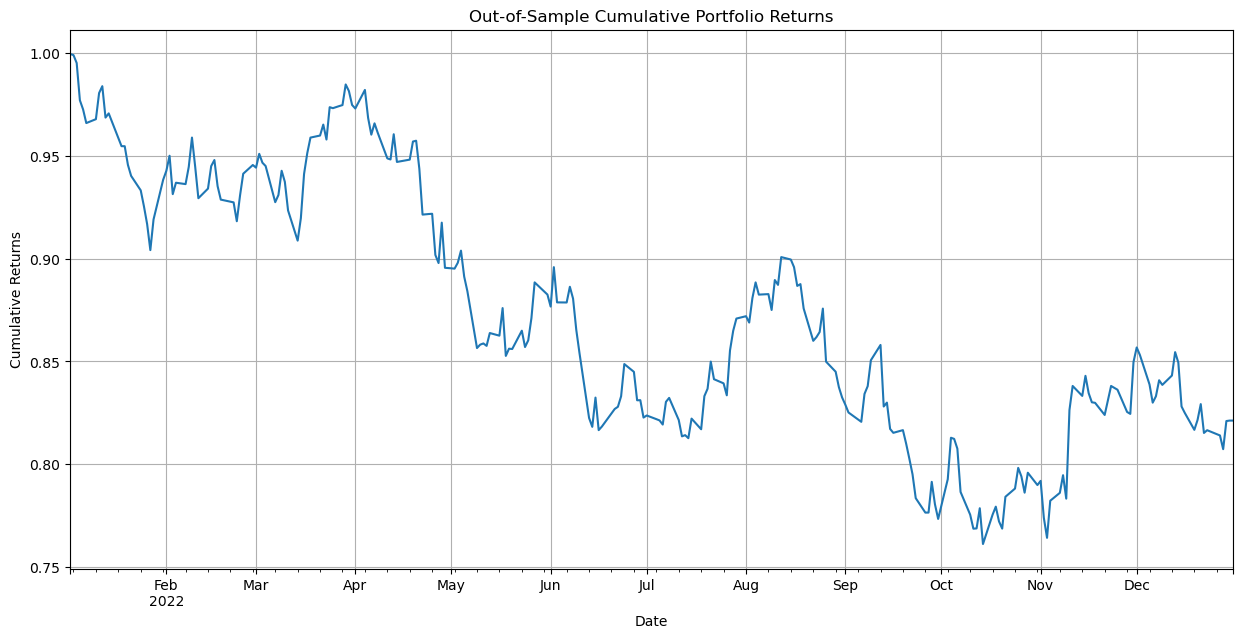

Total Out-of-sample Portfolio Return: -17.88375869536659 %
Average Daily Return: -0.04937872277653511 %
Standard Deviation of Daily Return: 0.9758074892441463 %

Potential Future Optimized Weights: OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.03389), ('GLD', 0.3592), ('HACK', 0.0), ('IHI', 0.16694), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.35513), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.08483), ('SOYB', 0.0), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, black_litterman, BlackLittermanModel, EfficientFrontier

# Load data
df_1 = pd.read_excel('etf_ei_merged_data.xlsx')

# Split data into training and test sets
train_pct = 0.8
train_size = int(train_pct * len(df))
df_train = df_1.iloc[:train_size]
df_test = df_1.iloc[train_size:]

# Your portfolio optimization code goes here, but using df_train...

# Load data
df = df_train

# Pivot the dataframe to get closing prices of each ticker as columns
prices = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

# Derive views from indicators
views = {}
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Setup Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using the adjusted expected returns from the Black-Litterman model
ef = EfficientFrontier(bl_return, cov_matrix)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()

# Optimized weights from training data
print("Optimized Weights from Training Data:", optimized_weights)

# Use these weights to evaluate performance on test data
test_prices = df_test.pivot(index='Date', columns='Ticker', values='Close')
test_returns = test_prices.pct_change().dropna()

# Calculate portfolio daily returns using optimized weights
portfolio_daily_returns = (test_returns * optimized_weights).sum(axis=1)

# Cumulative returns
cumulative_returns = (portfolio_daily_returns + 1).cumprod()

# Plot ETF returns trend
plt.figure(figsize=(15,7))
cumulative_returns.plot()
plt.title('Out-of-Sample Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Insights
print("Total Out-of-sample Portfolio Return:", (cumulative_returns.iloc[-1] - 1) * 100, "%")
print("Average Daily Return:", portfolio_daily_returns.mean() * 100, "%")
print("Standard Deviation of Daily Return:", portfolio_daily_returns.std() * 100, "%")

# Potential future optimized weights using the entire dataset (training + test)
prices = df.pivot(index='Date', columns='Ticker', values='Close')
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

bl_all_data = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return_all_data = bl_all_data.bl_returns()

ef_all_data = EfficientFrontier(bl_return_all_data, cov_matrix)
future_optimized_weights = ef_all_data.max_sharpe()
print("\nPotential Future Optimized Weights:", ef_all_data.clean_weights())


C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")


Optimized Weights from Training Data: OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.0), ('GLD', 0.67248), ('HACK', 0.0), ('IHI', 0.04491), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.08188), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.20073), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.0), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


C:\Users\saide\AppData\Local\Temp\ipykernel_21284\3895088898.py:291: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  test_returns = test_prices.pct_change().dropna()


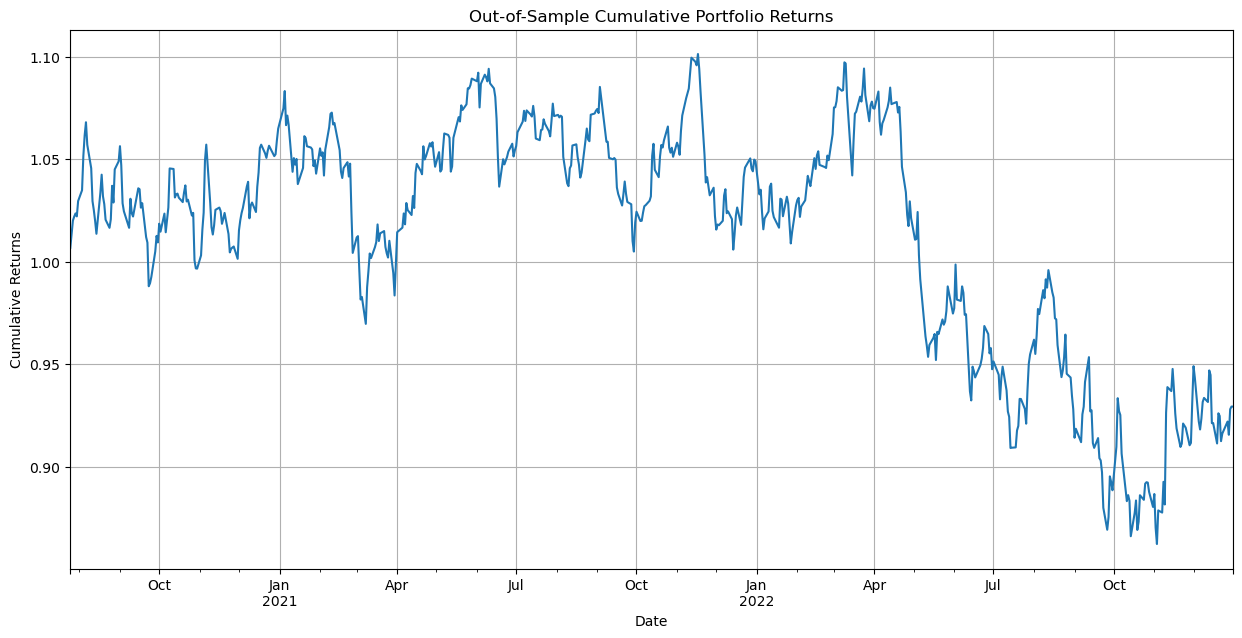

Total Out-of-sample Portfolio Return: -7.06903040849951 %
Average Daily Return: -0.0056720813624716124 %
Standard Deviation of Daily Return: 0.7170941650083559 %

Potential Future Optimized Weights: OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.0), ('GLD', 0.67248), ('HACK', 0.0), ('IHI', 0.04491), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.08188), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.20073), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.0), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
C:\Users\saide\AppData\Local\Temp\ipykernel_21284\3895088898.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

C:\Users\saide\AppData\Local\Temp\ipykernel_21284\3895088898.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data['Date'] = pd.to_datetime(asset_data['Date'])
C:\Users\saide\AppData\Local\Temp\ipykernel_21284\3895088898.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data['Date'] = pd.to_datetime(asset_data['Date'])
C:\Users\saide\AppData\Local\Temp\ipykernel_21284\3895088898.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

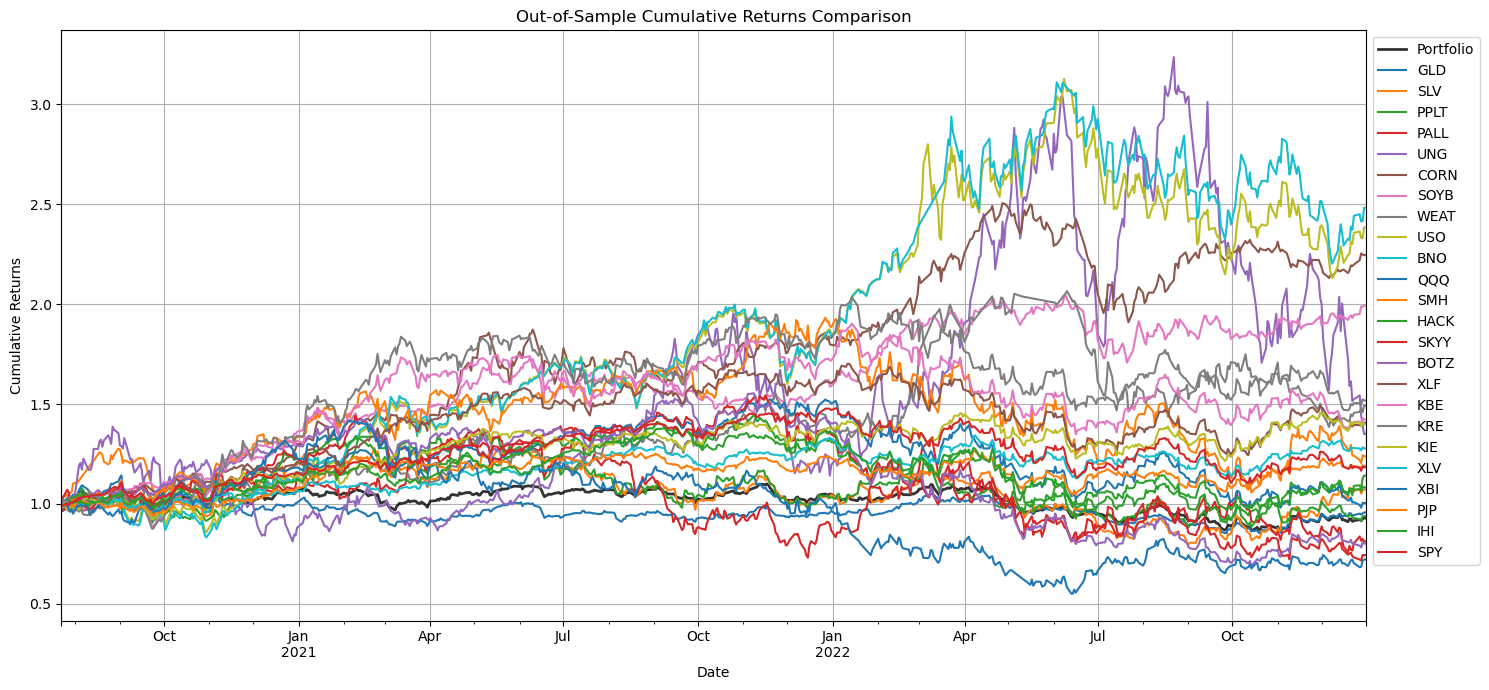


---- Portfolio Performance Metrics ----
Average Daily Return: -0.01%
Volatility: 0.72%
Sharpe Ratio (with 1% Risk-Free Rate): -1.40
Maximum Drawdown: -21.70%


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, black_litterman, BlackLittermanModel, EfficientFrontier

# Load data
df_1 = pd.read_excel('etf_ei_merged_data.xlsx')

# Split data into training and test sets
train_pct = 0.8
train_size = int(train_pct * len(df))
df_train = df_1.iloc[:train_size]
df_test = df_1.iloc[train_size:]

# Your portfolio optimization code goes here, but using df_train...

# Load data
df = df_train

# Pivot the dataframe to get closing prices of each ticker as columns
prices = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

# Derive views from indicators
views = {}
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Setup Black-Litterman model
bl = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using the adjusted expected returns from the Black-Litterman model
ef = EfficientFrontier(bl_return, cov_matrix)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()

# Optimized weights from training data
print("Optimized Weights from Training Data:", optimized_weights)

# Use these weights to evaluate performance on test data
test_prices = df_test.pivot(index='Date', columns='Ticker', values='Close')
test_returns = test_prices.pct_change().dropna()

# Calculate portfolio daily returns using optimized weights
portfolio_daily_returns = (test_returns * optimized_weights).sum(axis=1)

# Cumulative returns
cumulative_returns = (portfolio_daily_returns + 1).cumprod()

# Plot ETF returns trend
plt.figure(figsize=(15,7))
cumulative_returns.plot()
plt.title('Out-of-Sample Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Insights
print("Total Out-of-sample Portfolio Return:", (cumulative_returns.iloc[-1] - 1) * 100, "%")
print("Average Daily Return:", portfolio_daily_returns.mean() * 100, "%")
print("Standard Deviation of Daily Return:", portfolio_daily_returns.std() * 100, "%")

# Potential future optimized weights using the entire dataset (training + test)
prices = df.pivot(index='Date', columns='Ticker', values='Close')
mean_returns = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)

bl_all_data = BlackLittermanModel(cov_matrix, pi=mean_returns, absolute_views=Q, P=P)
bl_return_all_data = bl_all_data.bl_returns()

ef_all_data = EfficientFrontier(bl_return_all_data, cov_matrix)
future_optimized_weights = ef_all_data.max_sharpe()
print("\nPotential Future Optimized Weights:", ef_all_data.clean_weights())

# Generate a list of all tickers
all_tickers = [ticker for sublist in sectors_tickers.values() for ticker in sublist]

# Compute the portfolio daily returns (as you already have done in your previous code)
# portfolio_daily_returns = (test_returns * optimized_weights).sum(axis=1)

# Compute cumulative returns for the portfolio
portfolio_cumulative_returns = (portfolio_daily_returns + 1).cumprod()

# ... [Your code remains unchanged until the plotting section] ...

# ---- Plotting Section ----
plt.figure(figsize=(15,7))
portfolio_cumulative_returns.plot(label="Portfolio", linewidth=2, color='black', alpha=0.8)  # Making portfolio curve more distinguishable

for ticker in all_tickers:
    asset_data = df_test[df_test['Ticker'] == ticker]
    asset_data['Date'] = pd.to_datetime(asset_data['Date'])
    asset_data.set_index('Date', inplace=True)
    asset_returns = asset_data['daily_return']
    asset_cumulative_returns = (asset_returns + 1).cumprod()
    asset_cumulative_returns.plot(label=ticker)

plt.title('Out-of-Sample Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Moving the legend outside for clarity
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Performance Metrics Calculation ----
# Average daily return
average_daily_return = portfolio_daily_returns.mean()

# Volatility (Standard Deviation of Daily Returns)
volatility = portfolio_daily_returns.std()

# Sharpe Ratio (Assuming a risk-free rate of 1% or 0.01)
risk_free_rate = 0.01
sharpe_ratio = (average_daily_return - risk_free_rate) / volatility

# Maximum Drawdown
rolling_max = portfolio_cumulative_returns.cummax()
daily_drawdown = portfolio_cumulative_returns/rolling_max - 1.0
max_daily_drawdown = daily_drawdown.cummin()

# ---- Displaying Performance Metrics ----
print("\n---- Portfolio Performance Metrics ----")
print(f"Average Daily Return: {average_daily_return*100:.2f}%")
print(f"Volatility: {volatility*100:.2f}%")
print(f"Sharpe Ratio (with 1% Risk-Free Rate): {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_daily_drawdown.min()*100:.2f}%")

# Interpretation
# Here, visually inspect the graph.
# Your portfolio's curve compared to individual assets and SPY will give insights into its performance.
# If it's above most of them, it's performing well. If it's below, there might be opportunities to adjust your strategy.

# For detailed statistical metrics (like Alpha, Beta, Sharpe Ratio), 
# additional libraries and computations would be required.

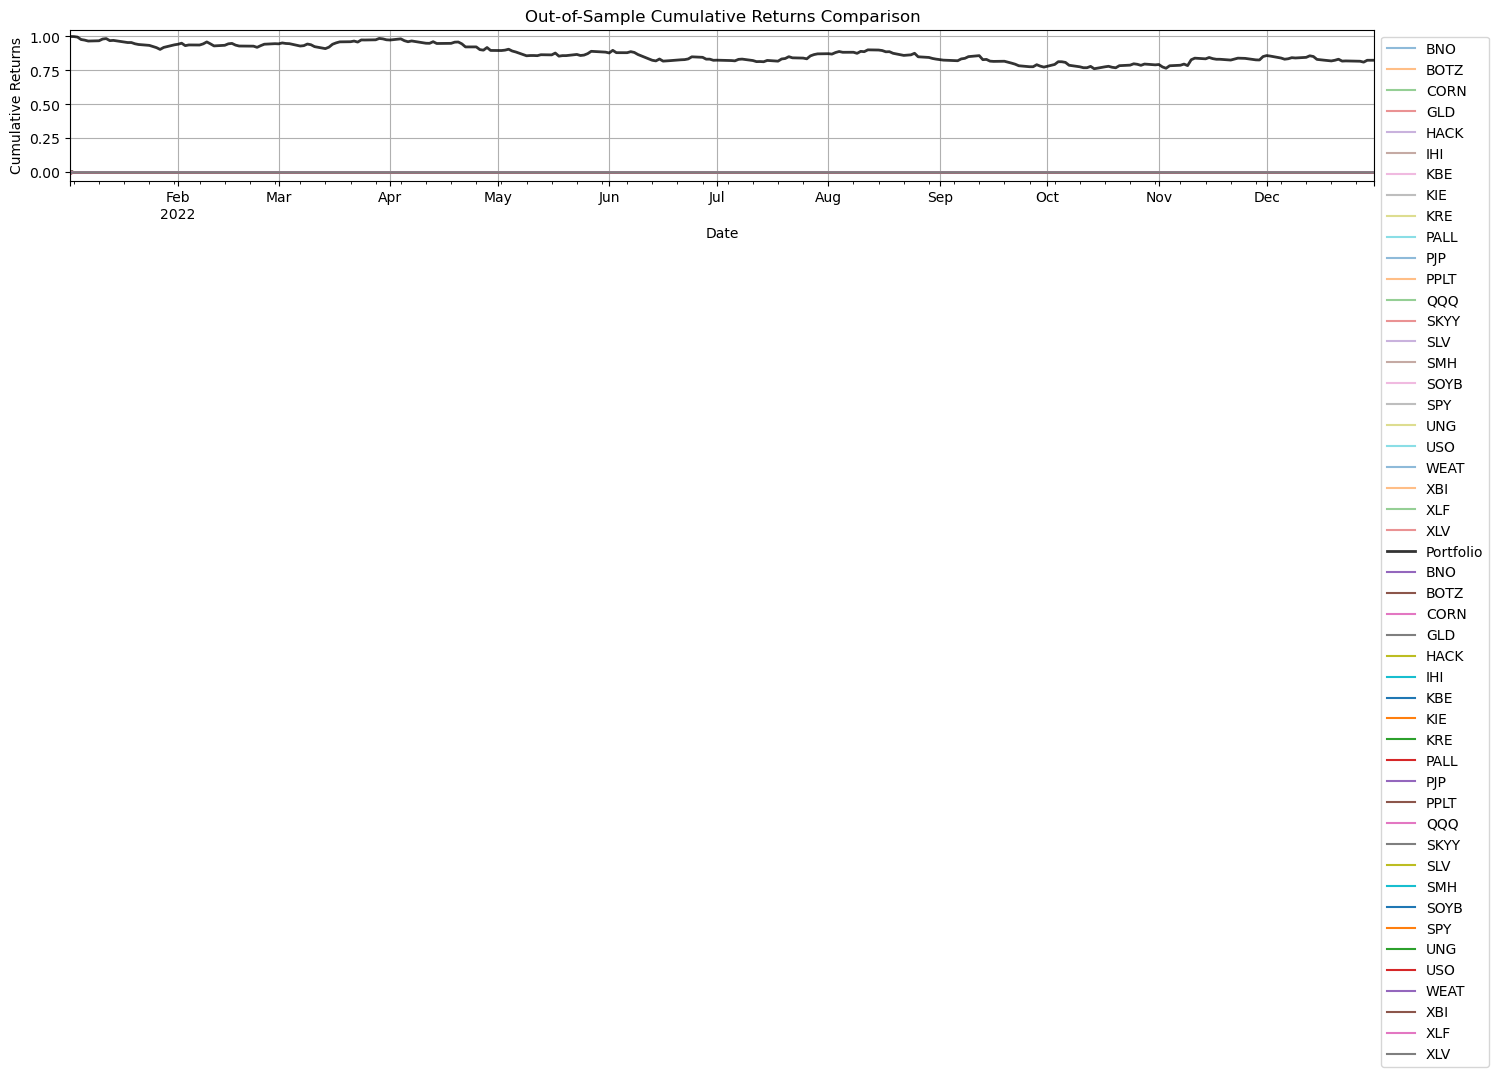


---- Portfolio Performance Metrics ----
Average Daily Return: -0.05%
Volatility: 0.97%
Sharpe Ratio (with 1% Risk-Free Rate): -1.08
Maximum Drawdown: -23.75%

Potential Future Optimized Weights: OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


In [9]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Split data based on the provided dates
df_train = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2021-12-31')]
df_test = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]

# Convert data to prices format for pypfopt
prices_train = df_train.pivot(index='Date', columns='Ticker', values='Close')
prices_test = df_test.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for training data
mean_returns_train = expected_returns.mean_historical_return(prices_train)
cov_matrix_train = risk_models.sample_cov(prices_train)

# Generate views based on your conditions [the provided conditions remain unchanged]
views = {}

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Black-Litterman model setup for training data
bl = BlackLittermanModel(cov_matrix_train, pi=mean_returns_train, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using Black-Litterman model outputs
ef = EfficientFrontier(bl_return, cov_matrix_train)
weights = ef.max_sharpe()  # This line computes the optimal weights
optimized_weights = ef.clean_weights()

# Evaluate performance on test data
test_returns = prices_test.pct_change().dropna()
portfolio_daily_returns_test = (test_returns * optimized_weights).sum(axis=1)
cumulative_returns_test = (portfolio_daily_returns_test + 1).cumprod()


# Plotting sector performance
plt.figure(figsize=(15,7))
# First, plot the individual ETFs' returns
test_returns.cumprod().plot(ax=plt.gca(), alpha=0.5)  # Reduced alpha for better distinction
cumulative_returns_test.plot(label="Portfolio", linewidth=2, color='black', alpha=0.8)
test_returns.cumprod().plot(ax=plt.gca())
plt.title('Out-of-Sample Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
average_daily_return_test = portfolio_daily_returns_test.mean()
volatility_test = portfolio_daily_returns_test.std()
sharpe_ratio_test = (average_daily_return_test - 0.01) / volatility_test
rolling_max_test = cumulative_returns_test.cummax()
daily_drawdown_test = cumulative_returns_test/rolling_max_test - 1.0
max_daily_drawdown_test = daily_drawdown_test.cummin()

print("\n---- Portfolio Performance Metrics ----")
print(f"Average Daily Return: {average_daily_return_test*100:.2f}%")
print(f"Volatility: {volatility_test*100:.2f}%")
print(f"Sharpe Ratio (with 1% Risk-Free Rate): {sharpe_ratio_test:.2f}")
print(f"Maximum Drawdown: {max_daily_drawdown_test.min()*100:.2f}%")

# For the potential future weights considering entire data (2018-2022)
prices_all = pd.concat([prices_train, prices_test])
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)
bl_return_all = bl_all.bl_returns()
bl_return_all = bl_all.bl_returns()
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()  # Compute the optimal weights for all data
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)


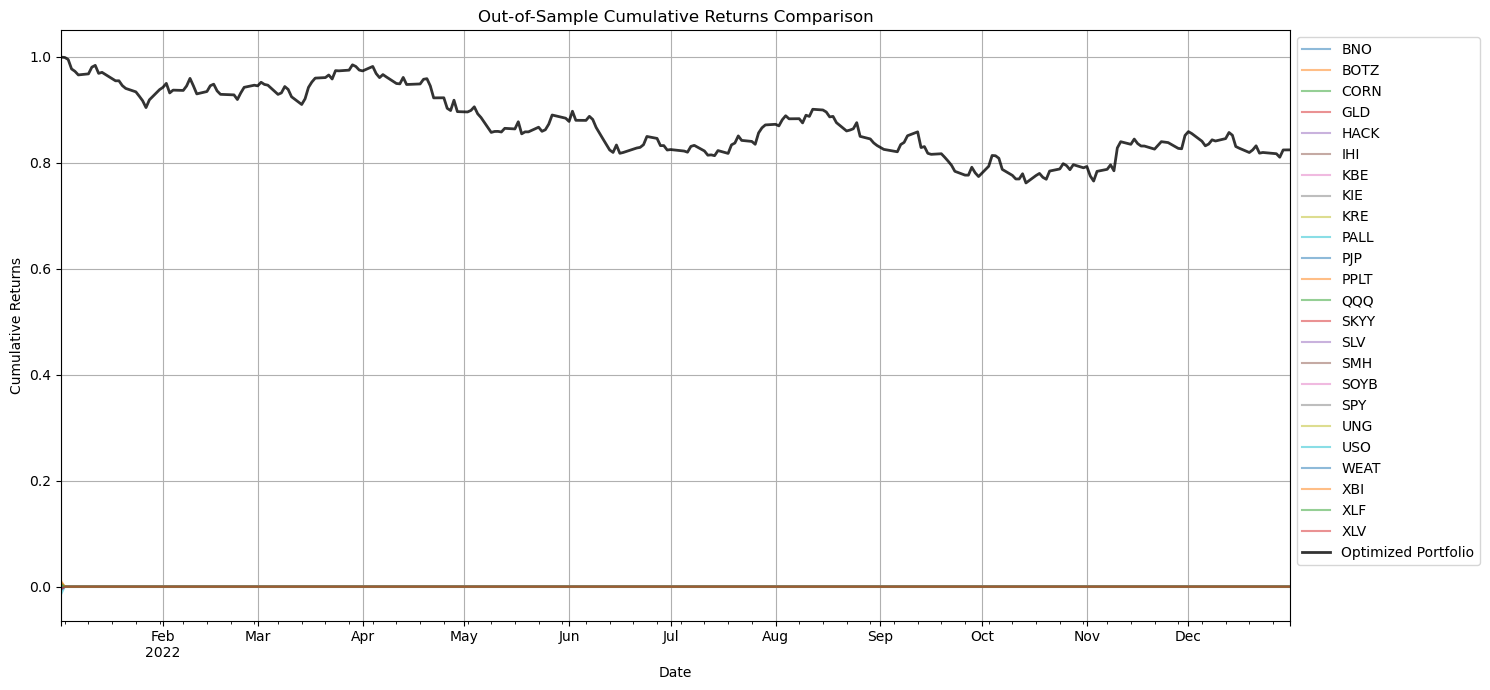


---- Portfolio Performance Metrics ----
Average Daily Return: -0.05%
Volatility: 0.97%
Sharpe Ratio (with 1% Risk-Free Rate): -1.08
Maximum Drawdown: -23.75%

Potential Future Optimized Weights: OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


In [6]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Split data based on the provided dates
df_train = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2021-12-31')]
df_test = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]

# Convert data to prices format for pypfopt
prices_train = df_train.pivot(index='Date', columns='Ticker', values='Close')
prices_test = df_test.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for training data
mean_returns_train = expected_returns.mean_historical_return(prices_train)
cov_matrix_train = risk_models.sample_cov(prices_train)

# Generate views based on your conditions [the provided conditions remain unchanged]
views = {}

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices_train.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Black-Litterman model setup for training data
bl = BlackLittermanModel(cov_matrix_train, pi=mean_returns_train, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# Portfolio optimization using Black-Litterman model outputs
ef = EfficientFrontier(bl_return, cov_matrix_train)
weights = ef.max_sharpe()  # This line computes the optimal weights
optimized_weights = ef.clean_weights()

# Evaluate performance on test data
test_returns = prices_test.pct_change().dropna()
portfolio_daily_returns_test = (test_returns * optimized_weights).sum(axis=1)
cumulative_returns_test = (portfolio_daily_returns_test + 1).cumprod()

# Plotting sector performance
plt.figure(figsize=(15,7))
# First, plot the individual ETFs' returns
test_returns.cumprod().plot(ax=plt.gca(), alpha=0.5)  # Reduced alpha for better distinction
cumulative_returns_test.plot(label="Optimized Portfolio", linewidth=2, color='black', alpha=0.8)
plt.title('Out-of-Sample Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics
average_daily_return_test = portfolio_daily_returns_test.mean()
volatility_test = portfolio_daily_returns_test.std()
sharpe_ratio_test = (average_daily_return_test - 0.01) / volatility_test
rolling_max_test = cumulative_returns_test.cummax()
daily_drawdown_test = cumulative_returns_test/rolling_max_test - 1.0
max_daily_drawdown_test = daily_drawdown_test.cummin()

print("\n---- Portfolio Performance Metrics ----")
print(f"Average Daily Return: {average_daily_return_test*100:.2f}%")
print(f"Volatility: {volatility_test*100:.2f}%")
print(f"Sharpe Ratio (with 1% Risk-Free Rate): {sharpe_ratio_test:.2f}")
print(f"Maximum Drawdown: {max_daily_drawdown_test.min()*100:.2f}%")

# For the potential future weights considering entire data (2018-2022)
prices_all = pd.concat([prices_train, prices_test])
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)
bl_return_all = bl_all.bl_returns()
bl_return_all = bl_all.bl_returns()
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()  # Compute the optimal weights for all data
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)


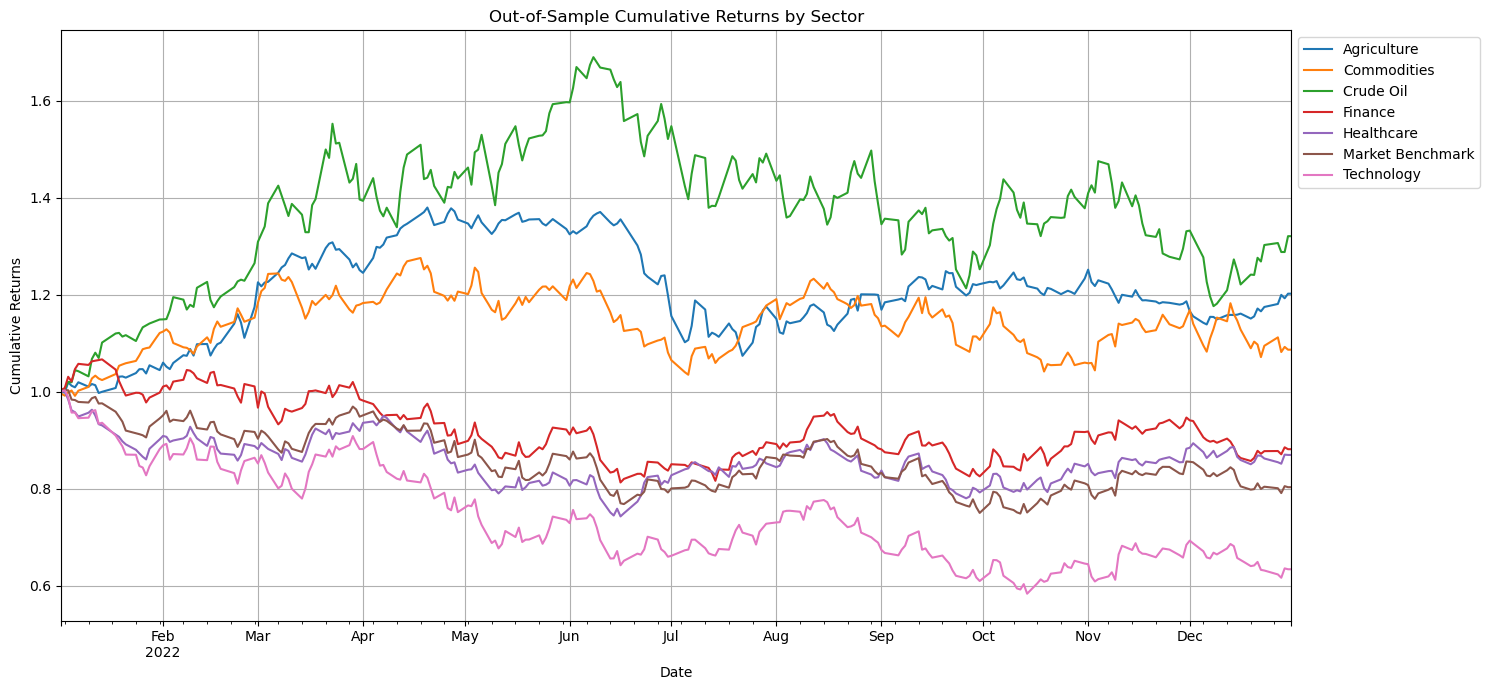

In [11]:
# First, let's create a mapping between tickers and sectors from your dataframe
ticker_to_sector = df.drop_duplicates(subset="Ticker").set_index("Ticker")["Sector"].to_dict()

# Now, let's calculate sector-wise daily returns for the test set
sectors = list(df["Sector"].unique())
sector_daily_returns_test = pd.DataFrame(index=test_returns.index, columns=sectors)

for sector in sectors:
    tickers_in_sector = [ticker for ticker, sec in ticker_to_sector.items() if sec == sector]
    sector_daily_returns_test[sector] = test_returns[tickers_in_sector].mean(axis=1)  # Taking mean of ETFs in the sector

# Calculate cumulative returns for each sector
sector_cumulative_returns_test = (sector_daily_returns_test + 1).cumprod()

# Now, let's visualize the sector-wise performance
plt.figure(figsize=(15,7))
sector_cumulative_returns_test.plot(ax=plt.gca())
plt.title('Out-of-Sample Cumulative Returns by Sector')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()

### Improvements 21_Oct_2023

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_excel('etf_ei_merged_data.xlsx')
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

In [2]:
import pandas as pd

# Load your data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Display the count of distinct unique values for each column
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"{column}: {unique_count} unique values")

Date: 1826 unique values
Open: 27121 unique values
High: 27677 unique values
Low: 27513 unique values
Close: 27231 unique values
Adj Close: 36109 unique values
Volume: 32975 unique values
Sector: 7 unique values
Ticker: 24 unique values
log_return: 42896 unique values
daily_return: 42896 unique values
volatility: 43813 unique values
momentum: 43625 unique values
Direction: 2 unique values
MA_50: 43743 unique values
MA_100: 43775 unique values
MA_200: 43801 unique values
bci: 1826 unique values
cci: 1825 unique values
cli: 1826 unique values
long_term_ir: 1670 unique values
short_term_ir: 1559 unique values


In [4]:
# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Split data based on the provided dates
df_train = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2021-12-31')]
df_test = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]

# Convert data to prices format for pypfopt
prices_train = df_train.pivot(index='Date', columns='Ticker', values='Close')
prices_test = df_test.pivot(index='Date', columns='Ticker', values='Close')

# Evaluate performance on test data
test_returns = prices_test.pct_change().dropna()
portfolio_daily_returns_test = (test_returns * optimized_weights).sum(axis=1)
cumulative_returns_test = (portfolio_daily_returns_test + 1).cumprod()

# Plotting sector performance
plt.figure(figsize=(15,7))
# First, plot the individual ETFs' returns
test_returns.cumprod().plot(ax=plt.gca(), alpha=0.5)  # Reduced alpha for better distinction
cumulativereturns_test.plot(label="Optimized Portfolio", linewidth=2, color='black', alpha=0.8)
plt.title('Out-of-Sample Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'optimized_weights' is not defined

### Model Update 23-10-2023 - focusing on first 5 days

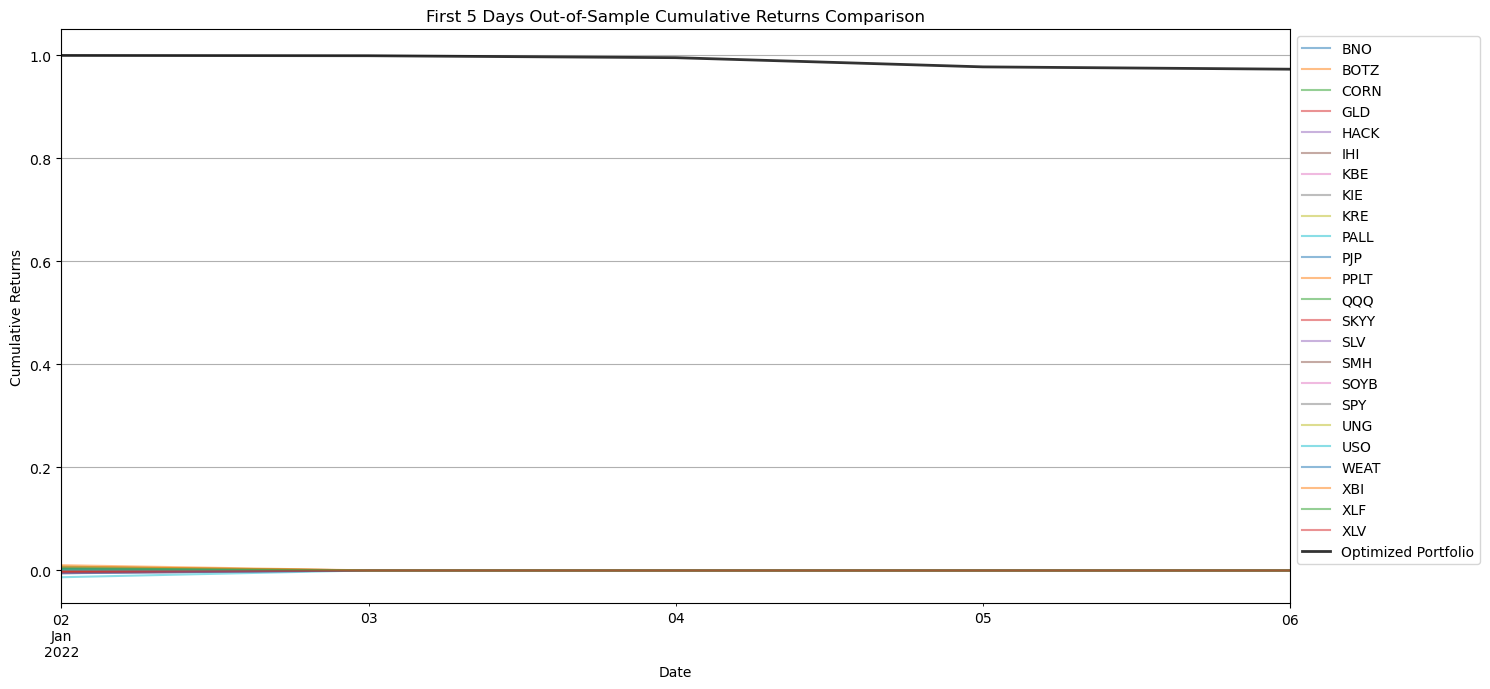


---- Portfolio Performance Metrics for First 5 Days ----
Average Daily Return: -0.55%
Volatility: 0.72%
Sharpe Ratio (with 1% Risk-Free Rate): -2.15
Maximum Drawdown: -2.67%

Potential Future Optimized Weights: OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


In [2]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Split data based on the provided dates
df_train = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2021-12-31')]
df_test = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]

# Convert data to prices format for pypfopt
prices_train = df_train.pivot(index='Date', columns='Ticker', values='Close')
prices_test = df_test.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for training data
mean_returns_train = expected_returns.mean_historical_return(prices_train)
cov_matrix_train = risk_models.sample_cov(prices_train)

# Generate views based on your conditions [the provided conditions remain unchanged]
views = {}

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices_train.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Black-Litterman model setup for training data
bl = BlackLittermanModel(cov_matrix_train, pi=mean_returns_train, absolute_views=Q, P=P)
bl_return = bl.bl_returns()

# ... [Previous code remains unchanged until portfolio optimization]
# Portfolio optimization using Black-Litterman model outputs for the training data
ef = EfficientFrontier(bl_return, cov_matrix_train)
weights = ef.max_sharpe()
optimized_weights = ef.clean_weights()

# Evaluate performance on only the first 5 days of the test data
short_test_returns = prices_test.pct_change().iloc[1:6]
portfolio_short_daily_returns = (short_test_returns * optimized_weights).sum(axis=1)
cumulative_short_returns = (portfolio_short_daily_returns + 1).cumprod()

# Plotting performance for first 5 days
plt.figure(figsize=(15,7))
short_test_returns.cumprod().plot(ax=plt.gca(), alpha=0.5)  # Reduced alpha for clarity
cumulative_short_returns.plot(label="Optimized Portfolio", linewidth=2, color='black', alpha=0.8)
plt.title('First 5 Days Out-of-Sample Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Performance Metrics for first 5 days
average_short_daily_return = portfolio_short_daily_returns.mean()
short_volatility = portfolio_short_daily_returns.std()
short_sharpe_ratio = (average_short_daily_return - 0.01) / short_volatility
rolling_short_max = cumulative_short_returns.cummax()
daily_drawdown_short = cumulative_short_returns/rolling_short_max - 1.0
max_daily_drawdown_short = daily_drawdown_short.cummin()

print("\n---- Portfolio Performance Metrics for First 5 Days ----")
print(f"Average Daily Return: {average_short_daily_return*100:.2f}%")
print(f"Volatility: {short_volatility*100:.2f}%")
print(f"Sharpe Ratio (with 1% Risk-Free Rate): {short_sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_daily_drawdown_short.min()*100:.2f}%")

# ... [Rest of the code remains unchanged for computing potential future weights]
# For the potential future weights considering entire data (2018-2022)
prices_all = pd.concat([prices_train, prices_test])
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)
bl_return_all = bl_all.bl_returns()
bl_return_all = bl_all.bl_returns()
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()  # Compute the optimal weights for all data
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)


### Taking while data as training from 2018 - 2022

In [4]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)

# ...[Keeping the views generation part unchanged]...
# Generate views based on your conditions [the provided conditions remain unchanged]
views = {}

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)
bl_return_all = bl_all.bl_returns()

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)


Potential Future Optimized Weights: OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


### Combining rolling window

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier

# Load and preprocess data
df = pd.read_excel('etf_ei_merged_data.xlsx')
df['Date'] = pd.to_datetime(df['Date'])

# Assuming daily data; change window size as needed
ROLLING_WINDOW_SIZE = 252  # Approx. 1 year of trading days
STEP_SIZE = 21  # Approx. 1 month of trading days

end_dates = df['Date'].iloc[ROLLING_WINDOW_SIZE::STEP_SIZE].tolist()
optimized_weights_list = []

for end_date in end_dates:
    # Define the start date based on the rolling window size
    start_date = end_date - pd.DateOffset(days=ROLLING_WINDOW_SIZE)

    window_data = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]

    # Create the price matrix for the rolling window data
    prices_window = window_data.pivot(index='Date', columns='Ticker', values='Close')

    # Calculate expected returns and sample covariance for the window data
    mean_returns_window = expected_returns.mean_historical_return(prices_window)
    cov_matrix_window = risk_models.sample_cov(prices_window)

    # Your views and Q/P matrices creation process goes here. For the sake of simplicity,
    # I'll assume they stay the same, but in a real-world scenario, they'd be dynamic.
    # Generate views based on your conditions [the provided conditions remain unchanged]
    
    views = {}
    
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['MA_50'] > ticker_data['MA_200']:
            views[ticker] = 0.02
        # Similarly, you can add more conditions based on other indicators
    # Momentum-based views
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['momentum'] > 0:
            views[ticker] = 0.03
        elif ticker_data['momentum'] < 0:
            views[ticker] = -0.03
    
    # Volume-based views (assuming high volume is bullish)
    average_volume = df.groupby('Ticker')['Volume'].mean()
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
            views[ticker] = 0.02
    # BCI-based views
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
            if ticker_data['Sector'] == 'Banking':
                views[ticker] = 0.025
            elif ticker_data['Sector'] == 'Gold':
                views[ticker] = -0.025
    
    # CCI-based views
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
            if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
                views[ticker] = 0.02
    
    # Interest rate views
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
            views[ticker] = 0.015
    
    # Moving average crossover views
    for ticker in df['Ticker'].unique():
        recent_data = df[df['Ticker'] == ticker].tail(2)
        if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
            views[ticker] = 0.03  # Golden cross
        elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
            views[ticker] = -0.03  # Death cross
    
            # Momentum-Volatility combination
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
            views[ticker] = 0.025
    
    # Interest Rate Differential
    yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
    if yield_curve < 0:
        # Negative yield curve, typically bearish for the market
        for ticker in df['Ticker'].unique():
            views[ticker] = -0.02
    
    # BCI and CCI combination
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
            views[ticker] = 0.03
    
    # Moving Average Crossover with Momentum
    for ticker in df['Ticker'].unique():
        recent_data = df[df['Ticker'] == ticker].tail(2)
        if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
            views[ticker] = 0.04  # Enhanced golden cross view
        elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
            views[ticker] = -0.04  # Enhanced death cross view
    
    
    # MA Confluence
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
            views[ticker] = 0.03
        elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
            views[ticker] = -0.03
    
    # Economic Stress Test
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
            views[ticker] = -0.04
    
    # High Volume and Momentum
    average_volume = df['Volume'].mean()
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
            views[ticker] = 0.03
    
    # Economic Optimism with Technical Support
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
            views[ticker] = 0.04
    
    
    # Calculating averages for economic indicators
    avg_bci = df['bci'].mean()
    avg_cci = df['cci'].mean()
    avg_cli = df['cli'].mean()
    
    # Economic Momentum Confluence
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
            views[ticker] = 0.05
        elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
            views[ticker] = -0.05
    
    # Economic Resilience with Technical Support
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
            views[ticker] = 0.04
    
    # Interest Rate Spread and Volume
    avg_volume = df['Volume'].mean()
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
            views[ticker] = -0.04
    
    # High Momentum with Economic Downturn
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].iloc[-1]
        if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
            views[ticker] = -0.03
            
    latest_values = df.groupby('Ticker').last()
    
    # View 1: CLI & Finance
    finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
    for ticker in finance_etfs:
        if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
            views[ticker] = 0.03
    
    # View 2: CCI & Technology
    tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
    for ticker in tech_etfs:
        if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
            views[ticker] = 0.04
    
    # View 3: Volatility & Finance
    for ticker in finance_etfs:
        if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
            views[ticker] = -0.02
    
    # View 4: Momentum & Technology
    for ticker in tech_etfs:
        if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
    
            # View 1: Interplay between Interest Rates
    for ticker in df['Ticker'].unique():
        if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
            if 'Gold' in ticker or ticker == 'GLD':
                views[ticker] = 0.05
            if ticker in finance_etfs:
                views[ticker] = -0.04
    
    # View 2: High Momentum and CCI
    for ticker in tech_etfs:
        if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
            views[ticker] = 0.06
    
    # View 3: Volatility, CCI, and SPY
    if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
        views['SPY'] = 0.04
    
    # View 4: Momentum and MAs for Finance
    for ticker in finance_etfs:
        if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
    # View 5: CLI and Market Benchmark
    if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
        views['SPY'] = 0.03
    
    # View 6: CCI and Sector Analysis
    for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
        if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
            views[ticker] = 0.04
    
    # View 7: Volume as Sentiment Indicator
    for ticker in df['Ticker'].unique():
        if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
            if latest_values.loc[ticker, 'momentum'] > 0:
                views[ticker] = 0.03
            else:
                views[ticker] = -0.03
    
    # View 8: Momentum & Volatility for Safe Havens
    if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
        views['GLD'] = 0.04
    
    # View 9: Interest Rates and Financial Sector
    if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
        views['XLF'] = 0.04
    
    # View 10: Volatility and Safe Havens
    if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
        views['GLD'] = 0.03
    
    # View 11: CCI and Technology
    if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
        views['QQQ'] = 0.04
    
    # View 12: Momentum and Volume Play
    for ticker in df['Ticker'].unique():
        if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
            views[ticker] = 0.03
            
    # View 13: CLI and Broader Market
    if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
        views['SPY'] = 0.05
    
    # View 14: CCI and Tech Sector
    monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
    if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
        views['SKYY'] = 0.06
    
    # View 15: Momentum vs Volatility Interplay
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker]
        if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
            views[ticker] = -0.03
    
    # View 16: Short-term Interest Rates and Banking
    if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
        views['KRE'] = 0.04
    
    # Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
    if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
        for ticker in df['Ticker'].unique():
            views[ticker] = 0.015
    
    Q = pd.Series(views)
    P = pd.DataFrame(0, index=Q.index, columns=prices_window.columns)
    for ticker in Q.index:
        P.loc[ticker, ticker] = 1

    # Black-Litterman model setup for the window data
    bl = BlackLittermanModel(cov_matrix_window, pi=mean_returns_window, absolute_views=Q, P=P)
    bl_return = bl.bl_returns()

    # Portfolio optimization using Black-Litterman model outputs for the window
    ef = EfficientFrontier(bl_return, cov_matrix_window)
    weights = ef.max_sharpe()  # This line computes the optimal weights
    optimized_weights = ef.clean_weights()

    optimized_weights_list.append(optimized_weights)

# The last set of optimized weights from the rolling windows is what you'd use for the next period
final_optimized_weights = optimized_weights_list[-1]
print("\nOptimized Weights for the End of Train Data:", final_optimized_weights)


Optimized Weights for the End of Train Data: OrderedDict([('BNO', 0.0), ('BOTZ', 0.0), ('CORN', 0.0), ('GLD', 0.0), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 1.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.0), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


### Update for final output


Posterior Expected Returns:
 Ticker
BNO     0.054915
BOTZ   -0.040328
CORN    0.035568
GLD     0.027386
HACK    0.018906
IHI     0.048531
KBE    -0.007699
KIE     0.028221
KRE     0.002097
PALL    0.027121
PJP     0.007923
PPLT   -0.002993
QQQ     0.037601
SKYY    0.002358
SLV     0.015558
SMH     0.060708
SOYB    0.034743
SPY     0.023419
UNG    -0.033770
USO    -0.043724
WEAT    0.014361
XBI    -0.020764
XLF     0.010618
XLV     0.038296
dtype: float64


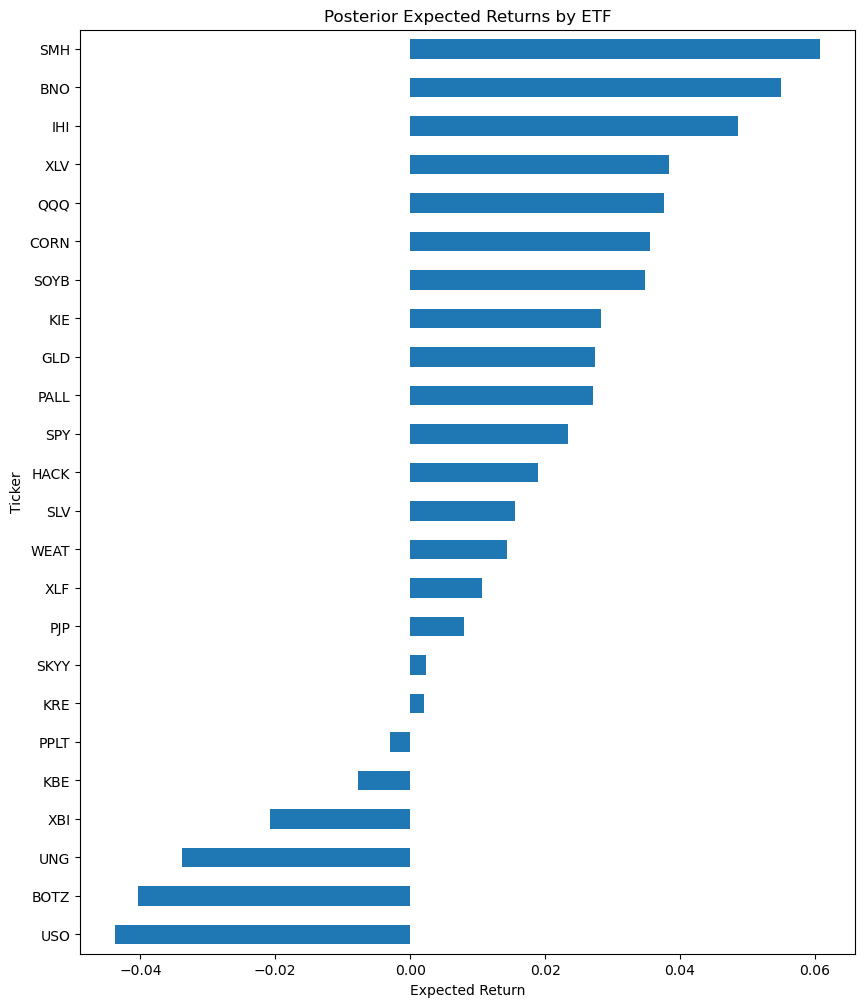


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.265994
BOTZ    0.220427
CORN    0.149927
GLD     0.101970
HACK    0.191976
IHI     0.170961
KBE     0.250129
KIE     0.191532
KRE     0.257686
PALL    0.294336
PJP     0.157727
PPLT    0.204218
QQQ     0.179659
SKYY    0.228037
SLV     0.194873
SMH     0.264233
SOYB    0.134569
SPY     0.137992
UNG     0.366702
USO     0.293499
WEAT    0.198373
XBI     0.256893
XLF     0.172146
XLV     0.131413
dtype: float64


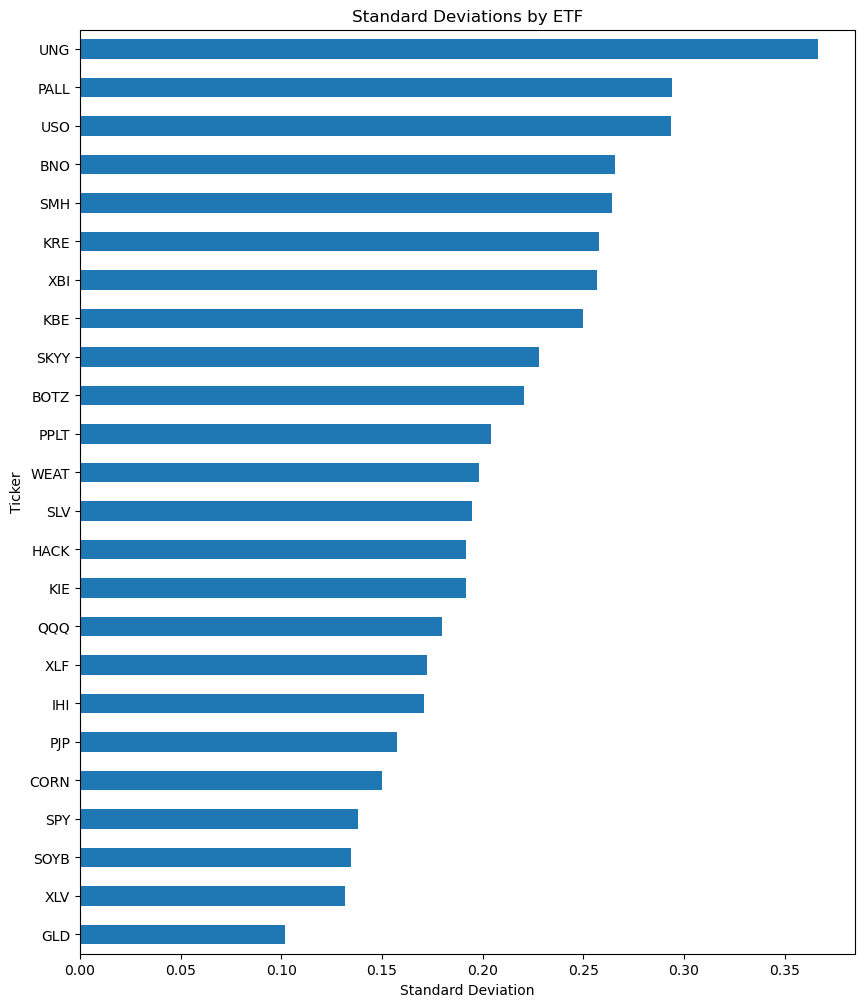


Potential Future Optimized Weights: OrderedDict([('BNO', 0.13398), ('BOTZ', 0.0), ('CORN', 0.17343), ('GLD', 0.15598), ('HACK', 0.0), ('IHI', 0.29628), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.09124), ('SOYB', 0.1491), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


In [2]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)

# ...[Keeping the views generation part unchanged]...
# Generate views based on your conditions [the provided conditions remain unchanged]
views = {}

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        views[ticker] = 0.02
    # Similarly, you can add more conditions based on other indicators
# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        views[ticker] = 0.03
    elif ticker_data['momentum'] < 0:
        views[ticker] = -0.03

# Volume-based views (assuming high volume is bullish)
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        views[ticker] = 0.02
# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Banking':
            views[ticker] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            views[ticker] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:  # Assuming 100 is the neutral mark
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            views[ticker] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        views[ticker] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        views[ticker] = 0.03  # Golden cross
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        views[ticker] = -0.03  # Death cross

        # Momentum-Volatility combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['volatility'] > df[df['Ticker'] == ticker]['volatility'].mean():
        views[ticker] = 0.025

# Interest Rate Differential
yield_curve = df.iloc[-1]['long_term_ir'] - df.iloc[-1]['short_term_ir']
if yield_curve < 0:
    # Negative yield curve, typically bearish for the market
    for ticker in df['Ticker'].unique():
        views[ticker] = -0.02

# BCI and CCI combination
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100:
        views[ticker] = 0.03

# Moving Average Crossover with Momentum
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] > 0:
        views[ticker] = 0.04  # Enhanced golden cross view
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200'] and recent_data.iloc[1]['momentum'] < 0:
        views[ticker] = -0.04  # Enhanced death cross view


# MA Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_100'] > ticker_data['MA_200']:
        views[ticker] = 0.03
    elif ticker_data['MA_50'] < ticker_data['MA_100'] < ticker_data['MA_200']:
        views[ticker] = -0.03

# Economic Stress Test
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] < 100 and ticker_data['cci'] < 100 and ticker_data['short_term_ir'] > ticker_data['long_term_ir']:
        views[ticker] = -0.04

# High Volume and Momentum
average_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and ticker_data['Volume'] > 1.5 * average_volume:
        views[ticker] = 0.03

# Economic Optimism with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100 and ticker_data['cci'] > 100 and ticker_data['Close'] > ticker_data['MA_200']:
        views[ticker] = 0.04


# Calculating averages for economic indicators
avg_bci = df['bci'].mean()
avg_cci = df['cci'].mean()
avg_cli = df['cli'].mean()

# Economic Momentum Confluence
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if (ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['cli'] > avg_cli) and ticker_data['momentum'] > 0:
        views[ticker] = 0.05
    elif (ticker_data['bci'] < avg_bci and ticker_data['cci'] < avg_cci and ticker_data['cli'] < avg_cli) and ticker_data['momentum'] < 0:
        views[ticker] = -0.05

# Economic Resilience with Technical Support
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > avg_bci and ticker_data['cci'] > avg_cci and ticker_data['Close'] > ticker_data[['MA_50', 'MA_100', 'MA_200']].max():
        views[ticker] = 0.04

# Interest Rate Spread and Volume
avg_volume = df['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['short_term_ir'] > ticker_data['long_term_ir'] and ticker_data['Volume'] > 1.2 * avg_volume:
        views[ticker] = -0.04

# High Momentum with Economic Downturn
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0 and (ticker_data['bci'] < avg_bci or ticker_data['cci'] < avg_cci or ticker_data['cli'] < avg_cli):
        views[ticker] = -0.03
        
latest_values = df.groupby('Ticker').last()

# View 1: CLI & Finance
finance_etfs = df[df['Sector'] == 'Finance']['Ticker'].unique()
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'cli'] > df[df['Ticker'] == ticker]['cli'].median():
        views[ticker] = 0.03

# View 2: CCI & Technology
tech_etfs = df[df['Sector'] == 'Technology']['Ticker'].unique()
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean() + 0.5 * df[df['Ticker'] == ticker]['cci'].std():
        views[ticker] = 0.04

# View 3: Volatility & Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'volatility'] > df[df['Ticker'] == ticker]['volatility'].quantile(0.75):
        views[ticker] = -0.02

# View 4: Momentum & Technology
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].median() and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03

        # View 1: Interplay between Interest Rates
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'short_term_ir'] > latest_values.loc[ticker, 'long_term_ir']:
        if 'Gold' in ticker or ticker == 'GLD':
            views[ticker] = 0.05
        if ticker in finance_etfs:
            views[ticker] = -0.04

# View 2: High Momentum and CCI
for ticker in tech_etfs:
    if latest_values.loc[ticker, 'momentum'] > df[df['Ticker'] == ticker]['momentum'].quantile(0.90) and latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.06

# View 3: Volatility, CCI, and SPY
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75) and latest_values.loc['SPY', 'cci'] > df[df['Ticker'] == 'SPY']['cci'].mean():
    views['SPY'] = 0.04

# View 4: Momentum and MAs for Finance
for ticker in finance_etfs:
    if latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_50'] and latest_values.loc[ticker, 'Close'] > latest_values.loc[ticker, 'MA_200'] and latest_values.loc[ticker, 'momentum'] > 0:
        views[ticker] = 0.03
# View 5: CLI and Market Benchmark
if latest_values.loc['SPY', 'cli'] > df[df['Ticker'] == 'SPY']['cli'].mean() and df[df['Ticker'] == 'SPY']['cli'].diff().iloc[-5:].mean() > 0:
    views['SPY'] = 0.03

# View 6: CCI and Sector Analysis
for ticker in ['QQQ', 'XLF']:  # Sample ETFs for technology and finance
    if latest_values.loc[ticker, 'cci'] > df[df['Ticker'] == ticker]['cci'].mean():
        views[ticker] = 0.04

# View 7: Volume as Sentiment Indicator
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].quantile(0.90):
        if latest_values.loc[ticker, 'momentum'] > 0:
            views[ticker] = 0.03
        else:
            views[ticker] = -0.03

# View 8: Momentum & Volatility for Safe Havens
if latest_values.loc['GLD', 'momentum'] > 0 and latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].quantile(0.75):
    views['GLD'] = 0.04

# View 9: Interest Rates and Financial Sector
if latest_values.loc['XLF', 'long_term_ir'] > df[df['Ticker'] == 'XLF']['long_term_ir'].tail(90).mean():
    views['XLF'] = 0.04

# View 10: Volatility and Safe Havens
if latest_values.loc['SPY', 'volatility'] > df[df['Ticker'] == 'SPY']['volatility'].median():
    views['GLD'] = 0.03

# View 11: CCI and Technology
if latest_values.loc['QQQ', 'cci'] > df[df['Ticker'] == 'QQQ']['cci'].mean() and df[df['Ticker'] == 'QQQ']['cci'].diff().iloc[-30:].mean() > 0:
    views['QQQ'] = 0.04

# View 12: Momentum and Volume Play
for ticker in df['Ticker'].unique():
    if latest_values.loc[ticker, 'momentum'] > 0 and latest_values.loc[ticker, 'Volume'] > df[df['Ticker'] == ticker]['Volume'].tail(30).mean():
        views[ticker] = 0.03
        
# View 13: CLI and Broader Market
if df[df['Ticker'] == 'SPY']['cli'].tail(180).mean() > df[df['Ticker'] == 'SPY']['cli'].tail(360).mean():
    views['SPY'] = 0.05

# View 14: CCI and Tech Sector
monthly_cci_rate = df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).iloc[-1]
if monthly_cci_rate > df[df['Ticker'] == 'SKYY']['cci'].diff(periods=30).mean():
    views['SKYY'] = 0.06

# View 15: Momentum vs Volatility Interplay
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    if ticker_df['momentum'].iloc[-1] > ticker_df['momentum'].quantile(0.9) and ticker_df['volatility'].iloc[-1] > ticker_df['volatility'].quantile(0.9):
        views[ticker] = -0.03

# View 16: Short-term Interest Rates and Banking
if df[df['Ticker'] == 'KRE']['short_term_ir'].tail(90).mean() > df[df['Ticker'] == 'KRE']['short_term_ir'].tail(180).mean():
    views['KRE'] = 0.04

# Interest rate views (just an example: bullish on all ETFs if short term rates are rising)
if df.iloc[-1]['short_term_ir'] > df.iloc[-30]['short_term_ir']:
    for ticker in df['Ticker'].unique():
        views[ticker] = 0.015

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
import numpy as np

# Load data
# ... [rest of the code stays unchanged till Q and P matrices] ...

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

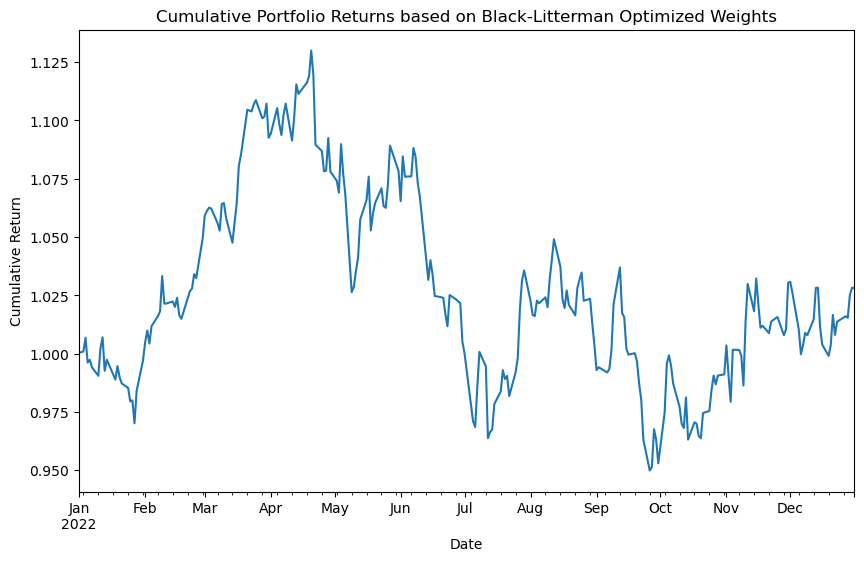

In [3]:
# Assuming the data is already loaded as 'df' and in the structure you provided earlier
import numpy as np

# Split the data into a training set and a test set
train_size = int(0.8 * len(df['Date'].unique()))
train_data = df[df['Date'] < df['Date'].unique()[train_size]]
test_data = df[df['Date'] >= df['Date'].unique()[train_size]]

# Assume the prices_all variable and future_optimized_weights dictionary from your provided code are available
test_prices = test_data.pivot(index='Date', columns='Ticker', values='Close')
daily_returns = test_prices.pct_change().dropna()

# Compute portfolio returns with the optimized weights
portfolio_returns = daily_returns.dot(np.array([future_optimized_weights[ticker] for ticker in daily_returns.columns]))

# Plot cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title("Cumulative Portfolio Returns based on Black-Litterman Optimized Weights")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

In [4]:
# Create a function that encapsulates the Black-Litterman model given views
def get_bl_weights(views):
    Q = pd.Series(views)
    P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
    for ticker in Q.index:
        P.loc[ticker, ticker] = 1

    bl_model = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)
    bl_returns = bl_model.bl_returns()
    ef = EfficientFrontier(bl_returns, cov_matrix_all)
    return ef.max_sharpe()

# Slight variations in views
views_adjusted = {ticker: return_ * 1.05 for ticker, return_ in views.items()} # Here, we increased views by 5% as a test

weights_original = get_bl_weights(views)
weights_adjusted = get_bl_weights(views_adjusted)

# Compare the weights
differences = {ticker: weights_adjusted[ticker] - weights_original[ticker] for ticker in weights_original}
print(differences)

{'BNO': -0.003418742449359996, 'BOTZ': 0.0, 'CORN': -0.0003315409292656002, 'GLD': 0.008257530226503385, 'HACK': 0.0, 'IHI': -0.0030001771044658176, 'KBE': 0.0, 'KIE': 0.0, 'KRE': 0.0, 'PALL': 0.0, 'PJP': 0.0, 'PPLT': 0.0, 'QQQ': 0.0, 'SKYY': 0.0, 'SLV': 0.0, 'SMH': -0.0023310145047445024, 'SOYB': 0.0008239447613324902, 'SPY': 0.0, 'UNG': 0.0, 'USO': 0.0, 'WEAT': 0.0, 'XBI': 0.0, 'XLF': 0.0, 'XLV': 0.0}


### Another update by weightage, views addition and signal before combining.


Posterior Expected Returns:
 Ticker
BNO     0.062588
BOTZ   -0.067903
CORN    0.058995
GLD     0.046868
HACK   -0.010178
IHI     0.023104
KBE    -0.043028
KIE     0.001301
KRE    -0.034447
PALL    0.017478
PJP    -0.012915
PPLT    0.017522
QQQ     0.010240
SKYY   -0.032453
SLV     0.042069
SMH     0.027454
SOYB    0.056740
SPY     0.001796
UNG    -0.047413
USO    -0.032670
WEAT    0.041652
XBI    -0.041713
XLF    -0.013734
XLV     0.019877
dtype: float64


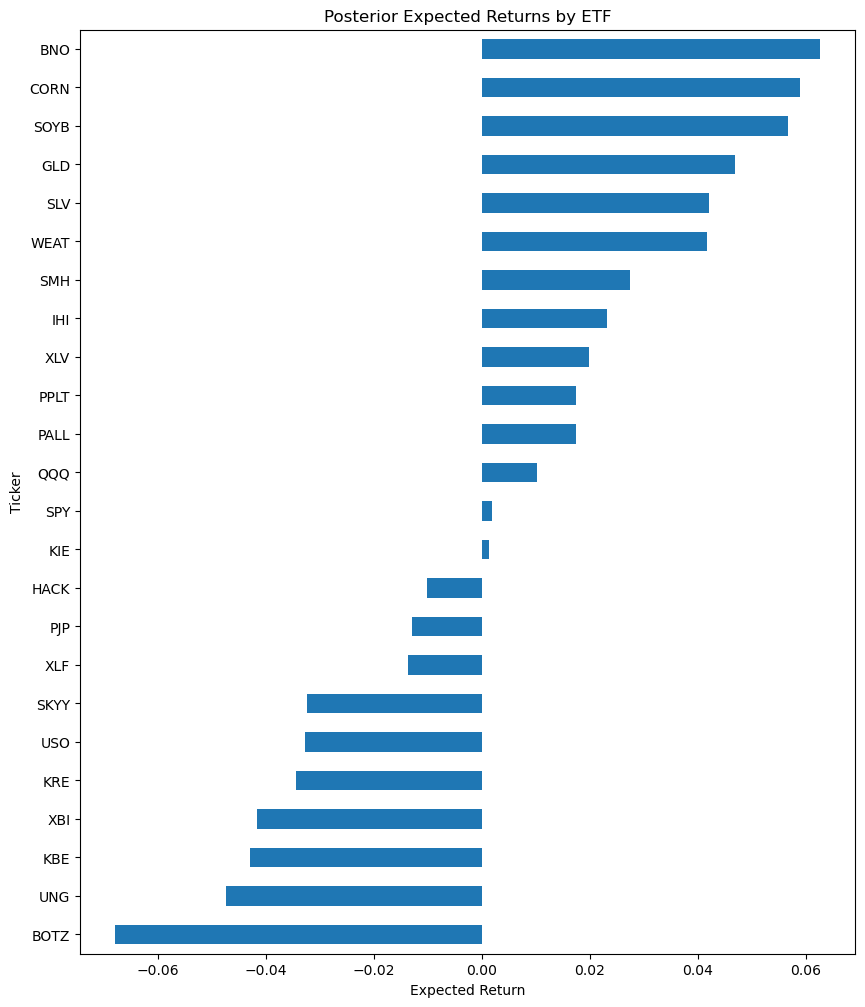


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.265994
BOTZ    0.220427
CORN    0.149927
GLD     0.101970
HACK    0.191976
IHI     0.170961
KBE     0.250129
KIE     0.191532
KRE     0.257686
PALL    0.294336
PJP     0.157727
PPLT    0.204218
QQQ     0.179659
SKYY    0.228037
SLV     0.194873
SMH     0.264233
SOYB    0.134569
SPY     0.137992
UNG     0.366702
USO     0.293499
WEAT    0.198373
XBI     0.256893
XLF     0.172146
XLV     0.131413
dtype: float64


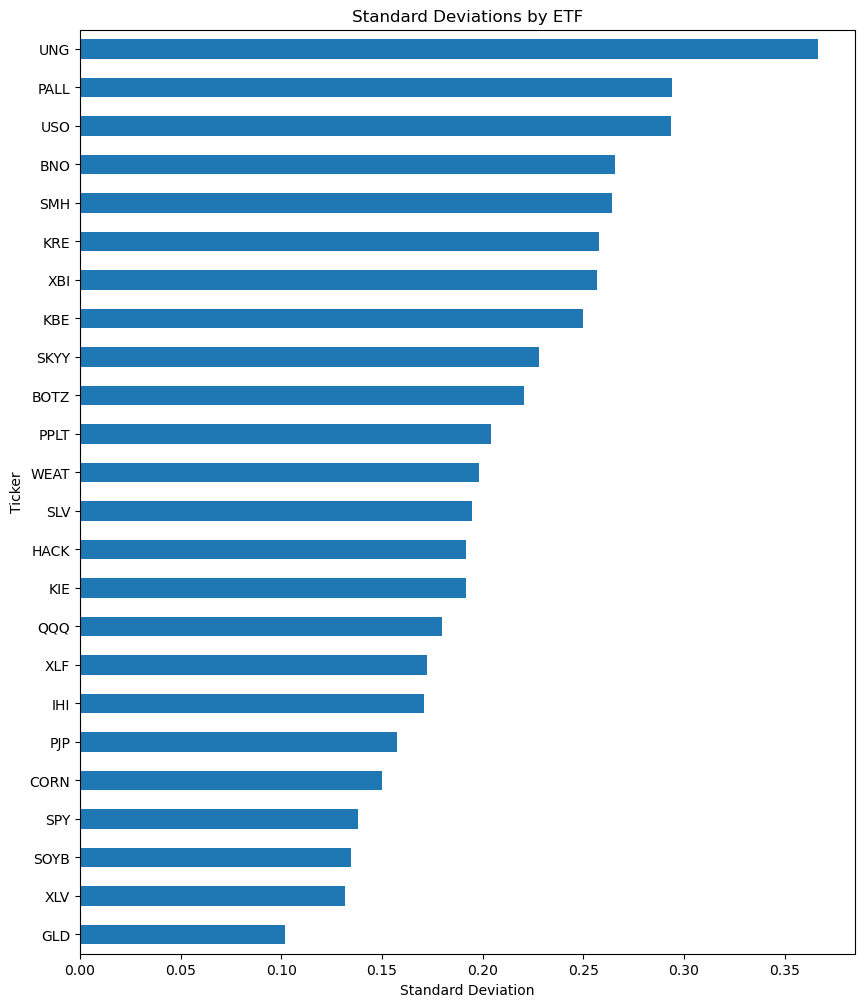


Potential Future Optimized Weights: OrderedDict([('BNO', 0.0707), ('BOTZ', 0.0), ('CORN', 0.21318), ('GLD', 0.49207), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.22406), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


In [8]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)


combined_views = defaultdict(float)
signal_views = defaultdict(dict)

# Moving Average Signal
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        signal_views[ticker]['ma_signal'] = 0.02

# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        signal_views[ticker]['momentum_signal'] = 0.03
    elif ticker_data['momentum'] < 0:
        signal_views[ticker]['momentum_signal'] = -0.03

# Volume-based views
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        signal_views[ticker]['volume_signal'] = 0.02

# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            signal_views[ticker]['bci_signal_banking'] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            signal_views[ticker]['bci_signal_gold'] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            signal_views[ticker]['cci_signal'] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        signal_views[ticker]['ir_signal'] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = 0.03
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = -0.03

def ma_signal(ticker_data):
    return 0.02 if ticker_data['MA_50'] > ticker_data['MA_200'] else 0

def momentum_signal(ticker_data):
    if ticker_data['momentum'] > 0:
        return 0.03
    elif ticker_data['momentum'] < 0:
        return -0.03
    return 0

def volume_signal(ticker_data, average_volume):
    return 0.02 if ticker_data['Volume'] > 1.5 * average_volume else 0

def bci_signal(ticker_data):
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            return 0.025
        elif ticker_data['Sector'] == 'Gold':
            return -0.025
    return 0

def cci_signal(ticker_data):
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        return 0.02
    return 0

def ir_signal(ticker_data, df):
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        if ticker_data['Sector'] == 'Banking':
            return 0.015
    return 0

# ... Continue for all your views in a similar fashion ...

# Applying the views on the dataframe
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    
    average_volume = df[df['Ticker'] == ticker]['Volume'].mean()
    
    signal_views[ticker]['ma_signal'] = ma_signal(ticker_data)
    signal_views[ticker]['momentum_signal'] = momentum_signal(ticker_data)
    signal_views[ticker]['volume_signal'] = volume_signal(ticker_data, average_volume)
    signal_views[ticker]['bci_signal'] = bci_signal(ticker_data)
    signal_views[ticker]['cci_signal'] = cci_signal(ticker_data)
    signal_views[ticker]['ir_signal'] = ir_signal(ticker_data, df)
    
    # ... Apply the rest of your views in a similar fashion ...

# Combine views
for ticker, views_dict in signal_views.items():
    combined_view = sum(views_dict.values())
    combined_views[ticker] = combined_view

# Capping views
MAX_VIEW = 0.05
MIN_VIEW = -0.05
for ticker, view in combined_views.items():
    if view > MAX_VIEW:
        combined_views[ticker] = MAX_VIEW
    elif view < MIN_VIEW:
        combined_views[ticker] = MIN_VIEW


# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(combined_views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Load data
# ... [rest of the code stays unchanged till Q and P matrices] ...

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in combined_views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

In [ ]:
To validate and evaluate the performance of your portfolio on the 2023 test data:

Portfolio Construction for 2023
Portfolio Returns for 2023
Performance Metrics
Benchmark Comparison
Validation of Views
Backtest without Views (placeholder)
Visualizations
Diagnostics


Posterior Expected Returns:
 Ticker
BNO     0.062588
BOTZ   -0.067903
CORN    0.058995
GLD     0.046868
HACK   -0.010178
IHI     0.023104
KBE    -0.043028
KIE     0.001301
KRE    -0.034447
PALL    0.017478
PJP    -0.012915
PPLT    0.017522
QQQ     0.010240
SKYY   -0.032453
SLV     0.042069
SMH     0.027454
SOYB    0.056740
SPY     0.001796
UNG    -0.047413
USO    -0.032670
WEAT    0.041652
XBI    -0.041713
XLF    -0.013734
XLV     0.019877
dtype: float64


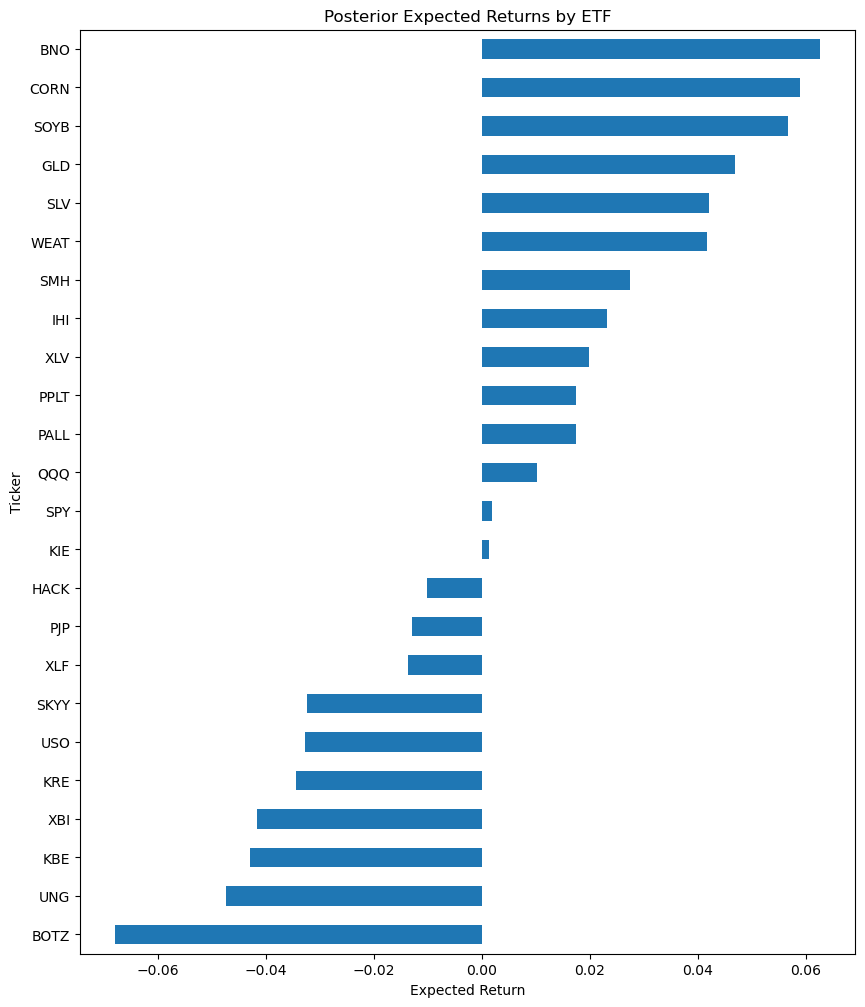


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.265994
BOTZ    0.220427
CORN    0.149927
GLD     0.101970
HACK    0.191976
IHI     0.170961
KBE     0.250129
KIE     0.191532
KRE     0.257686
PALL    0.294336
PJP     0.157727
PPLT    0.204218
QQQ     0.179659
SKYY    0.228037
SLV     0.194873
SMH     0.264233
SOYB    0.134569
SPY     0.137992
UNG     0.366702
USO     0.293499
WEAT    0.198373
XBI     0.256893
XLF     0.172146
XLV     0.131413
dtype: float64


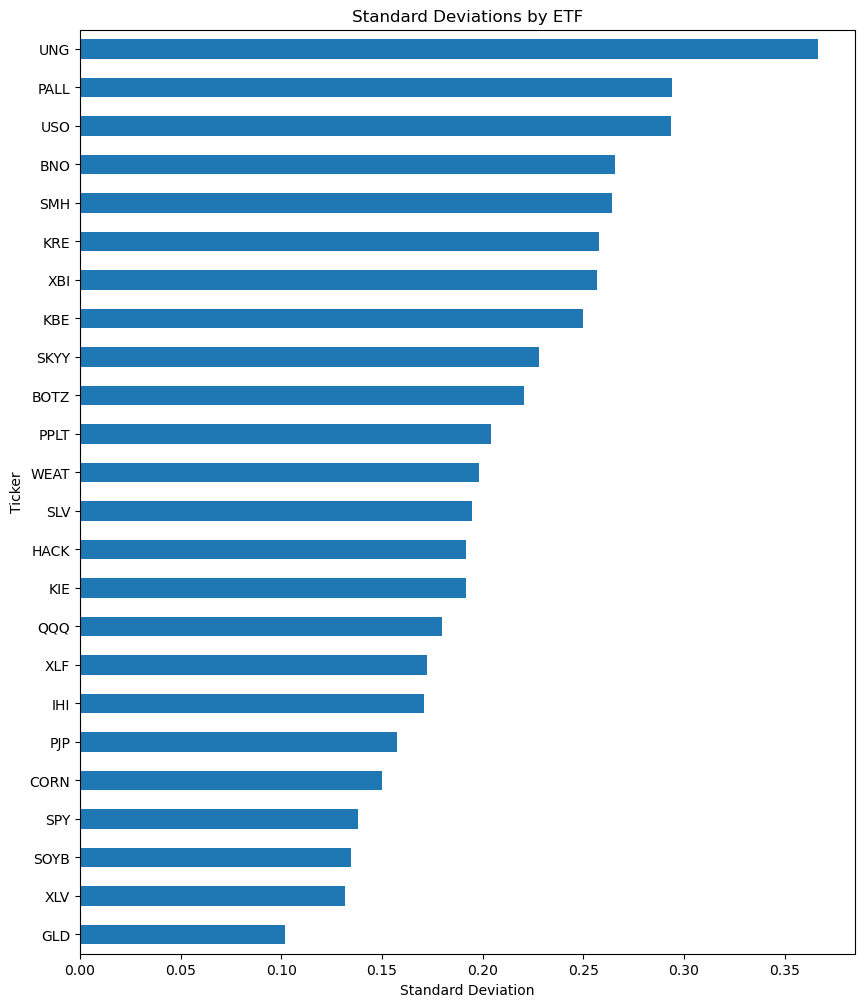


Potential Future Optimized Weights: OrderedDict([('BNO', 0.0707), ('BOTZ', 0.0), ('CORN', 0.21318), ('GLD', 0.49207), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.22406), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


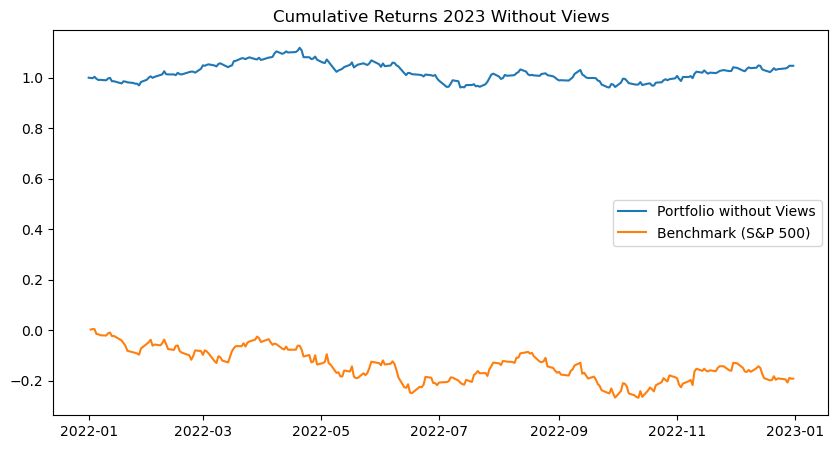


Performance Metrics for 2023 without Views:
Total Return: 4.72%
Sharpe Ratio: 0.02
Max Drawdown: -14.07%
Volatility: 0.61%


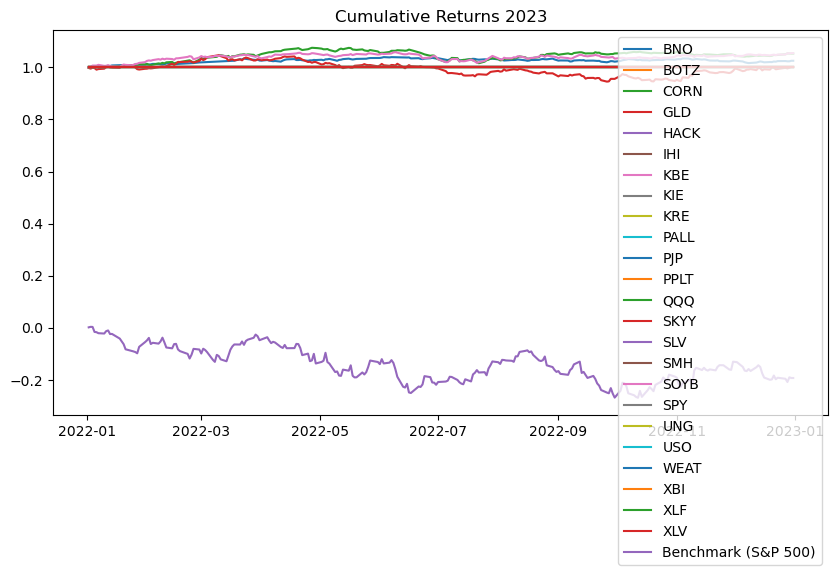

Assets that diverged significantly from views: ['BNO', 'BOTZ', 'CORN', 'HACK', 'IHI', 'KBE', 'KRE', 'PPLT', 'QQQ', 'SKYY', 'SMH', 'SOYB', 'SPY', 'UNG', 'USO', 'XBI']

Performance Metrics for 2023:
Total Return: 2313.27%
Sharpe Ratio: 0.06
Max Drawdown: -0.66%
Volatility: 0.66%

Benchmark Comparison (SPY):
Total Return: -19.26%
Sharpe Ratio: -2.22

View Validation Metrics:
Accuracy: 16.67%
Precision: 44.44%


In [4]:
# CAUTION NOTE: 2023, but for testing taking only 2022 starting phase

import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)


combined_views = defaultdict(float)
signal_views = defaultdict(dict)

# Moving Average Signal
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        signal_views[ticker]['ma_signal'] = 0.02

# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        signal_views[ticker]['momentum_signal'] = 0.03
    elif ticker_data['momentum'] < 0:
        signal_views[ticker]['momentum_signal'] = -0.03

# Volume-based views
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        signal_views[ticker]['volume_signal'] = 0.02

# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            signal_views[ticker]['bci_signal_banking'] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            signal_views[ticker]['bci_signal_gold'] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100:
        if ticker_data['Sector'] == 'Retail' or ticker_data['Sector'] == 'Technology':
            signal_views[ticker]['cci_signal'] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        signal_views[ticker]['ir_signal'] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = 0.03
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = -0.03

def ma_signal(ticker_data):
    return 0.02 if ticker_data['MA_50'] > ticker_data['MA_200'] else 0

def momentum_signal(ticker_data):
    if ticker_data['momentum'] > 0:
        return 0.03
    elif ticker_data['momentum'] < 0:
        return -0.03
    return 0

def volume_signal(ticker_data, average_volume):
    return 0.02 if ticker_data['Volume'] > 1.5 * average_volume else 0

def bci_signal(ticker_data):
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            return 0.025
        elif ticker_data['Sector'] == 'Gold':
            return -0.025
    return 0

def cci_signal(ticker_data):
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        return 0.02
    return 0

def ir_signal(ticker_data, df):
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        if ticker_data['Sector'] == 'Banking':
            return 0.015
    return 0

# ... Continue for all your views in a similar fashion ...

# Applying the views on the dataframe
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    
    average_volume = df[df['Ticker'] == ticker]['Volume'].mean()
    
    signal_views[ticker]['ma_signal'] = ma_signal(ticker_data)
    signal_views[ticker]['momentum_signal'] = momentum_signal(ticker_data)
    signal_views[ticker]['volume_signal'] = volume_signal(ticker_data, average_volume)
    signal_views[ticker]['bci_signal'] = bci_signal(ticker_data)
    signal_views[ticker]['cci_signal'] = cci_signal(ticker_data)
    signal_views[ticker]['ir_signal'] = ir_signal(ticker_data, df)
    
    # ... Apply the rest of your views in a similar fashion ...

# Combine views
for ticker, views_dict in signal_views.items():
    combined_view = sum(views_dict.values())
    combined_views[ticker] = combined_view

# Capping views
MAX_VIEW = 0.05
MIN_VIEW = -0.05
for ticker, view in combined_views.items():
    if view > MAX_VIEW:
        combined_views[ticker] = MAX_VIEW
    elif view < MIN_VIEW:
        combined_views[ticker] = MIN_VIEW


# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(combined_views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Load data
# ... [rest of the code stays unchanged till Q and P matrices] ...

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in combined_views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

# Assuming 'prices_2023' is your DataFrame with daily prices of all assets for 2023.
prices_2023 = df[df['Date'].dt.year == 2022].pivot(index='Date', columns='Ticker', values='Close')

# 1. Portfolio Construction for 2023 using the weights optimized using Black-Litterman model outputs
# (You have already computed these as 'future_optimized_weights')

# 2. Calculate Portfolio Returns for 2023:
portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights)
cumulative_returns_2023 = (1 + portfolio_returns_2023).cumprod()

# 3. Performance Metrics:
# total_return_2023 = cumulative_returns_2023.iloc[-1] - 1
# total_return_2023 = cumulative_returns_2023.iloc[-1]
total_return_2023 = cumulative_returns_2023.sum(axis=1).iloc[-1] - 1
# sharpe_ratio_2023 = portfolio_returns_2023.mean() / portfolio_returns_2023.std()
# max_drawdown_2023 = cumulative_returns_2023.div(cumulative_returns_2023.cummax()).min() - 1
# volatility_2023 = portfolio_returns_2023.std()
sharpe_ratio_2023 = portfolio_returns_2023.sum(axis=1).mean() / portfolio_returns_2023.sum(axis=1).std()
max_drawdown_2023 = (cumulative_returns_2023.sum(axis=1) / cumulative_returns_2023.sum(axis=1).cummax() - 1).min()
volatility_2023 = portfolio_returns_2023.sum(axis=1).std()


# 4. Benchmark Comparison (assuming SPY is your benchmark):
benchmark = prices_2023['SPY'].pct_change().cumsum()
benchmark_total_return = benchmark.iloc[-1]
benchmark_sharpe_ratio = benchmark.mean() / benchmark.std()

# 5. Validation of Views:
correct_predictions = sum([
    1 for asset, view in combined_views.items() 
    if asset in portfolio_returns_2023.columns and 
    np.sign(portfolio_returns_2023[asset].sum()) == np.sign(view)
])
accuracy = correct_predictions / len(combined_views)
precision = sum([1 for asset, view in combined_views.items() if view > 0 and portfolio_returns_2023[asset].sum() > 0]) / sum([1 for asset, view in combined_views.items() if view > 0])

# 6. Placeholder for Backtest without Views:
# ... Your implementation ...
############### edit
# 6. Backtest without Views:

# Portfolio Optimization using just historical data
ef_no_views = EfficientFrontier(mean_returns_all, cov_matrix_all)
weights_no_views = ef_no_views.max_sharpe()
cleaned_weights_no_views = ef_no_views.clean_weights()

# Portfolio Returns for 2023 without views
portfolio_returns_no_views_2023 = (prices_2023.pct_change() * pd.Series(cleaned_weights_no_views)).sum(axis=1)
cumulative_returns_no_views_2023 = (1 + portfolio_returns_no_views_2023).cumprod()

# Performance Metrics without views
total_return_no_views_2023 = cumulative_returns_no_views_2023.iloc[-1] - 1
sharpe_ratio_no_views_2023 = portfolio_returns_no_views_2023.mean() / portfolio_returns_no_views_2023.std()
max_drawdown_no_views_2023 = cumulative_returns_no_views_2023.div(cumulative_returns_no_views_2023.cummax()).min() - 1
volatility_no_views_2023 = portfolio_returns_no_views_2023.std()

# Visualization of Backtest without views
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_no_views_2023, label="Portfolio without Views")
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023 Without Views")
plt.legend()
plt.show()

print("\nPerformance Metrics for 2023 without Views:")
print(f"Total Return: {total_return_no_views_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_no_views_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_no_views_2023:.2%}")
print(f"Volatility: {volatility_no_views_2023:.2%}")
################### edit complete

# 7. Visualizations:
plt.figure(figsize=(10, 5))
# plt.plot(cumulative_returns_2023, label="Portfolio")
for col in cumulative_returns_2023.columns:
    plt.plot(cumulative_returns_2023[col], label=col)
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023")
plt.legend()
plt.show()

# 8. Diagnostics:
# Examining assets that performed far from their expected returns
asset_performance = prices_2023.pct_change().sum()
divergence_from_view = {asset: performance - bl_return_all[asset] for asset, performance in asset_performance.items() if asset in combined_views}
assets_to_inspect = [asset for asset, divergence in divergence_from_view.items() if abs(divergence) > 0.1]

print(f"Assets that diverged significantly from views: {assets_to_inspect}")

print("\nPerformance Metrics for 2023:")
print(f"Total Return: {total_return_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_2023:.2%}")
print(f"Volatility: {volatility_2023:.2%}")

print("\nBenchmark Comparison (SPY):")
print(f"Total Return: {benchmark_total_return:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

print("\nView Validation Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")

In [13]:
print(type(cumulative_returns_2023))

<class 'pandas.core.frame.DataFrame'>


In [15]:
# Attempt 1: # Comparing Over Actual Returns

from sklearn.metrics import mean_squared_error, r2_score

# let df = test_df, which is actually FALSE FALSE FLASE
test_df = df

# Compute the daily return for each ticker
test_df['daily_return'] = test_df.groupby('Ticker')['Close'].pct_change()

# Compute the cumulative return for each ticker
test_df['cumulative_return'] = test_df.groupby('Ticker')['daily_return'].transform(lambda x: (1 + x).cumprod())

# Get the last cumulative return for each ticker for the entire year 2023
actual_returns = test_df.groupby('Ticker')['cumulative_return'].last() - 1

# Merge the predicted returns and actual returns for comparison
comparison_df = predictions_df.merge(pd.DataFrame({'Ticker': actual_returns.index, 
                                                   'Actual_Return': actual_returns.values}),
                                     on='Ticker')

mse = mean_squared_error(comparison_df['Actual_Return'], comparison_df['Predicted_Return'])
print(f"Mean Squared Error: {mse}")

r2 = r2_score(comparison_df['Actual_Return'], comparison_df['Predicted_Return'])
print(f"R-squared: {r2}")

Mean Squared Error: 0.21585939408119534
R-squared: -0.843847225369083


In [ ]:
""" Notes: The relatively high MSE suggests that the model's predictions are quite off from the actual returns.
The negative R-squared indicates that the model is underperforming even a simple average model. """

#### Actual vs Predicted Plot

C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


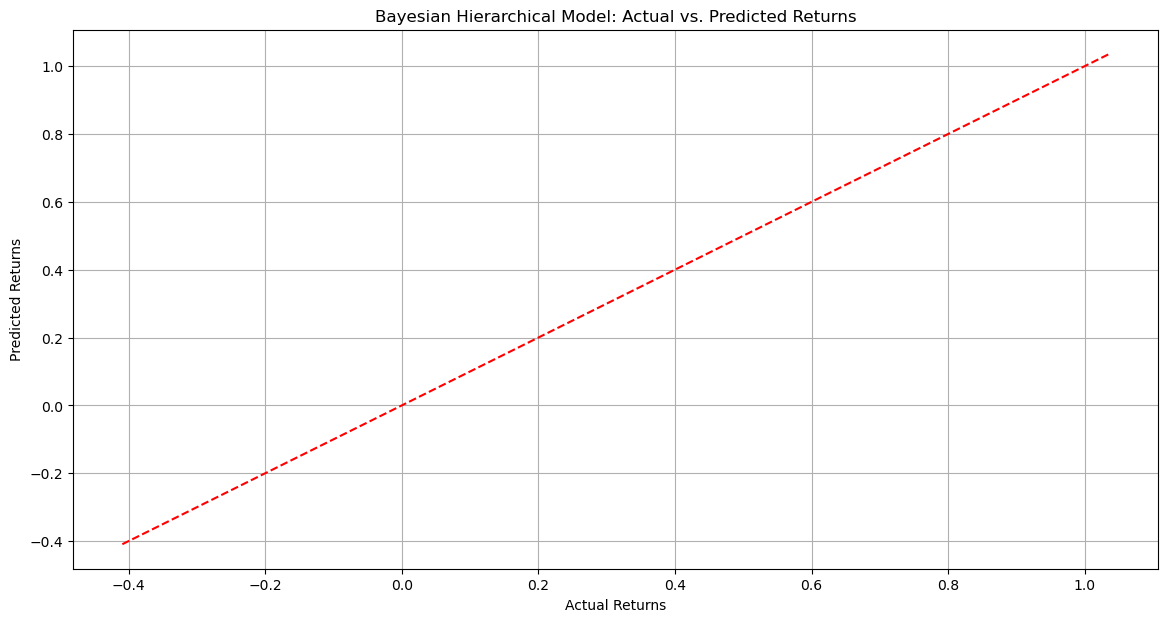

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# For the Bayesian Hierarchical Model:
plt.figure(figsize=(14, 7))
sns.scatterplot(x=actual_returns, y=predictions_df['Predicted_Return'])
plt.plot([min(actual_returns), max(actual_returns)], [min(actual_returns), max(actual_returns)], color='red', linestyle='--')
plt.title("Bayesian Hierarchical Model: Actual vs. Predicted Returns")
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.grid(True)
plt.show()

#### Residual Analysis

C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\saide\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


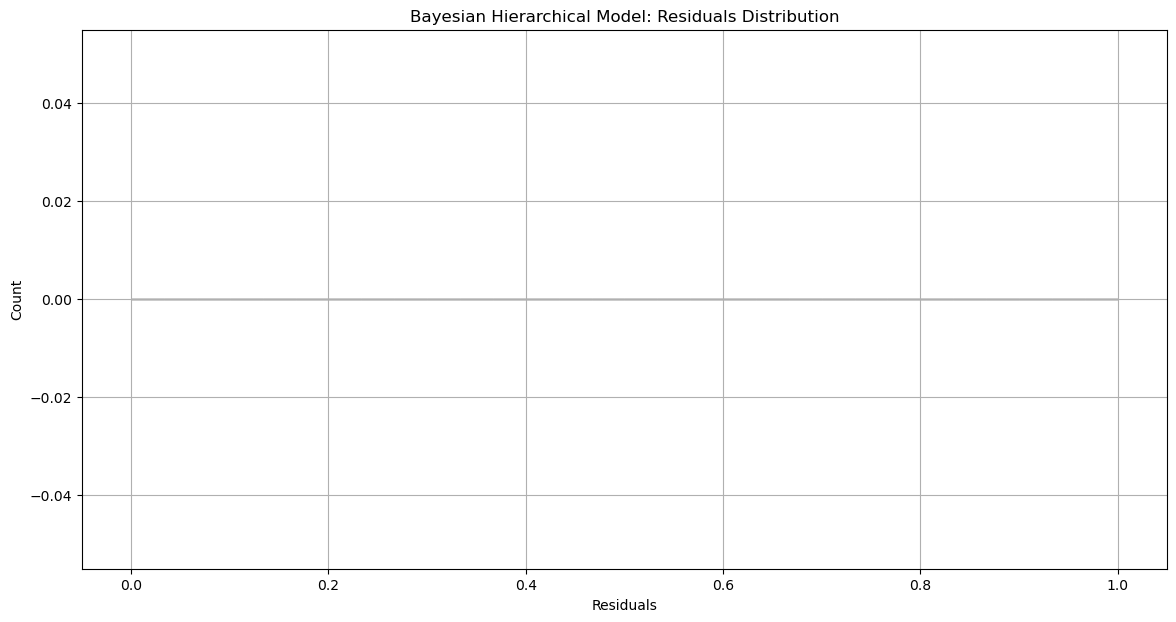

In [18]:
# Calculate residuals for both models
residuals_bhm = actual_returns - predictions_df['Predicted_Return']

# Residuals histogram for Bayesian Hierarchical Model
plt.figure(figsize=(14, 7))
sns.histplot(residuals_bhm, bins=30, kde=True)
plt.title("Bayesian Hierarchical Model: Residuals Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()

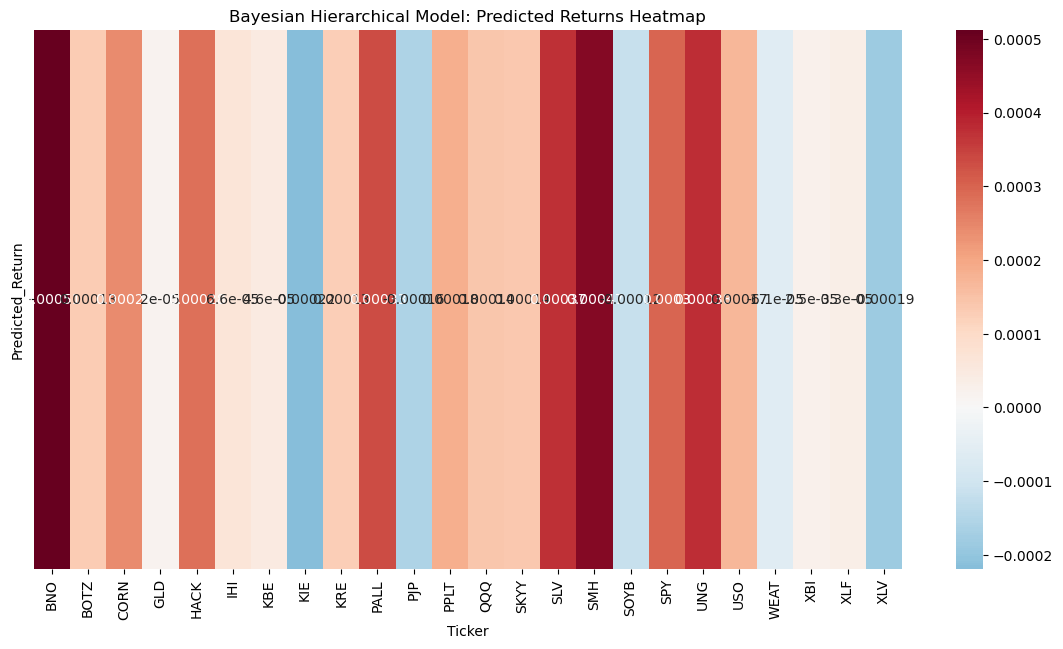

In [19]:
# Heatmaps for predicted returns
import matplotlib.pyplot as plt
import seaborn as sns

# BL Model:
plt.figure(figsize=(14, 7))
sns.heatmap(predictions_df[['Ticker', 'Predicted_Return']].set_index('Ticker').T, cmap='RdBu_r', annot=True, center=0)
plt.title("Bayesian Hierarchical Model: Predicted Returns Heatmap")
plt.show()

In [ ]:
# Need to work upon the following daily_predicted_returns
# Assuming `daily_predictions_df` contains datewise predictions for Bayesian Hierarchical Model
# and `test_df` contains the actual returns

plt.figure(figsize=(14, 7))
for ticker in predictions_df['Ticker']:
    plt.plot(test_df[test_df['Ticker'] == ticker]['Date'], test_df[test_df['Ticker'] == ticker]['daily_return'], label=f'Actual {ticker}')
    plt.plot(daily_predictions_df['Date'], daily_predictions_df[ticker], linestyle='--', label=f'Predicted {ticker}')

plt.title("Bayesian Hierarchical Model: Actual vs. Predicted Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

# Model update with 2023 Test Data Only


Posterior Expected Returns:
 Ticker
BNO     0.062504
BOTZ   -0.068416
CORN    0.059144
GLD     0.047105
HACK   -0.010965
IHI     0.022611
KBE    -0.043573
KIE     0.001439
KRE    -0.036291
PALL    0.017194
PJP    -0.014071
PPLT    0.017621
QQQ     0.009344
SKYY   -0.033485
SLV     0.042138
SMH     0.027166
SOYB    0.056577
SPY     0.001547
UNG    -0.051402
USO    -0.032980
WEAT    0.041019
XBI    -0.048713
XLF    -0.013359
XLV     0.019461
dtype: float64


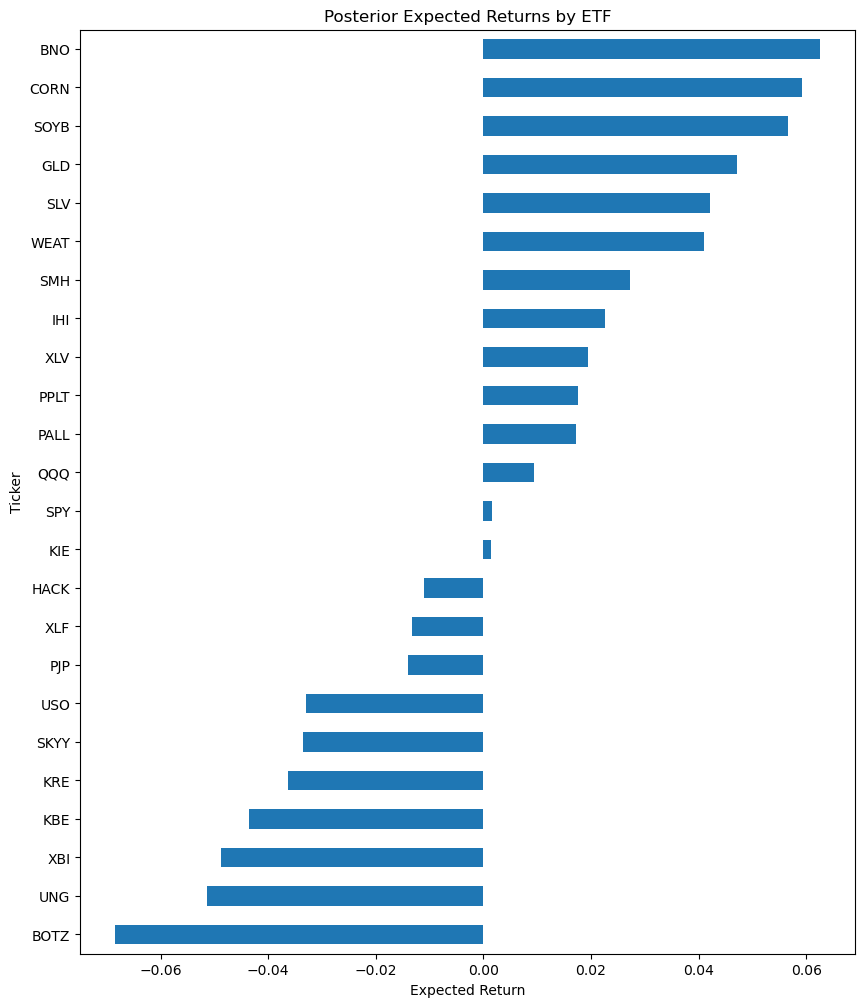


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.266320
BOTZ    0.220653
CORN    0.149532
GLD     0.101686
HACK    0.191948
IHI     0.170961
KBE     0.250749
KIE     0.191566
KRE     0.263264
PALL    0.293989
PJP     0.157709
PPLT    0.204221
QQQ     0.179623
SKYY    0.228038
SLV     0.193731
SMH     0.263296
SOYB    0.134567
SPY     0.137718
UNG     0.395236
USO     0.290544
WEAT    0.197854
XBI     0.256678
XLF     0.171741
XLV     0.131410
dtype: float64


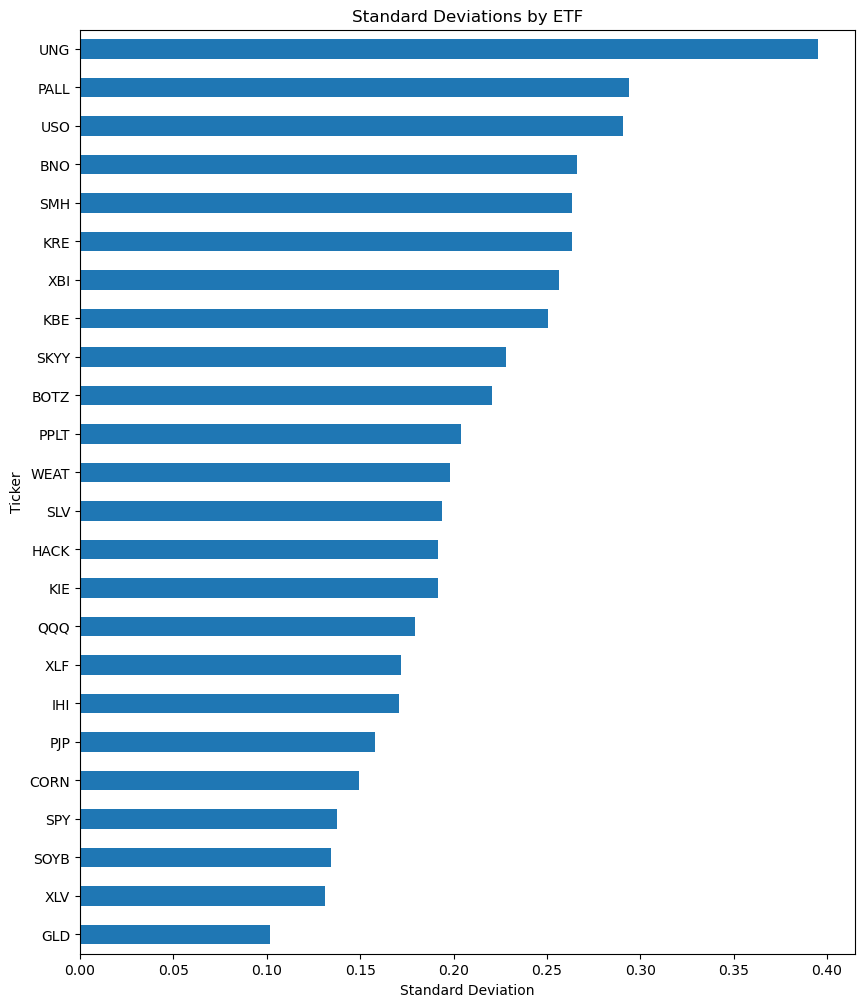


Potential Future Optimized Weights: OrderedDict([('BNO', 0.07028), ('BOTZ', 0.0), ('CORN', 0.21822), ('GLD', 0.49679), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.21471), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


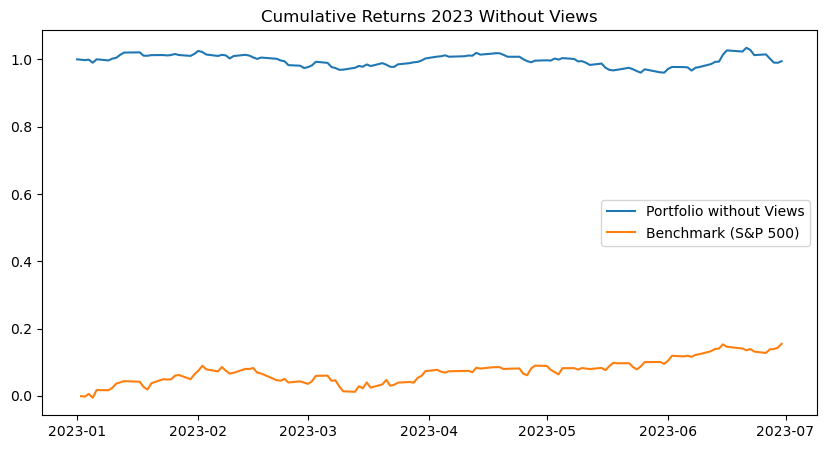


Performance Metrics for 2023 without Views:
Total Return: -0.54%
Sharpe Ratio: -0.00
Max Drawdown: -6.31%
Volatility: 0.50%


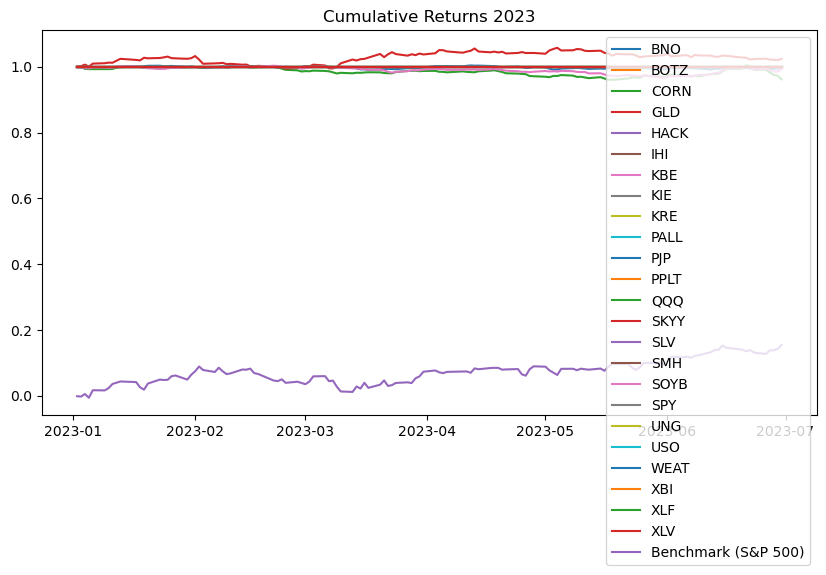

Assets that diverged significantly from views: ['BNO', 'BOTZ', 'CORN', 'HACK', 'KBE', 'KRE', 'PALL', 'PPLT', 'QQQ', 'SKYY', 'SMH', 'SPY', 'UNG', 'WEAT']

Performance Metrics for 2023:
Total Return: 2297.52%
Sharpe Ratio: -0.02
Max Drawdown: -0.30%
Volatility: 0.57%

Benchmark Comparison (SPY):
Total Return: 15.46%
Sharpe Ratio: 2.03

View Validation Metrics:
Accuracy: 8.33%
Precision: 12.50%


In [1]:
# CAUTION NOTE: 2023, but for testing taking only 2022 starting phase

import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

testing_data = df[df['Date'].between('2023-01-01', '2023-06-30')]
df = df[df['Date'].between('2018-01-01', '2022-12-31')]

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)

combined_views = defaultdict(float)
signal_views = defaultdict(dict)

# Moving Average Signal
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        signal_views[ticker]['ma_signal'] = 0.025

# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        signal_views[ticker]['momentum_signal'] = 0.03
    elif ticker_data['momentum'] < 0:
        signal_views[ticker]['momentum_signal'] = -0.03

# Volume-based views
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        signal_views[ticker]['volume_signal'] = 0.02

# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            signal_views[ticker]['bci_signal_banking'] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            signal_views[ticker]['bci_signal_gold'] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        signal_views[ticker]['cci_signal'] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        signal_views[ticker]['ir_signal'] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = 0.03
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = -0.03

def ma_signal(ticker_data):
    return 0.02 if ticker_data['MA_50'] > ticker_data['MA_200'] else 0

def momentum_signal(ticker_data):
    if ticker_data['momentum'] > 0:
        return 0.03
    elif ticker_data['momentum'] < 0:
        return -0.03
    return 0

def volume_signal(ticker_data, average_volume):
    return 0.02 if ticker_data['Volume'] > 1.5 * average_volume else 0

def bci_signal(ticker_data):
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            return 0.025
        elif ticker_data['Sector'] == 'Gold':
            return -0.025
    return 0

def cci_signal(ticker_data):
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        return 0.02
    return 0

def ir_signal(ticker_data, df):
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        if ticker_data['Sector'] == 'Banking':
            return 0.015
    return 0

# ... Continue for all your views in a similar fashion ...

# Applying the views on the dataframe
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    
    average_volume = df[df['Ticker'] == ticker]['Volume'].mean()
    
    signal_views[ticker]['ma_signal'] = ma_signal(ticker_data)
    signal_views[ticker]['momentum_signal'] = momentum_signal(ticker_data)
    signal_views[ticker]['volume_signal'] = volume_signal(ticker_data, average_volume)
    signal_views[ticker]['bci_signal'] = bci_signal(ticker_data)
    signal_views[ticker]['cci_signal'] = cci_signal(ticker_data)
    signal_views[ticker]['ir_signal'] = ir_signal(ticker_data, df)
    
    # ... Apply the rest of your views in a similar fashion ...

# Combine views
for ticker, views_dict in signal_views.items():
    combined_view = sum(views_dict.values())
    combined_views[ticker] = combined_view

# Capping views
MAX_VIEW = 0.5
MIN_VIEW = -0.5
for ticker, view in combined_views.items():
    if view > MAX_VIEW:
        combined_views[ticker] = MAX_VIEW
    elif view < MIN_VIEW:
        combined_views[ticker] = MIN_VIEW


# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(combined_views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Load data
# ... [rest of the code stays unchanged till Q and P matrices] ...

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in combined_views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

# Assuming 'prices_2023' is your DataFrame with daily prices of all assets for 2023.
prices_2023 = testing_data.pivot(index='Date', columns='Ticker', values='Close')

# 1. Portfolio Construction for 2023 using the weights optimized using Black-Litterman model outputs
# (You have already computed these as 'future_optimized_weights')

# 2. Calculate Portfolio Returns for 2023:
portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights)
cumulative_returns_2023 = (1 + portfolio_returns_2023).cumprod()

# 3. Performance Metrics:
# total_return_2023 = cumulative_returns_2023.iloc[-1] - 1
# total_return_2023 = cumulative_returns_2023.iloc[-1]
total_return_2023 = cumulative_returns_2023.sum(axis=1).iloc[-1] - 1
# sharpe_ratio_2023 = portfolio_returns_2023.mean() / portfolio_returns_2023.std()
# max_drawdown_2023 = cumulative_returns_2023.div(cumulative_returns_2023.cummax()).min() - 1
# volatility_2023 = portfolio_returns_2023.std()
sharpe_ratio_2023 = portfolio_returns_2023.sum(axis=1).mean() / portfolio_returns_2023.sum(axis=1).std()
max_drawdown_2023 = (cumulative_returns_2023.sum(axis=1) / cumulative_returns_2023.sum(axis=1).cummax() - 1).min()
volatility_2023 = portfolio_returns_2023.sum(axis=1).std()


# 4. Benchmark Comparison (assuming SPY is your benchmark):
benchmark = prices_2023['SPY'].pct_change().cumsum()
benchmark_total_return = benchmark.iloc[-1]
benchmark_sharpe_ratio = benchmark.mean() / benchmark.std()

# 5. Validation of Views:
correct_predictions = sum([
    1 for asset, view in combined_views.items() 
    if asset in portfolio_returns_2023.columns and 
    np.sign(portfolio_returns_2023[asset].sum()) == np.sign(view)
])
accuracy = correct_predictions / len(combined_views)
precision = sum([1 for asset, view in combined_views.items() if view > 0 and portfolio_returns_2023[asset].sum() > 0]) / sum([1 for asset, view in combined_views.items() if view > 0])

# 6. Placeholder for Backtest without Views:
# ... Your implementation ...
############### edit
# 6. Backtest without Views:

# Portfolio Optimization using just historical data
ef_no_views = EfficientFrontier(mean_returns_all, cov_matrix_all)
weights_no_views = ef_no_views.max_sharpe()
cleaned_weights_no_views = ef_no_views.clean_weights()

# Portfolio Returns for 2023 without views
portfolio_returns_no_views_2023 = (prices_2023.pct_change() * pd.Series(cleaned_weights_no_views)).sum(axis=1)
cumulative_returns_no_views_2023 = (1 + portfolio_returns_no_views_2023).cumprod()

# Performance Metrics without views
total_return_no_views_2023 = cumulative_returns_no_views_2023.iloc[-1] - 1
sharpe_ratio_no_views_2023 = portfolio_returns_no_views_2023.mean() / portfolio_returns_no_views_2023.std()
max_drawdown_no_views_2023 = cumulative_returns_no_views_2023.div(cumulative_returns_no_views_2023.cummax()).min() - 1
volatility_no_views_2023 = portfolio_returns_no_views_2023.std()

# Visualization of Backtest without views
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_no_views_2023, label="Portfolio without Views")
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023 Without Views")
plt.legend()
plt.show()

print("\nPerformance Metrics for 2023 without Views:")
print(f"Total Return: {total_return_no_views_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_no_views_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_no_views_2023:.2%}")
print(f"Volatility: {volatility_no_views_2023:.2%}")
################### edit complete

# 7. Visualizations:
plt.figure(figsize=(10, 5))
# plt.plot(cumulative_returns_2023, label="Portfolio")
for col in cumulative_returns_2023.columns:
    plt.plot(cumulative_returns_2023[col], label=col)
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023")
plt.legend()
plt.show()

# 8. Diagnostics:
# Examining assets that performed far from their expected returns
asset_performance = prices_2023.pct_change().sum()
divergence_from_view = {asset: performance - bl_return_all[asset] for asset, performance in asset_performance.items() if asset in combined_views}
assets_to_inspect = [asset for asset, divergence in divergence_from_view.items() if abs(divergence) > 0.1]

print(f"Assets that diverged significantly from views: {assets_to_inspect}")

print("\nPerformance Metrics for 2023:")
print(f"Total Return: {total_return_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_2023:.2%}")
print(f"Volatility: {volatility_2023:.2%}")

print("\nBenchmark Comparison (SPY):")
print(f"Total Return: {benchmark_total_return:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

print("\nView Validation Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")

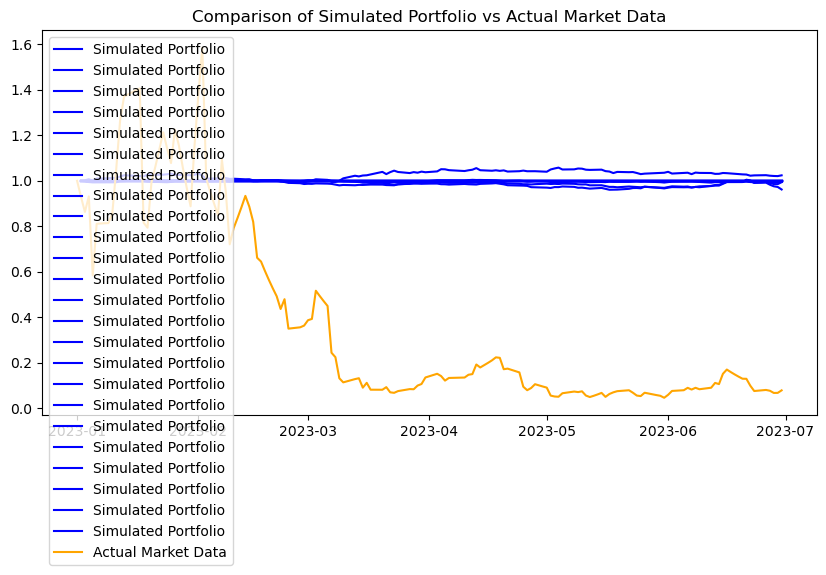

Performance Metrics for Simulated Portfolio:


TypeError: unsupported format string passed to Series.__format__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'prices_2023' is your DataFrame with daily prices of all assets for 2023.
prices_2023 = testing_data.pivot(index='Date', columns='Ticker', values='Close')

# Portfolio Optimization using Black-Litterman (BL) to generate optimized weights
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

# 1. Portfolio Construction for 2023 using the weights optimized using Black-Litterman model outputs
portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights)

# 2. Calculate Cumulative Returns for both simulated portfolio and actual market data for 2023
cumulative_returns_2023_simulated = (1 + portfolio_returns_2023).cumprod()
cumulative_returns_2023_actual = (1 + prices_2023.pct_change().sum(axis=1)).cumprod()

# 3. Visualize the performance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_2023_simulated, label="Simulated Portfolio", color='blue')
plt.plot(cumulative_returns_2023_actual, label="Actual Market Data", color='orange')
plt.title("Comparison of Simulated Portfolio vs Actual Market Data")
plt.legend()
plt.show()

# 4. Calculate Performance Metrics
total_return_simulated = cumulative_returns_2023_simulated.iloc[-1] - 1
total_return_actual = cumulative_returns_2023_actual.iloc[-1] - 1

sharpe_ratio_simulated = portfolio_returns_2023.sum(axis=1).mean() / portfolio_returns_2023.sum(axis=1).std()
sharpe_ratio_actual = prices_2023.pct_change().sum(axis=1).mean() / prices_2023.pct_change().sum(axis=1).std()

max_drawdown_simulated = (cumulative_returns_2023_simulated / cumulative_returns_2023_simulated.cummax() - 1).min()
max_drawdown_actual = (cumulative_returns_2023_actual / cumulative_returns_2023_actual.cummax() - 1).min()

# 5. Display Performance Metrics
print("Performance Metrics for Simulated Portfolio:")
print(f"Total Return: {total_return_simulated:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_simulated:.2f}")
print(f"Max Drawdown: {max_drawdown_simulated:.2%}")

print("\nPerformance Metrics for Actual Market Data:")
print(f"Total Return: {total_return_actual:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_actual:.2f}")
print(f"Max Drawdown: {max_drawdown_actual:.2%}")


In [6]:
print(cumulative_returns_2023.head())  # Print the first few rows
print(cumulative_returns_2023.shape)     # Print the dimensions (rows, columns)

Ticker           BNO  BOTZ      CORN       GLD  HACK  IHI  KBE  KIE  KRE  \
Date                                                                       
2023-01-01       NaN   NaN       NaN       NaN   NaN  NaN  NaN  NaN  NaN   
2023-01-02  0.999271   1.0  0.999389  1.001035   1.0  1.0  1.0  1.0  1.0   
2023-01-03  0.998534   1.0  0.998776  1.002069   1.0  1.0  1.0  1.0  1.0   
2023-01-04  0.994809   1.0  0.994520  1.006755   1.0  1.0  1.0  1.0  1.0   
2023-01-05  0.995327   1.0  0.993024  1.000527   1.0  1.0  1.0  1.0  1.0   

Ticker      PALL  ...  SLV  SMH      SOYB  SPY  UNG  USO  WEAT  XBI  XLF  XLV  
Date              ...                                                          
2023-01-01   NaN  ...  NaN  NaN       NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  
2023-01-02   1.0  ...  1.0  1.0  0.999107  1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2023-01-03   1.0  ...  1.0  1.0  0.998212  1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2023-01-04   1.0  ...  1.0  1.0  0.996683  1.0  1.0  1.0   1.0  1.0

In [8]:
from sklearn.metrics import f1_score

# Calculate the F1 score for the view validation
f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 score
print('F1 score:', f1_score)

NameError: name 'y_true' is not defined

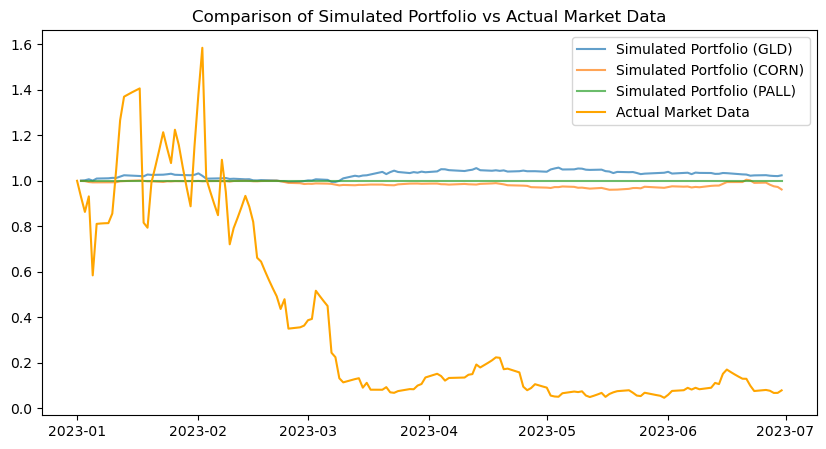

In [5]:
# Specify tickers to display in the plot
tickers_to_display = ['GLD', 'CORN', 'PALL']  # Add the tickers you want to display

# 3. Visualize the performance with selected tickers
plt.figure(figsize=(10, 5))
for ticker in tickers_to_display:
    plt.plot(cumulative_returns_2023_simulated[ticker], label=f"Simulated Portfolio ({ticker})", alpha=0.7)

plt.plot(cumulative_returns_2023_actual, label="Actual Market Data", color='orange')
plt.title("Comparison of Simulated Portfolio vs Actual Market Data")
plt.legend()
plt.show()

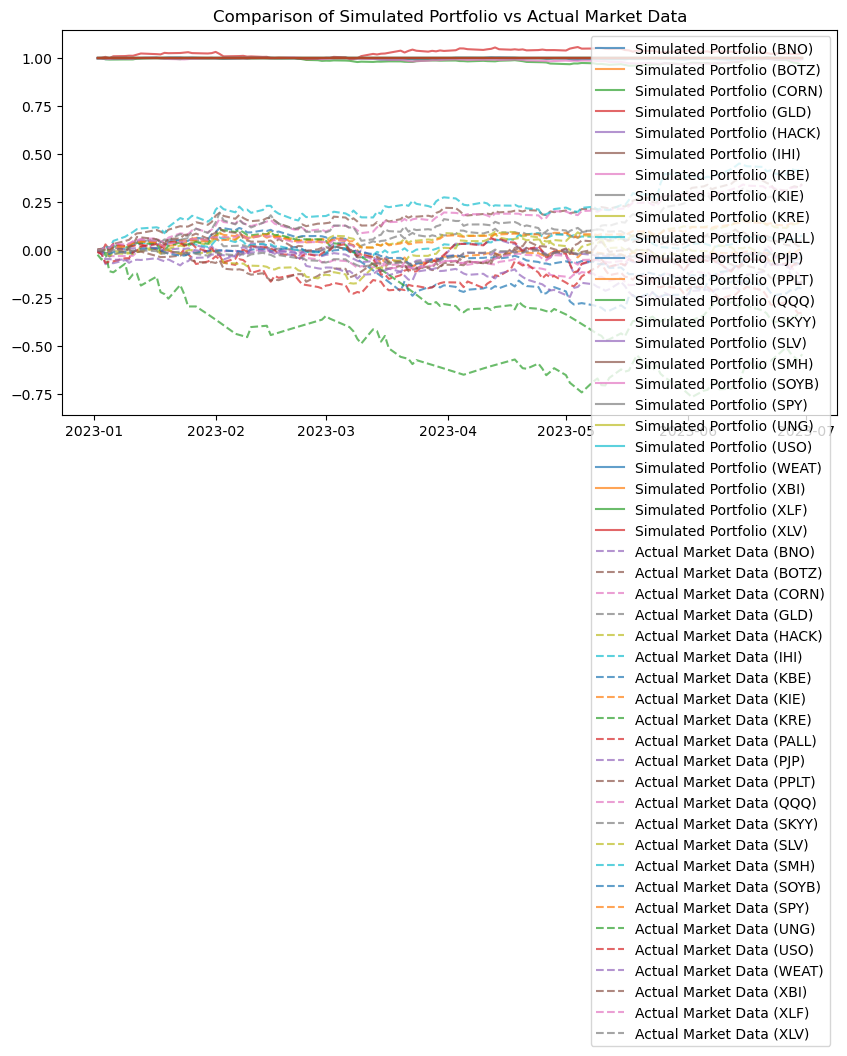

In [12]:
# 3. Visualize the performance with all tickers
plt.figure(figsize=(10, 5))

# Plot each simulated portfolio return for all tickers
for ticker in cumulative_returns_2023_simulated.columns:
    plt.plot(cumulative_returns_2023_simulated[ticker], label=f"Simulated Portfolio ({ticker})", alpha=0.7)

# Plot actual market data returns for all tickers
for ticker in prices_2023.columns:
    actual_returns = prices_2023[ticker].pct_change().cumsum()
    plt.plot(actual_returns, label=f"Actual Market Data ({ticker})", linestyle='--', alpha=0.7)

plt.title("Comparison of Simulated Portfolio vs Actual Market Data")
plt.legend()
plt.show()


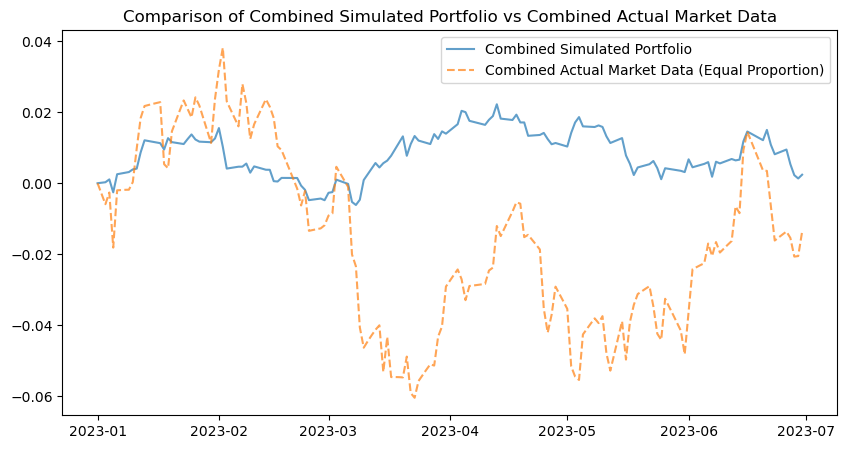

In [13]:
# 3. Visualize the performance with all tickers
plt.figure(figsize=(10, 5))

# Combined simulated portfolio return based on optimized weights
combined_simulated_returns = (portfolio_returns_2023 * future_optimized_weights).sum(axis=1).cumsum()
plt.plot(combined_simulated_returns, label="Combined Simulated Portfolio", alpha=0.7)

# Combined actual market data return for all tickers (equal proportion)
equal_weights = 1 / len(prices_2023.columns)
combined_actual_returns = (prices_2023.pct_change().cumsum() * equal_weights).sum(axis=1)
plt.plot(combined_actual_returns, label="Combined Actual Market Data (Equal Proportion)", linestyle='--', alpha=0.7)

plt.title("Comparison of Combined Simulated Portfolio vs Combined Actual Market Data")
plt.legend()
plt.show()

In [14]:
# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# Print Optimized Weights
print("\nOptimized Weights from Black-Litterman:")
print(weights_all)

# Print Posterior Expected Returns
print("\nPosterior Expected Returns from Black-Litterman:")
print(bl_return_all)


Optimized Weights from Black-Litterman:
OrderedDict([('BNO', 0.0702771157138114), ('BOTZ', 0.0), ('CORN', 0.2182203075157544), ('GLD', 0.4967941033486717), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.214708473421763), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])

Posterior Expected Returns from Black-Litterman:
Ticker
BNO     0.062504
BOTZ   -0.068416
CORN    0.059144
GLD     0.047105
HACK   -0.010965
IHI     0.022611
KBE    -0.043573
KIE     0.001439
KRE    -0.036291
PALL    0.017194
PJP    -0.014071
PPLT    0.017621
QQQ     0.009344
SKYY   -0.033485
SLV     0.042138
SMH     0.027166
SOYB    0.056577
SPY     0.001547
UNG    -0.051402
USO    -0.032980
WEAT    0.041019
XBI    -0.048713
XLF    -0.013359
XLV     0.019461
dtype: float64


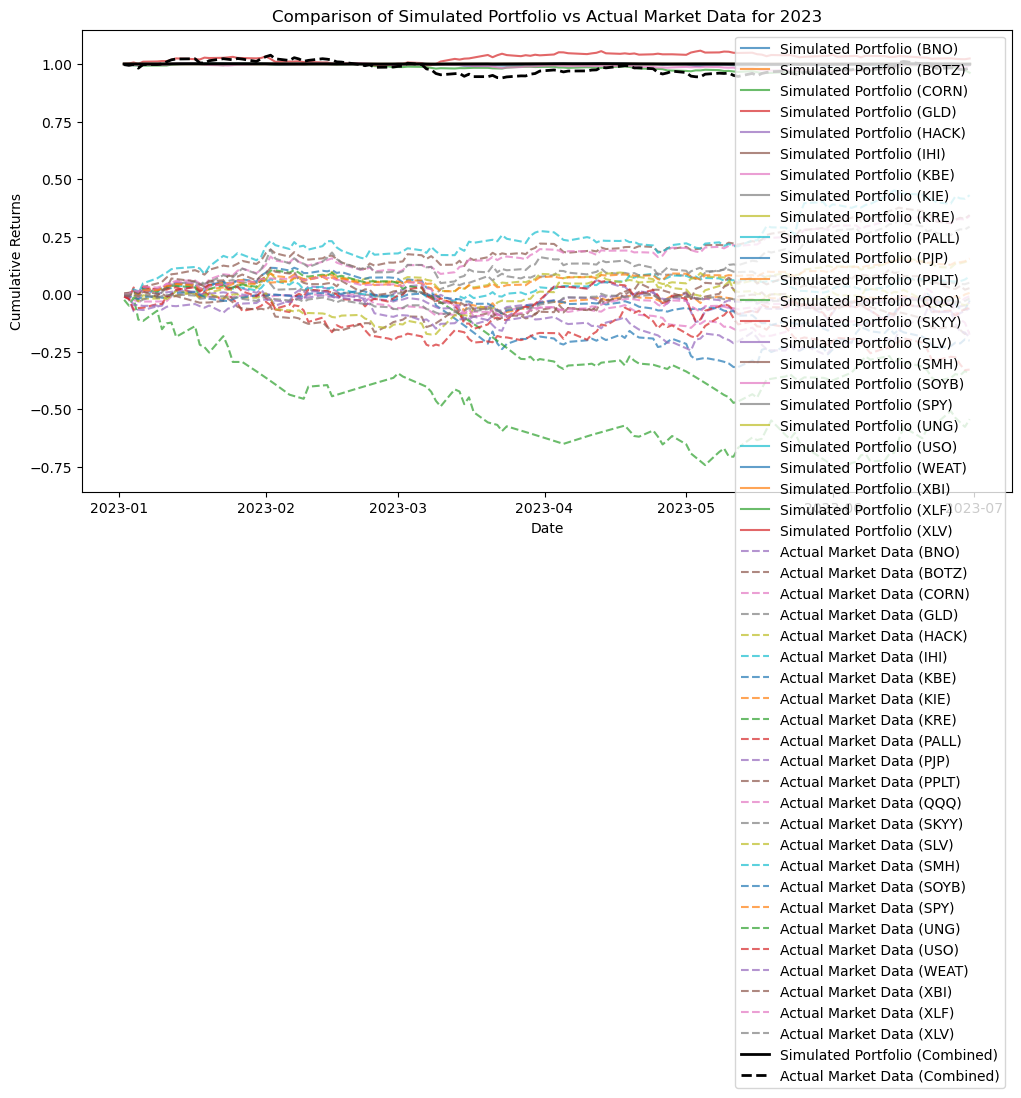


Performance Metrics for Simulated Portfolio (Combined):
Total Return: -0.10%
Sharpe Ratio: -0.02
Max Drawdown: -0.30%

Performance Metrics for Actual Market Data (Combined):
Total Return: -1.70%
Sharpe Ratio: -0.01
Max Drawdown: -9.50%


In [20]:
# Plotting Cumulative Returns for Simulated Portfolio and Actual Market Data
plt.figure(figsize=(12, 6))

# Plot simulated portfolio returns for all tickers
for ticker in cumulative_returns_2023_simulated.columns:
    plt.plot(cumulative_returns_2023_simulated[ticker], label=f"Simulated Portfolio ({ticker})", alpha=0.7)

# Plot actual market data returns for all tickers
for ticker in cumulative_returns_2023_simulated.columns:
    actual_returns = prices_2023[ticker].pct_change().cumsum()
    plt.plot(actual_returns, label=f"Actual Market Data ({ticker})", linestyle='--', alpha=0.7)

# Plot Simulated Portfolio of Combined Ticklers at Optimized Weights
combined_returns_simulated = (1 + portfolio_returns_2023.mean(axis=1)).cumprod()
plt.plot(combined_returns_simulated, label="Simulated Portfolio (Combined)", linestyle='-', linewidth=2, color='black')

# Plot Actual Market Data Combined Portfolio at Equal Proportion
equal_weights = np.ones(len(cumulative_returns_2023_simulated.columns)) / len(cumulative_returns_2023_simulated.columns)
combined_returns_actual = (1 + prices_2023[cumulative_returns_2023_simulated.columns].pct_change().dot(equal_weights)).cumprod()
plt.plot(combined_returns_actual, label="Actual Market Data (Combined)", linestyle='--', linewidth=2, color='black')

# Add labels and title
plt.title("Comparison of Simulated Portfolio vs Actual Market Data for 2023")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Calculate Performance Metrics
total_return_simulated_combined = combined_returns_simulated.iloc[-1] - 1
total_return_actual_combined = combined_returns_actual.iloc[-1] - 1

sharpe_ratio_simulated_combined = portfolio_returns_2023.mean(axis=1).mean() / portfolio_returns_2023.mean(axis=1).std()
sharpe_ratio_actual_combined = prices_2023[cumulative_returns_2023_simulated.columns].pct_change().dot(equal_weights).mean() / prices_2023[cumulative_returns_2023_simulated.columns].pct_change().dot(equal_weights).std()

max_drawdown_simulated_combined = (combined_returns_simulated / combined_returns_simulated.cummax() - 1).min()
max_drawdown_actual_combined = (combined_returns_actual / combined_returns_actual.cummax() - 1).min()

# Print Performance Metrics for Combined Portfolios
print("\nPerformance Metrics for Simulated Portfolio (Combined):")
print(f"Total Return: {total_return_simulated_combined:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_simulated_combined:.2f}")
print(f"Max Drawdown: {max_drawdown_simulated_combined:.2%}")

print("\nPerformance Metrics for Actual Market Data (Combined):")
print(f"Total Return: {total_return_actual_combined:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_actual_combined:.2f}")
print(f"Max Drawdown: {max_drawdown_actual_combined:.2%}")


KeyError: 'Sector'

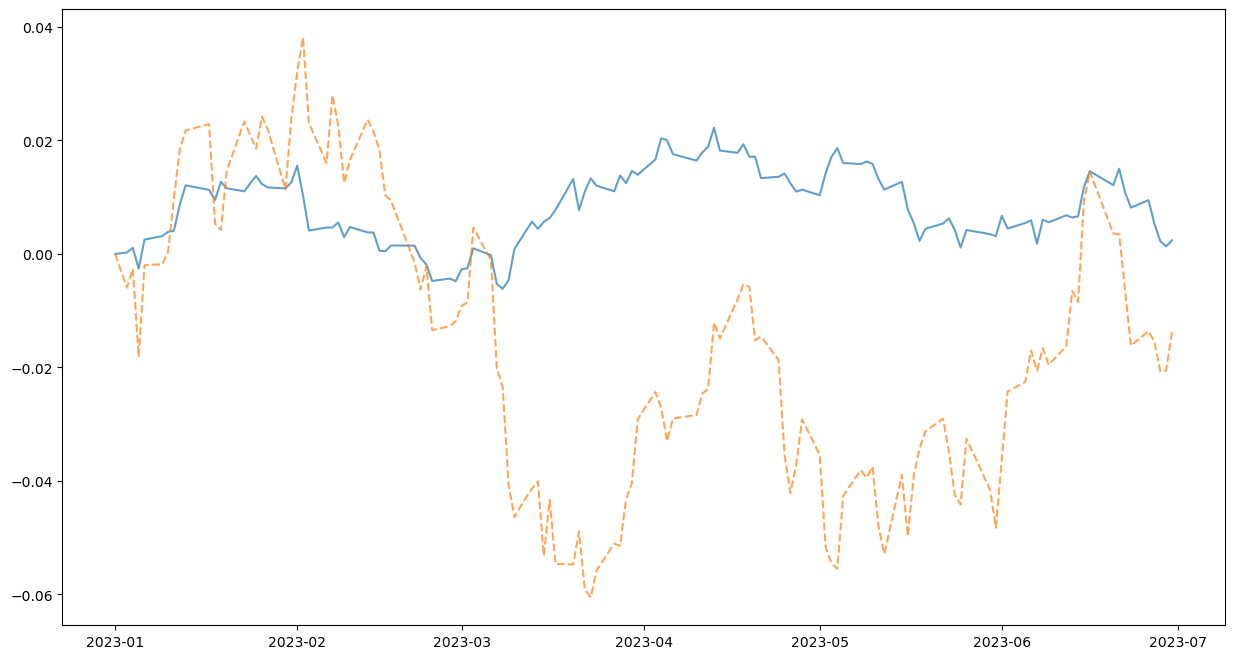

In [21]:
########### Sector Wise Pending !!!!!!!!!!!
## Here comes the case, sector also be part of pivot

# 3. Visualize the performance with all tickers
plt.figure(figsize=(15, 8))

# Combined simulated portfolio return based on optimized weights
combined_simulated_returns = (portfolio_returns_2023 * future_optimized_weights).sum(axis=1).cumsum()
plt.plot(combined_simulated_returns, label="Combined Simulated Portfolio", alpha=0.7)

# Combined actual market data return for all tickers (equal proportion)
equal_weights = 1 / len(prices_2023.columns)
combined_actual_returns = (prices_2023.pct_change().cumsum() * equal_weights).sum(axis=1)
plt.plot(combined_actual_returns, label="Combined Actual Market Data (Equal Proportion)", linestyle='--', alpha=0.7)

# Sector-wise simulated portfolio returns
for sector in prices_2023['Sector'].unique():
    sector_tickers = prices_2023[prices_2023['Sector'] == sector].columns.get_level_values(1).unique()
    sector_simulated_returns = (portfolio_returns_2023[sector_tickers] * future_optimized_weights[sector_tickers]).sum(axis=1).cumsum()
    plt.plot(sector_simulated_returns, label=f"Simulated Portfolio ({sector})", linestyle='-.', alpha=0.7)

# Individual ticker simulated portfolio returns
for ticker in prices_2023.columns.get_level_values(1).unique():
    individual_simulated_returns = (portfolio_returns_2023[ticker] * future_optimized_weights[ticker]).cumsum()
    plt.plot(individual_simulated_returns, label=f"Simulated Portfolio ({ticker})", linestyle=':', alpha=0.7)

plt.title("Comparison of Portfolios: Simulated vs Actual")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

In [ ]:
### Working on Single Ticker and Improving

In [9]:
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

testing_data = df[df['Date'].between('2023-01-01', '2023-06-30')]
df = df[df['Date'].between('2018-01-01', '2022-12-31')]

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

print(df)
print(prices_all)

            Date        Open        High         Low       Close   Adj Close  \
0     2018-01-01   16.750000   16.860000   16.745000   16.830000   16.830000   
1     2018-01-01   17.975001   18.000000   17.795000   17.932500   17.932500   
2     2018-01-01    6.000000    6.075000    5.990000    6.060000    6.060000   
3     2018-01-01  124.420002  124.907499  124.157499  124.775002  124.775002   
4     2018-01-01  102.585001  104.054998  102.507502  103.724998  103.724998   
...          ...         ...         ...         ...         ...         ...   
43819 2022-12-31   20.610000   20.705000   20.409999   20.574999   20.536615   
43820 2022-12-31   43.802499   44.282501   43.520000   44.022499   43.987818   
43821 2022-12-31  264.877495  267.345001  262.250008  265.830002  264.672417   
43822 2022-12-31   57.097499   58.037500   56.700000   57.597501   57.597501   
43823 2022-12-31  101.084999  102.050003   99.690001  101.275002  101.275002   

           Volume       Sector Ticker  

In [11]:
prices_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BNO     1826 non-null   float64
 1   BOTZ    1826 non-null   float64
 2   CORN    1826 non-null   float64
 3   GLD     1826 non-null   float64
 4   HACK    1826 non-null   float64
 5   IHI     1826 non-null   float64
 6   KBE     1826 non-null   float64
 7   KIE     1826 non-null   float64
 8   KRE     1826 non-null   float64
 9   PALL    1826 non-null   float64
 10  PJP     1826 non-null   float64
 11  PPLT    1826 non-null   float64
 12  QQQ     1826 non-null   float64
 13  SKYY    1826 non-null   float64
 14  SLV     1826 non-null   float64
 15  SMH     1826 non-null   float64
 16  SOYB    1826 non-null   float64
 17  SPY     1826 non-null   float64
 18  UNG     1826 non-null   float64
 19  USO     1826 non-null   float64
 20  WEAT    1826 non-null   float64
 21  XBI     1826 non-nu

In [1]:
print(cumulative_returns_2023_simulated)

NameError: name 'cumulative_returns_2023_simulated' is not defined

### Update 16_11_2023


Posterior Expected Returns:
 Ticker
BNO     0.062504
BOTZ   -0.068416
CORN    0.059144
GLD     0.047105
HACK   -0.010965
IHI     0.022611
KBE    -0.043573
KIE     0.001439
KRE    -0.036291
PALL    0.017194
PJP    -0.014071
PPLT    0.017621
QQQ     0.009344
SKYY   -0.033485
SLV     0.042138
SMH     0.027166
SOYB    0.056577
SPY     0.001547
UNG    -0.051402
USO    -0.032980
WEAT    0.041019
XBI    -0.048713
XLF    -0.013359
XLV     0.019461
dtype: float64


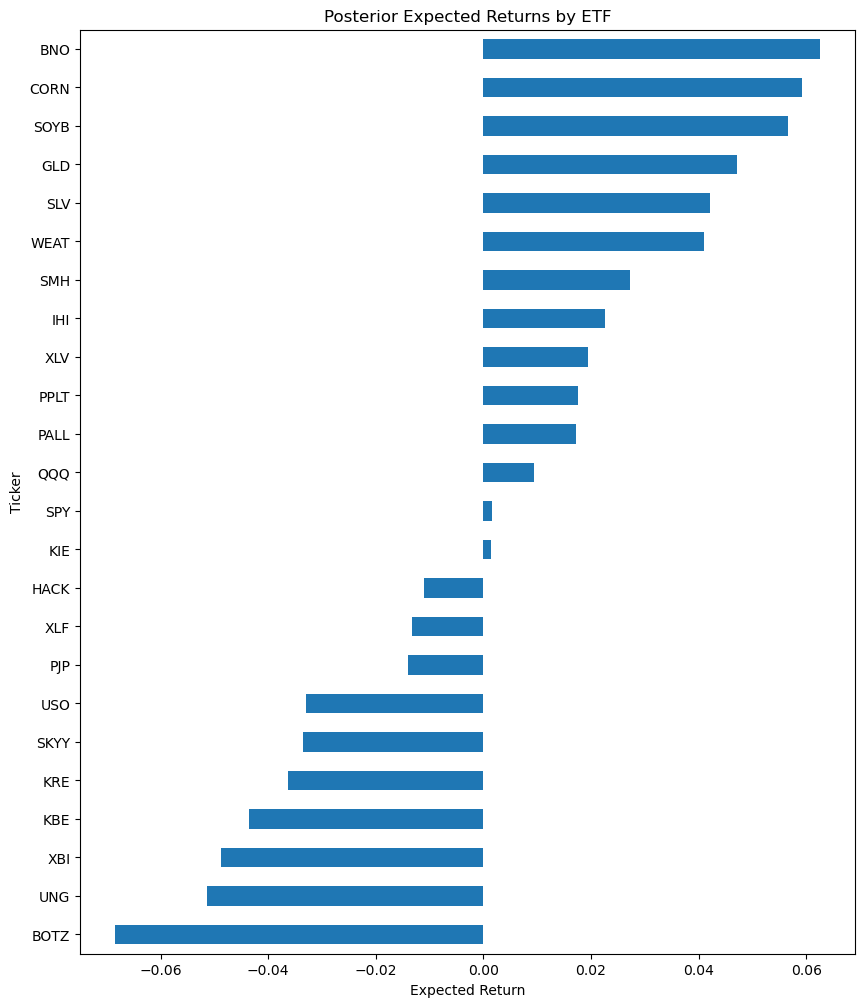


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.266320
BOTZ    0.220653
CORN    0.149532
GLD     0.101686
HACK    0.191948
IHI     0.170961
KBE     0.250749
KIE     0.191566
KRE     0.263264
PALL    0.293989
PJP     0.157709
PPLT    0.204221
QQQ     0.179623
SKYY    0.228038
SLV     0.193731
SMH     0.263296
SOYB    0.134567
SPY     0.137718
UNG     0.395236
USO     0.290544
WEAT    0.197854
XBI     0.256678
XLF     0.171741
XLV     0.131410
dtype: float64


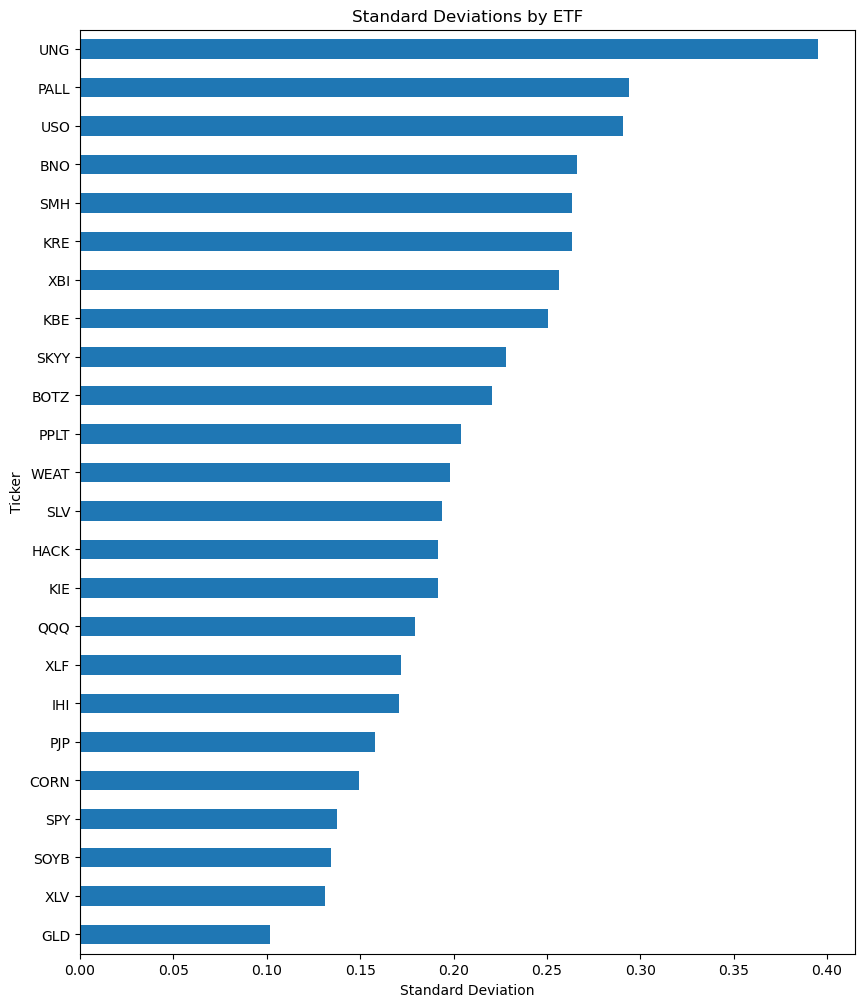


Potential Future Optimized Weights: OrderedDict([('BNO', 0.07028), ('BOTZ', 0.0), ('CORN', 0.21822), ('GLD', 0.49679), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.21471), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])


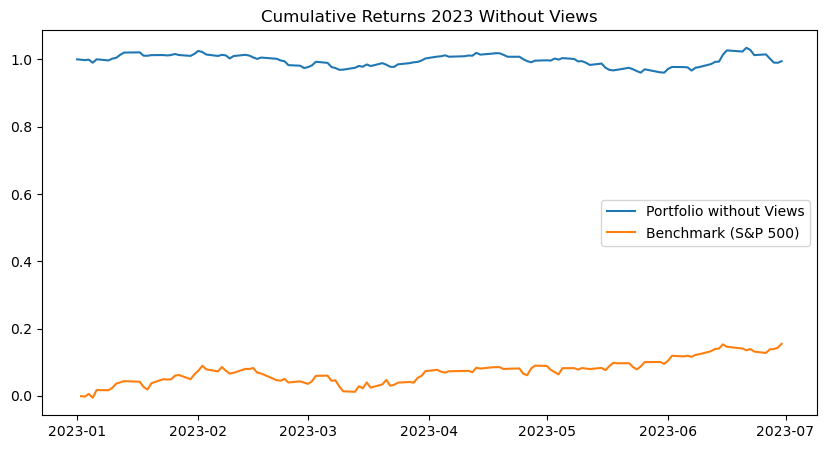


Performance Metrics for 2023 without Views:
Total Return: -0.54%
Sharpe Ratio: -0.00
Max Drawdown: -6.31%
Volatility: 0.50%


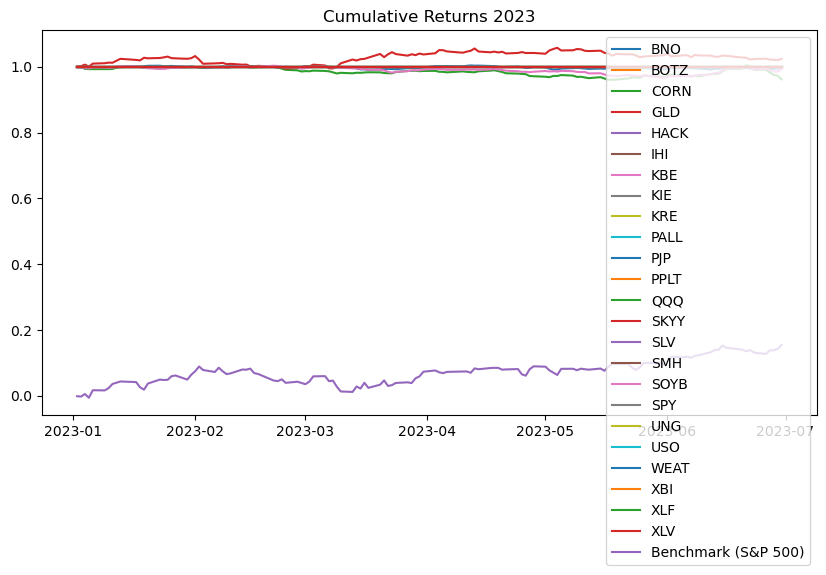

Assets that diverged significantly from views: ['BNO', 'BOTZ', 'CORN', 'HACK', 'KBE', 'KRE', 'PALL', 'PPLT', 'QQQ', 'SKYY', 'SMH', 'SPY', 'UNG', 'WEAT']

Performance Metrics for 2023:
Total Return: 2297.52%
Sharpe Ratio: -0.02
Max Drawdown: -0.30%
Volatility: 0.57%

Benchmark Comparison (SPY):
Total Return: 15.46%
Sharpe Ratio: 2.03

View Validation Metrics:
Accuracy: 8.33%
Precision: 12.50%


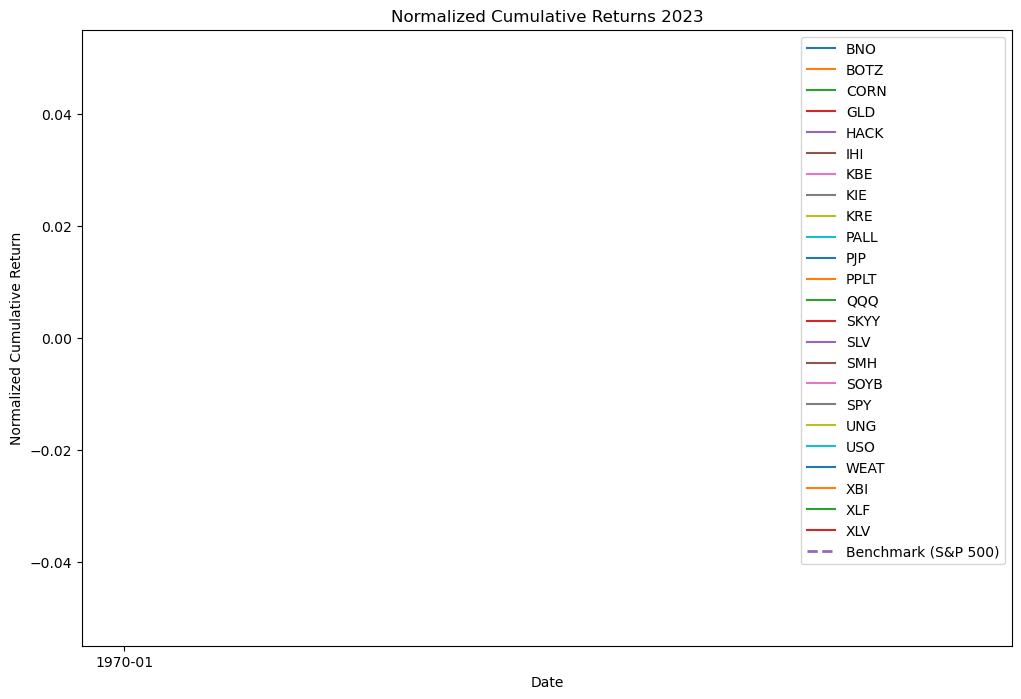

In [7]:
# CAUTION NOTE: 2023, but for testing taking only 2022 starting phase

import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

testing_data = df[df['Date'].between('2023-01-01', '2023-06-30')]
df = df[df['Date'].between('2018-01-01', '2022-12-31')]

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)

combined_views = defaultdict(float)
signal_views = defaultdict(dict)

# Moving Average Signal
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        signal_views[ticker]['ma_signal'] = 0.025

# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        signal_views[ticker]['momentum_signal'] = 0.03
    elif ticker_data['momentum'] < 0:
        signal_views[ticker]['momentum_signal'] = -0.03

# Volume-based views
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        signal_views[ticker]['volume_signal'] = 0.02

# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            signal_views[ticker]['bci_signal_banking'] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            signal_views[ticker]['bci_signal_gold'] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        signal_views[ticker]['cci_signal'] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        signal_views[ticker]['ir_signal'] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = 0.03
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = -0.03

def ma_signal(ticker_data):
    return 0.02 if ticker_data['MA_50'] > ticker_data['MA_200'] else 0

def momentum_signal(ticker_data):
    if ticker_data['momentum'] > 0:
        return 0.03
    elif ticker_data['momentum'] < 0:
        return -0.03
    return 0

def volume_signal(ticker_data, average_volume):
    return 0.02 if ticker_data['Volume'] > 1.5 * average_volume else 0

def bci_signal(ticker_data):
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            return 0.025
        elif ticker_data['Sector'] == 'Gold':
            return -0.025
    return 0

def cci_signal(ticker_data):
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        return 0.02
    return 0

def ir_signal(ticker_data, df):
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        if ticker_data['Sector'] == 'Banking':
            return 0.015
    return 0

# ... Continue for all your views in a similar fashion ...

# Applying the views on the dataframe
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    
    average_volume = df[df['Ticker'] == ticker]['Volume'].mean()
    
    signal_views[ticker]['ma_signal'] = ma_signal(ticker_data)
    signal_views[ticker]['momentum_signal'] = momentum_signal(ticker_data)
    signal_views[ticker]['volume_signal'] = volume_signal(ticker_data, average_volume)
    signal_views[ticker]['bci_signal'] = bci_signal(ticker_data)
    signal_views[ticker]['cci_signal'] = cci_signal(ticker_data)
    signal_views[ticker]['ir_signal'] = ir_signal(ticker_data, df)
    
    # ... Apply the rest of your views in a similar fashion ...

# Combine views
for ticker, views_dict in signal_views.items():
    combined_view = sum(views_dict.values())
    combined_views[ticker] = combined_view

# Capping views
MAX_VIEW = 0.5
MIN_VIEW = -0.5
for ticker, view in combined_views.items():
    if view > MAX_VIEW:
        combined_views[ticker] = MAX_VIEW
    elif view < MIN_VIEW:
        combined_views[ticker] = MIN_VIEW


# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(combined_views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Load data
# ... [rest of the code stays unchanged till Q and P matrices] ...

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in combined_views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

# Assuming 'prices_2023' is your DataFrame with daily prices of all assets for 2023.
prices_2023 = testing_data.pivot(index='Date', columns='Ticker', values='Close')

# 1. Portfolio Construction for 2023 using the weights optimized using Black-Litterman model outputs
# (You have already computed these as 'future_optimized_weights')

# 2. Calculate Portfolio Returns for 2023:
portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights)
cumulative_returns_2023 = (1 + portfolio_returns_2023).cumprod()

# 3. Performance Metrics:
# total_return_2023 = cumulative_returns_2023.iloc[-1] - 1
# total_return_2023 = cumulative_returns_2023.iloc[-1]
total_return_2023 = cumulative_returns_2023.sum(axis=1).iloc[-1] - 1
# sharpe_ratio_2023 = portfolio_returns_2023.mean() / portfolio_returns_2023.std()
# max_drawdown_2023 = cumulative_returns_2023.div(cumulative_returns_2023.cummax()).min() - 1
# volatility_2023 = portfolio_returns_2023.std()
sharpe_ratio_2023 = portfolio_returns_2023.sum(axis=1).mean() / portfolio_returns_2023.sum(axis=1).std()
max_drawdown_2023 = (cumulative_returns_2023.sum(axis=1) / cumulative_returns_2023.sum(axis=1).cummax() - 1).min()
volatility_2023 = portfolio_returns_2023.sum(axis=1).std()


# 4. Benchmark Comparison (assuming SPY is your benchmark):
benchmark = prices_2023['SPY'].pct_change().cumsum()
benchmark_total_return = benchmark.iloc[-1]
benchmark_sharpe_ratio = benchmark.mean() / benchmark.std()

# 5. Validation of Views:
correct_predictions = sum([
    1 for asset, view in combined_views.items() 
    if asset in portfolio_returns_2023.columns and 
    np.sign(portfolio_returns_2023[asset].sum()) == np.sign(view)
])
accuracy = correct_predictions / len(combined_views)
precision = sum([1 for asset, view in combined_views.items() if view > 0 and portfolio_returns_2023[asset].sum() > 0]) / sum([1 for asset, view in combined_views.items() if view > 0])

# 6. Placeholder for Backtest without Views:
# ... Your implementation ...
############### edit
# 6. Backtest without Views:

# Portfolio Optimization using just historical data
ef_no_views = EfficientFrontier(mean_returns_all, cov_matrix_all)
weights_no_views = ef_no_views.max_sharpe()
cleaned_weights_no_views = ef_no_views.clean_weights()

# Portfolio Returns for 2023 without views
portfolio_returns_no_views_2023 = (prices_2023.pct_change() * pd.Series(cleaned_weights_no_views)).sum(axis=1)
cumulative_returns_no_views_2023 = (1 + portfolio_returns_no_views_2023).cumprod()

# Performance Metrics without views
total_return_no_views_2023 = cumulative_returns_no_views_2023.iloc[-1] - 1
sharpe_ratio_no_views_2023 = portfolio_returns_no_views_2023.mean() / portfolio_returns_no_views_2023.std()
max_drawdown_no_views_2023 = cumulative_returns_no_views_2023.div(cumulative_returns_no_views_2023.cummax()).min() - 1
volatility_no_views_2023 = portfolio_returns_no_views_2023.std()

# Visualization of Backtest without views
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_no_views_2023, label="Portfolio without Views")
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023 Without Views")
plt.legend()
plt.show()

print("\nPerformance Metrics for 2023 without Views:")
print(f"Total Return: {total_return_no_views_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_no_views_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_no_views_2023:.2%}")
print(f"Volatility: {volatility_no_views_2023:.2%}")
################### edit complete

# 7. Visualizations:
plt.figure(figsize=(10, 5))
# plt.plot(cumulative_returns_2023, label="Portfolio")
for col in cumulative_returns_2023.columns:
    plt.plot(cumulative_returns_2023[col], label=col)
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023")
plt.legend()
plt.show()

# 8. Diagnostics:
# Examining assets that performed far from their expected returns
asset_performance = prices_2023.pct_change().sum()
divergence_from_view = {asset: performance - bl_return_all[asset] for asset, performance in asset_performance.items() if asset in combined_views}
assets_to_inspect = [asset for asset, divergence in divergence_from_view.items() if abs(divergence) > 0.1]

print(f"Assets that diverged significantly from views: {assets_to_inspect}")

print("\nPerformance Metrics for 2023:")
print(f"Total Return: {total_return_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_2023:.2%}")
print(f"Volatility: {volatility_2023:.2%}")

print("\nBenchmark Comparison (SPY):")
print(f"Total Return: {benchmark_total_return:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

print("\nView Validation Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")

import matplotlib.dates as mdates

# 7. Visualizations:
plt.figure(figsize=(12, 8))

# Plot each column separately and label them
for col in cumulative_returns_2023.columns:
    normalized_col = cumulative_returns_2023[col] / cumulative_returns_2023[col].iloc[0]
    plt.plot(normalized_col, label=col)

plt.plot(normalized_benchmark, label="Benchmark (S&P 500)", linestyle="--", linewidth=2)  # Adding benchmark separately with a dashed line
plt.title("Normalized Cumulative Returns 2023")
plt.xlabel("Date")
plt.ylabel("Normalized Cumulative Return")
plt.legend()

# Format x-axis labels to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()


In [ ]:
Another thought of improvement at (no views,views) -> (0,1); accuracy of (true,predicted line); sensitivity analysis of views:


Posterior Expected Returns:
 Ticker
BNO     0.062504
BOTZ   -0.068416
CORN    0.059144
GLD     0.047105
HACK   -0.010965
IHI     0.022611
KBE    -0.043573
KIE     0.001439
KRE    -0.036291
PALL    0.017194
PJP    -0.014071
PPLT    0.017621
QQQ     0.009344
SKYY   -0.033485
SLV     0.042138
SMH     0.027166
SOYB    0.056577
SPY     0.001547
UNG    -0.051402
USO    -0.032980
WEAT    0.041019
XBI    -0.048713
XLF    -0.013359
XLV     0.019461
dtype: float64


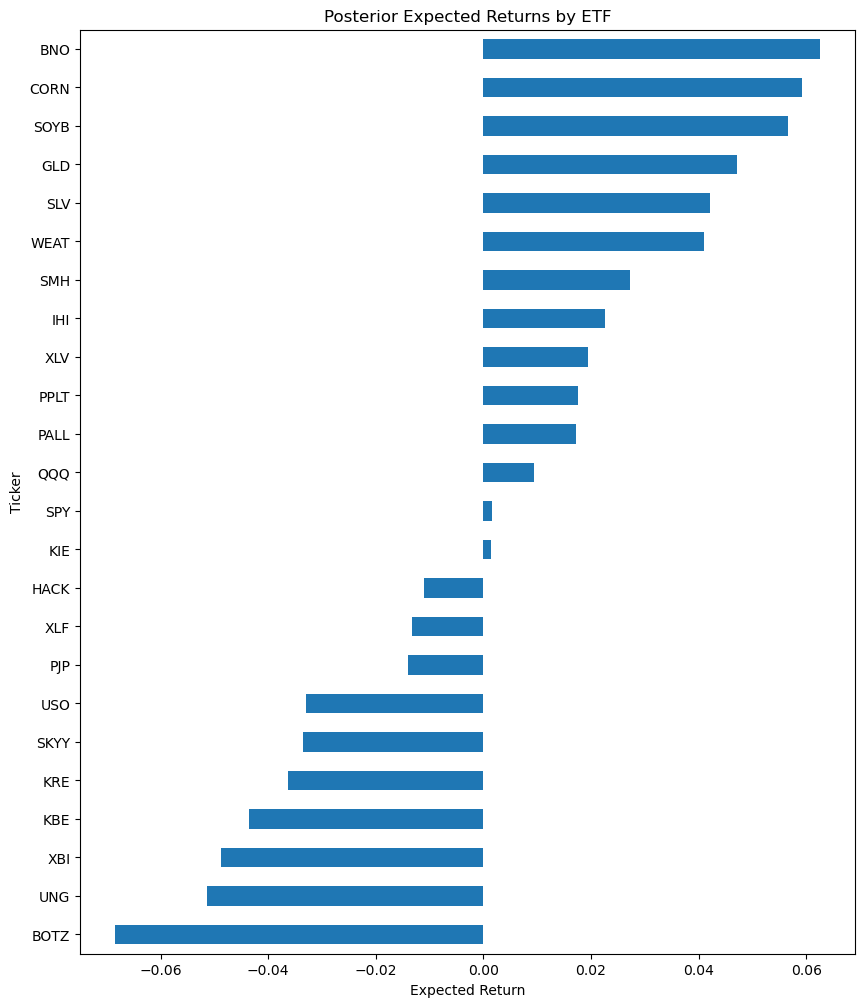


Uncertainty Measures (Standard Deviation):
 Ticker
BNO     0.266320
BOTZ    0.220653
CORN    0.149532
GLD     0.101686
HACK    0.191948
IHI     0.170961
KBE     0.250749
KIE     0.191566
KRE     0.263264
PALL    0.293989
PJP     0.157709
PPLT    0.204221
QQQ     0.179623
SKYY    0.228038
SLV     0.193731
SMH     0.263296
SOYB    0.134567
SPY     0.137718
UNG     0.395236
USO     0.290544
WEAT    0.197854
XBI     0.256678
XLF     0.171741
XLV     0.131410
dtype: float64


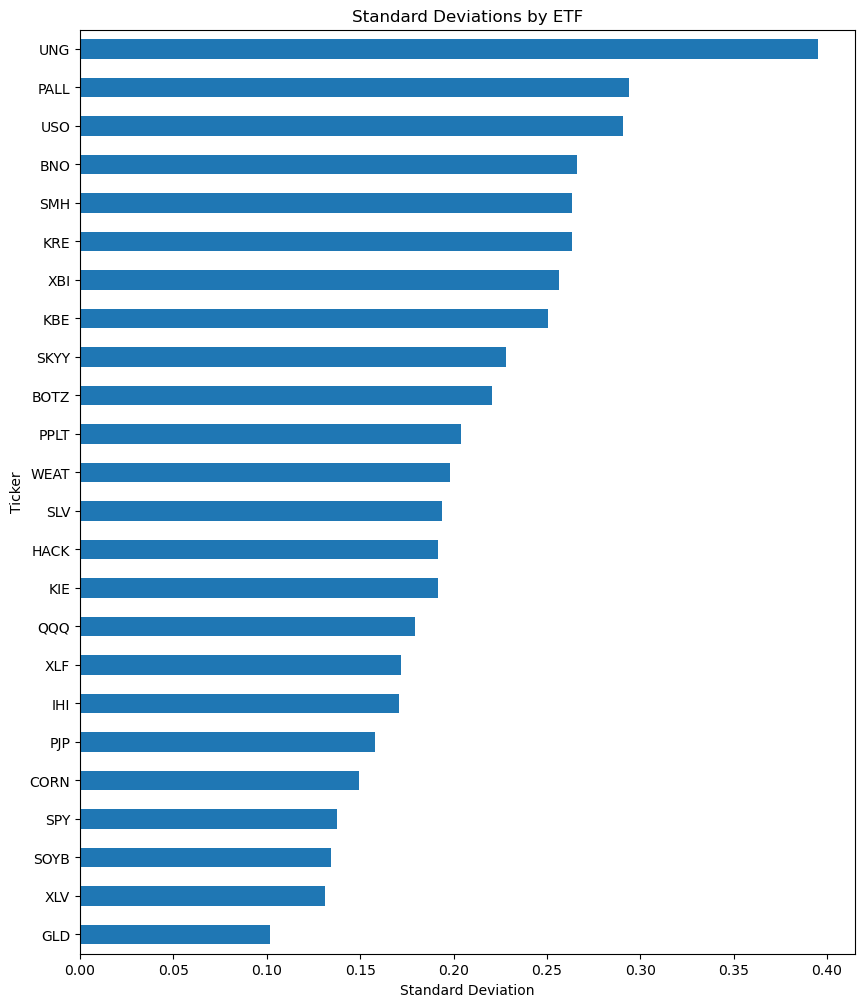


Potential Future Optimized Weights: OrderedDict([('BNO', 0.07028), ('BOTZ', 0.0), ('CORN', 0.21822), ('GLD', 0.49679), ('HACK', 0.0), ('IHI', 0.0), ('KBE', 0.0), ('KIE', 0.0), ('KRE', 0.0), ('PALL', 0.0), ('PJP', 0.0), ('PPLT', 0.0), ('QQQ', 0.0), ('SKYY', 0.0), ('SLV', 0.0), ('SMH', 0.0), ('SOYB', 0.21471), ('SPY', 0.0), ('UNG', 0.0), ('USO', 0.0), ('WEAT', 0.0), ('XBI', 0.0), ('XLF', 0.0), ('XLV', 0.0)])

Performance Metrics for 2023 without Views:


TypeError: cannot convert the series to <class 'float'>

In [34]:
# Import necessary libraries
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier
import pandas as pd
from collections import defaultdict
import numpy as np

# Load data
df = pd.read_excel('etf_ei_merged_data.xlsx')

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Separate data for testing (2023) and historical data (2018-2022)
testing_data = df[df['Date'].between('2023-01-01', '2023-06-30')]
df = df[df['Date'].between('2018-01-01', '2022-12-31')]

# Convert data to prices format for pypfopt
prices_all = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate expected returns and sample covariance for the entire data
mean_returns_all = expected_returns.mean_historical_return(prices_all)
cov_matrix_all = risk_models.sample_cov(prices_all)

# ... (omitted part for defining views and signals) ...

combined_views = defaultdict(float)
signal_views = defaultdict(dict)

# Moving Average Signal
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['MA_50'] > ticker_data['MA_200']:
        signal_views[ticker]['ma_signal'] = 0.025

# Momentum-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['momentum'] > 0:
        signal_views[ticker]['momentum_signal'] = 0.03
    elif ticker_data['momentum'] < 0:
        signal_views[ticker]['momentum_signal'] = -0.03

# Volume-based views
average_volume = df.groupby('Ticker')['Volume'].mean()
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['Volume'] > 1.5 * average_volume[ticker]:
        signal_views[ticker]['volume_signal'] = 0.02

# BCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            signal_views[ticker]['bci_signal_banking'] = 0.025
        elif ticker_data['Sector'] == 'Gold':
            signal_views[ticker]['bci_signal_gold'] = -0.025

# CCI-based views
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        signal_views[ticker]['cci_signal'] = 0.02

# Interest rate views
if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
    for ticker in df[df['Sector'] == 'Banking']['Ticker'].unique():
        signal_views[ticker]['ir_signal'] = 0.015

# Moving average crossover views
for ticker in df['Ticker'].unique():
    recent_data = df[df['Ticker'] == ticker].tail(2)
    if recent_data.iloc[0]['MA_50'] < recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] > recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = 0.03
    elif recent_data.iloc[0]['MA_50'] > recent_data.iloc[0]['MA_200'] and recent_data.iloc[1]['MA_50'] < recent_data.iloc[1]['MA_200']:
        signal_views[ticker]['ma_crossover_signal'] = -0.03

def ma_signal(ticker_data):
    return 0.02 if ticker_data['MA_50'] > ticker_data['MA_200'] else 0

def momentum_signal(ticker_data):
    if ticker_data['momentum'] > 0:
        return 0.03
    elif ticker_data['momentum'] < 0:
        return -0.03
    return 0

def volume_signal(ticker_data, average_volume):
    return 0.02 if ticker_data['Volume'] > 1.5 * average_volume else 0

def bci_signal(ticker_data):
    if ticker_data['bci'] > 100:
        if ticker_data['Sector'] == 'Banking':
            return 0.025
        elif ticker_data['Sector'] == 'Gold':
            return -0.025
    return 0

def cci_signal(ticker_data):
    if ticker_data['cci'] > 100 and ticker_data['Sector'] in ['Retail', 'Technology']:
        return 0.02
    return 0

def ir_signal(ticker_data, df):
    if df.iloc[-1]['long_term_ir'] - df.iloc[-30]['long_term_ir'] > df.iloc[-1]['short_term_ir'] - df.iloc[-30]['short_term_ir']:
        if ticker_data['Sector'] == 'Banking':
            return 0.015
    return 0

# ... Continue for all your views in a similar fashion ...

# Applying the views on the dataframe
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].iloc[-1]
    
    average_volume = df[df['Ticker'] == ticker]['Volume'].mean()
    
    signal_views[ticker]['ma_signal'] = ma_signal(ticker_data)
    signal_views[ticker]['momentum_signal'] = momentum_signal(ticker_data)
    signal_views[ticker]['volume_signal'] = volume_signal(ticker_data, average_volume)
    signal_views[ticker]['bci_signal'] = bci_signal(ticker_data)
    signal_views[ticker]['cci_signal'] = cci_signal(ticker_data)
    signal_views[ticker]['ir_signal'] = ir_signal(ticker_data, df)
    
    # ... Apply the rest of your views in a similar fashion ...

# Combine views
for ticker, views_dict in signal_views.items():
    combined_view = sum(views_dict.values())
    combined_views[ticker] = combined_view

# Capping views
MAX_VIEW = 0.5
MIN_VIEW = -0.5
for ticker, view in combined_views.items():
    if view > MAX_VIEW:
        combined_views[ticker] = MAX_VIEW
    elif view < MIN_VIEW:
        combined_views[ticker] = MIN_VIEW

# Convert views into Q and P matrices for Black-Litterman model
Q = pd.Series(combined_views)
P = pd.DataFrame(0, index=Q.index, columns=prices_all.columns)
for ticker in Q.index:
    P.loc[ticker, ticker] = 1

# Black-Litterman model setup for the entire data
bl_all = BlackLittermanModel(cov_matrix_all, pi=mean_returns_all, absolute_views=Q, P=P)

# Get the Posterior Expected Returns and Posterior Covariance Matrix
bl_return_all = bl_all.bl_returns()
bl_cov_matrix_all = bl_all.bl_cov()

# 1. Posterior Expected Returns
print("\nPosterior Expected Returns:\n", bl_return_all)

# 2. Visual Representation
bl_return_all.sort_values().plot(kind='barh', figsize=(10, 12), title="Posterior Expected Returns by ETF")
plt.xlabel('Expected Return')
plt.show()

# 3. Uncertainty Measures
uncertainty = np.sqrt(np.diag(bl_cov_matrix_all))
uncertainty_series = pd.Series(uncertainty, index=bl_cov_matrix_all.columns)
print("\nUncertainty Measures (Standard Deviation):\n", uncertainty_series)

uncertainty_series.sort_values().plot(kind='barh', figsize=(10, 12), title="Standard Deviations by ETF")
plt.xlabel('Standard Deviation')
plt.show()

# 4. Posterior Covariance Matrix
with open("posterior_covariance_matrix.txt", "w") as f:
    f.write(bl_cov_matrix_all.to_string())

# Save Posterior Covariance Matrix to a CSV as well for a more structured view
bl_cov_matrix_all.to_csv('posterior_covariance_matrix.csv')

# 5. Table of Views
with open("views_log.txt", "w") as f:
    for view, value in combined_views.items():
        f.write(f"{view}: {value}\n")

# Portfolio optimization using Black-Litterman model outputs
ef_all = EfficientFrontier(bl_return_all, cov_matrix_all)
weights_all = ef_all.max_sharpe()
future_optimized_weights = ef_all.clean_weights()

print("\nPotential Future Optimized Weights:", future_optimized_weights)

# Assuming 'prices_2023' is your DataFrame with daily prices of all assets for 2023.
prices_2023 = testing_data.pivot(index='Date', columns='Ticker', values='Close')

# 1. Portfolio Construction for 2023 using the weights optimized using Black-Litterman model outputs
# (You have already computed these as 'future_optimized_weights')

# 2. Calculate Portfolio Returns for 2023:
portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights)
cumulative_returns_2023 = (1 + portfolio_returns_2023).cumprod()

# 3. Performance Metrics:
total_return_2023 = cumulative_returns_2023.sum(axis=1).iloc[-1] - 1
sharpe_ratio_2023 = portfolio_returns_2023.sum(axis=1).mean() / portfolio_returns_2023.sum(axis=1).std()
max_drawdown_2023 = (cumulative_returns_2023.sum(axis=1) / cumulative_returns_2023.sum(axis=1).cummax() - 1).min()
volatility_2023 = portfolio_returns_2023.sum(axis=1).std()

# 4. Benchmark Comparison (assuming SPY is your benchmark):
benchmark = prices_2023['SPY'].pct_change().cumsum()
benchmark_total_return = benchmark.iloc[-1]
benchmark_sharpe_ratio = benchmark.mean() / benchmark.std()

# 5. Validation of Views:
correct_predictions = sum([
    1 for asset, view in combined_views.items() 
    if asset in portfolio_returns_2023.columns and 
    np.sign(portfolio_returns_2023[asset].sum()) == np.sign(view)
])
accuracy = correct_predictions / len(combined_views)
precision = sum([1 for asset, view in combined_views.items() if view > 0 and portfolio_returns_2023[asset].sum() > 0]) / sum([1 for asset, view in combined_views.items() if view > 0])

# 6. Backtest without Views:
# Portfolio Optimization using just historical data
ef_no_views = EfficientFrontier(mean_returns_all, cov_matrix_all)
weights_no_views = ef_no_views.max_sharpe()
cleaned_weights_no_views = ef_no_views.clean_weights()

# Portfolio Returns for 2023 without views
portfolio_returns_no_views_2023 = (prices_2023.pct_change() * pd.Series(cleaned_weights_no_views))
# portfolio_returns_no_views_2023 = (prices_2023.pct_change() * pd.Series(cleaned_weights_no_views)).sum(axis=1)
cumulative_returns_no_views_2023 = (1 + portfolio_returns_no_views_2023).cumprod()

# Performance Metrics without views
total_return_no_views_2023 = cumulative_returns_no_views_2023.iloc[-1] - 1
sharpe_ratio_no_views_2023 = portfolio_returns_no_views_2023.mean() / portfolio_returns_no_views_2023.std()
max_drawdown_no_views_2023 = cumulative_returns_no_views_2023.div(cumulative_returns_no_views_2023.cummax()).min() - 1
volatility_no_views_2023 = portfolio_returns_no_views_2023.std()

# # Print performance metrics for 2023 without views
# print("\nPerformance Metrics for 2023 without Views:")
# print(f"Total Return: {total_return_no_views_2023 * 100:.2f}%")
# print(f"Sharpe Ratio: {sharpe_ratio_no_views_2023:.2f}")
# print(f"Max Drawdown: {max_drawdown_no_views_2023 * 100:.2f}%")
# print(f"Volatility: {volatility_no_views_2023 * 100:.2f}%")

# Print performance metrics for 2023 without views
print("\nPerformance Metrics for 2023 without Views:")
print("Total Return: {:.2%}".format(float(total_return_no_views_2023)))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio_no_views_2023))
print("Max Drawdown: {:.2%}".format(max_drawdown_no_views_2023))
print("Volatility: {:.2%}".format(volatility_no_views_2023))

# Visualization of Backtest without views
plt.figure(figsize=(10, 5))
for col in cumulative_returns_no_views_2023.columns:
    plt.plot(cumulative_returns_no_views_2023[col], label=col)
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023 Without Views")
plt.legend()
plt.show()

# print("\nPerformance Metrics for 2023 without Views:")
# print(f"Total Return: {total_return_no_views_2023:.2%}")
# print(f"Sharpe Ratio: {sharpe_ratio_no_views_2023:.2f}")
# print(f"Max Drawdown: {max_drawdown_no_views_2023:.2%}")
# print(f"Volatility: {volatility_no_views_2023:.2%}")

# 7. Visualizations:
plt.figure(figsize=(10, 5))
for col in cumulative_returns_2023.columns:
    plt.plot(cumulative_returns_2023[col], label=col)
plt.plot(benchmark, label="Benchmark (S&P 500)")
plt.title("Cumulative Returns 2023")
plt.legend()
plt.show()

# 8. Diagnostics:
asset_performance = prices_2023.pct_change().sum()
divergence_from_view = {asset: performance - bl_return_all[asset] for asset, performance in asset_performance.items() if asset in combined_views}
assets_to_inspect = [asset for asset, divergence in divergence_from_view.items() if abs(divergence) > 0.1]

print(f"Assets that diverged significantly from views: {assets_to_inspect}")

print("\nPerformance Metrics for 2023:")
print(f"Total Return: {total_return_2023:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_2023:.2f}")
print(f"Max Drawdown: {max_drawdown_2023:.2%}")
print(f"Volatility: {volatility_2023:.2%}")

print("\nBenchmark Comparison (SPY):")
print(f"Total Return: {benchmark_total_return:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

print("\nView Validation Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")

# Here,at this end,i am actually retrying to print both the benchmark and cummulative returns to start from 0 rather from 1.

import matplotlib.dates as mdates

# 7. Visualizations:
plt.figure(figsize=(12, 8))
cumulative_returns_2023_n = (1 + portfolio_returns_2023).cumprod()
# cumulative_returns_2023_n = (portfolio_returns_2023).cumprod()

# Plot each column separately and label them
for col in cumulative_returns_2023.columns:
    normalized_col = cumulative_returns_2023_n[col] - 1/ cumulative_returns_2023_n[col].iloc[1]
    plt.plot(normalized_col, label=col)
#         plt.plot(cumulative_returns_2023[col], label=col)

    # Annotate the end point of each line with the column name
    plt.annotate(col, xy=(normalized_col.index[-1], normalized_col.iloc[-1]),
                 xytext=(5, 5), textcoords='offset points', color='black')


plt.plot(benchmark, label="Benchmark (S&P 500)", linestyle="--", linewidth=2)
plt.title("Normalized Cumulative Returns 2023")
plt.legend()

# Format x-axis labels to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# 
plt.show()

In [16]:
print(cumulative_returns_no_views_2023.iloc[1])

Ticker
BNO     0.999271
BOTZ    1.000000
CORN    0.999389
GLD     1.001035
HACK    1.000000
IHI     1.000000
KBE     1.000000
KIE     1.000000
KRE     1.000000
PALL    1.000000
PJP     1.000000
PPLT    1.000000
QQQ     1.000000
SKYY    1.000000
SLV     1.000000
SMH     1.000000
SOYB    0.999107
SPY     1.000000
UNG     1.000000
USO     1.000000
WEAT    1.000000
XBI     1.000000
XLF     1.000000
XLV     1.000000
Name: 2023-01-02 00:00:00, dtype: float64


In [27]:
print(cumulative_returns_no_views_2023.iloc[1])

Ticker
BNO     1.000000
BOTZ    1.000000
CORN    0.999489
GLD     1.000461
HACK    1.000000
IHI     1.000034
KBE     1.000000
KIE     1.000000
KRE     1.000000
PALL    1.000000
PJP     1.000000
PPLT    1.000000
QQQ     1.000000
SKYY    1.000000
SLV     1.000000
SMH     0.999927
SOYB    0.999136
SPY     1.000000
UNG     1.000000
USO     1.000000
WEAT    1.000000
XBI     1.000000
XLF     1.000000
XLV     0.999852
Name: 2023-01-02 00:00:00, dtype: float64


In [36]:
print(cumulative_returns_no_views_2023.columns)
print(cumulative_returns_no_views_2023.shape)

Index(['BNO', 'BOTZ', 'CORN', 'GLD', 'HACK', 'IHI', 'KBE', 'KIE', 'KRE',
       'PALL', 'PJP', 'PPLT', 'QQQ', 'SKYY', 'SLV', 'SMH', 'SOYB', 'SPY',
       'UNG', 'USO', 'WEAT', 'XBI', 'XLF', 'XLV'],
      dtype='object', name='Ticker')
(181, 24)


In [39]:
# print(portfolio_returns_2023 = prices_2023.pct_change() * pd.Series(future_optimized_weights))
print(pd.Series(future_optimized_weights).shape)
print(prices_2023.pct_change().shape)
print(portfolio_returns_2023.shape)

(24,)
(181, 24)
(181, 24)
